# Prediction Analysis
To better understand the predicting behavior, this notebook is implemented to observe how well the model performs on **validation set**. Moreover, hyperparameters (*e.g.*, mutil-horizon fusion weights) can be tuned here to see how performance changes correspondingly.

In [1]:
# Import packages
import os 
import pickle
import gc
from random import sample

import yaml
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import wandb
    
from metadata import *
from utils.evaluator_clf import EvaluatorCLF
from fe import *
from utils.dataset_generator import DataGenerator
from utils.sampler import DataSampler
from utils.common import rank_mcls_naive
from utils.evaluator import EvaluatorRank
from fuse_multi_horiz import fuse

pd.set_option("max_row", 150)

In [2]:
# Variable definitions
model_name = 'lgbm'
trained_version = [144]   # 109, 130
val_months = [24]#[23, 23]
horizons = [1]#[1, 6]

In [3]:
# Pull dumped outputs from Wandb
pred_analysis = wandb.init(project='Esun',
                           job_type='pred_analysis')
pred_reports = {}
models = {}
for (i, v), val_month in zip(enumerate(trained_version), val_months):
    horiz = horizons[i]
    output = pred_analysis.use_artifact(f'{model_name}:v{v}', type='output')
    output_dir = output.download()
    with open(os.path.join(output_dir, f"pred_reports/{val_month}.pkl"), 'rb') as f:
        pred_report = pickle.load(f)
    with open(os.path.join(output_dir, f"models/{val_month}.pkl"), 'rb') as f:
        model = pickle.load(f)
#     pred_reports[f'horiz{horiz}'] = pred_report
#     models[f'horiz{horiz}'] = model
    pred_reports[f'v{v}'] = pred_report
    models[f'v{v}'] = model  
wandb.finish()

wandb: Currently logged in as: jiangjiawei1103 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Downloading large artifact lgbm:v144, 233.57MB. 2 files... Done. 0:0:0


## Effectiveness of Multi-Horizon Fusion
To verify the effectiveness of **multi-horizon fusion**, evaluation on **validation set** must be done.

### Observation
1. Through tuning break points, I find out that maybe **horizon1** model can capture longer patterns than I thought before, because the performance boosting takes effect at **large average transaction gap**.
2. Based on observation1, if I try to fuse two models (horizon1 and 3) with small average transaction gap break point, the weight on horizon3 model (prf is much worse) will be too large, adding noise to horizon1 model.
3. Compared with public leaderboard, there's performance correlation between **val set and unseen** (in sync).

In [4]:
# Different configurations of break points. Notice list-like value is
# used when there are more than two multi-horizon models used. 
avg_gap_break_pts = {k: [v] for k, v in enumerate(range(1, 19))}

In [5]:
# Fix predicting reports to avoid duplicated samples and extend key-val
# pairs for `fuse` function
for k, v in pred_reports.items():
    pred_report_fixed = pd.DataFrame(v['y_pred'])
    pred_report_fixed['index'] = v['index']
    pred_report_fixed.drop_duplicates(inplace=True)
    pred_report_fixed.set_index('index', drop=True, inplace=True)
    pred_report_fixed.sort_index(inplace=True)
    pred_reports[k]['index'] = pred_report_fixed.index
    pred_reports[k]['y_pred_prob'] = pred_report_fixed.values

In [6]:
# Evaluate on validation set with different break points
ndcgs = {}
for _, avg_gap_break_pt in avg_gap_break_pts.items():
    pred_result_ens = fuse(pred_reports, avg_gap_break_pts=avg_gap_break_pt, t_end=val_months[0]-1)
    evaluator = EvaluatorRank("./data/raw/raw_data.parquet", t_next=val_months[0], debug=False)
    ndcg = evaluator.evaluate(pred=pred_result_ens['y_pred_fuse'])
    ndcgs[avg_gap_break_pt[0]] = ndcg
    del pred_result_ens, evaluator

Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20250.80it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 90838.34it/s]


Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20195.20it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 88897.52it/s]


Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20110.79it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 89946.70it/s]


Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20507.80it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 90204.82it/s]


Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20610.23it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 88993.12it/s]


Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20555.29it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 90906.23it/s]


Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20661.57it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 90007.52it/s]


Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20076.86it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 89642.74it/s]


Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20665.41it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 89295.20it/s]


Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20722.66it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 88863.93it/s]


Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20688.50it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 90262.85it/s]


Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20742.80it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 89933.94it/s]


Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20569.65it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 88975.63it/s]


Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20654.19it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 89519.29it/s]


Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20599.30it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 91437.02it/s]


Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20074.41it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 91293.63it/s]


Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20617.60it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 88208.16it/s]


Fusion of predicting results of multi-horizon models starts...
Deriving ensemble weights...


100%|██████████| 500000/500000 [00:24<00:00, 20130.94it/s]


Fusing probability distributions...
Ranking for final production...
Done!!



100%|██████████| 500000/500000 [00:05<00:00, 89307.70it/s]


In [7]:
ndcgs

{1: {'NDCG@3': 0.7188993500403625},
 2: {'NDCG@3': 0.7231673981733933},
 3: {'NDCG@3': 0.7245847720023891},
 4: {'NDCG@3': 0.7252281233874566},
 5: {'NDCG@3': 0.7255387811188647},
 6: {'NDCG@3': 0.7257439494358817},
 7: {'NDCG@3': 0.7257893784295981},
 8: {'NDCG@3': 0.7257839255437218},
 9: {'NDCG@3': 0.7258232502742132},
 10: {'NDCG@3': 0.7258624467048985},
 11: {'NDCG@3': 0.7258934365503656},
 12: {'NDCG@3': 0.7258936164391507},
 13: {'NDCG@3': 0.725870319838865},
 14: {'NDCG@3': 0.7258460608075988},
 15: {'NDCG@3': 0.7258586467569327},
 16: {'NDCG@3': 0.7258551196169224},
 17: {'NDCG@3': 0.7258524847593166},
 18: {'NDCG@3': 0.7258336664766195}}

## Bottleneck Analysis
### 1. Regenerate Train/Val Set and Reinference
For model trained/validated with samples filtered by **client cold-start** filter, there's a need to do reinference on **complete train/validation set**, leading to a **fair comparison** between different models. Or, the datasets are different and the performance is somehow overestimated. Furthermore, evaluation done on training set is used to observe what models didn't learn and see if this corresponds to the bottleneck in validation set (*e.g.*, `chid`s with zero-NDCGs). 

### 2. Analysis Based on Top1 and Top2 Models 
To find out what's the bottleneck dragging down the performance, it's necessary to do a reevaluation in **debugging** mode to facilitate analysis from a fine-grained perspective. 

In [34]:
# Utility function definitions
def reeval(t_end, dg_cfg, models):
    '''Reevaluate with complete datasets and return the 'real'
    performance.
    '''
    dg = DataGenerator(t_end, dg_cfg['t_window'], dg_cfg['horizon'],
                       train_leg=True, production=True, mcls=True,
                       drop_cold_start_cli=False)
    dg.run(dg_cfg['feats_to_use'])
    X, y = dg.get_X_y()
    ndcg_ = {}
    ndcgs_ = {}
    for k, model in models.items():
        y_pred = model.predict(X, num_iteration=model.best_iteration)
        pred_report = {'index': dg.pk, 'y_pred': y_pred}
        evaluator = EvaluatorRank("./data/raw/raw_data.parquet", 
                                  t_next=t_end+dg_cfg['horizon'], 
                                  debug=True)
        rank = rank_mcls_naive(pred_report['index'], pred_report['y_pred'])
        ndcg = evaluator.evaluate(rank)
        ndcgs = evaluator.NDCGs
        ndcgs = sorted(ndcgs.items(), key=lambda item: item[1])
        ndcg_[k] = ndcg
        ndcgs_[k] = ndcgs
    
    return ndcg_, ndcgs_

def count_zeros(ndcgs):
    '''Count #chids with zero-NDCGs.
    '''
    c = 0
    for chid, v in ndcgs:#ndcgs.values():
        if v == 0:
            c += 1
        else: return c
        
def get_ndcg_wo_0ndcgs(ndcg, ndcgs):
    '''Re-compute ndcg without zero ndcg entries.
    '''
    n_samples = len(ndcgs)
    n_zero_ndcgs = count_zeros(ndcgs)
    ndcg_without_0s = ndcg * n_samples / (n_samples-n_zero_ndcgs)
    return ndcg_without_0s

In [15]:
# Re-evaluation on complete training and validation sets
with open("./config/data_gen.yaml", 'r') as f:
    dg_cfg = yaml.full_load(f)
# ndcg_tr, ndcgs_tr = reeval(t_end=22, dg_cfg=dg_cfg, models=models) 
ndcg_val, ndcgs_val = reeval(t_end=23, dg_cfg=dg_cfg, models=models)
# with open(f"./v{trained_version[0]}_debug.pkl", 'wb') as f:
#     pickle.dump(ndcgs_val, f)

Adding raw feature vector txn_amt...


500000it [00:04, 117793.36it/s]


Adding raw feature vector txn_cnt...


500000it [00:04, 113165.16it/s]


Generating tifu-knn ['cli'] vector...


100%|██████████| 500000/500000 [00:07<00:00, 63632.88it/s]


Generating tifu-like feature vector txn_amt with #parameter sets=1...


100%|██████████| 500000/500000 [00:06<00:00, 72745.51it/s]


Generating tifu-like feature vector domestic_offline_txn_amt with #parameter sets=1...


100%|██████████| 500000/500000 [00:06<00:00, 72432.04it/s]


Generating tifu-like feature vector domestic_offline_cnt with #parameter sets=1...


100%|██████████| 500000/500000 [00:06<00:00, 72423.51it/s]


Generating tifu-like feature vector domestic_online_txn_amt with #parameter sets=1...


100%|██████████| 500000/500000 [00:06<00:00, 72317.09it/s]


Generating tifu-like feature vector domestic_online_cnt with #parameter sets=1...


100%|██████████| 500000/500000 [00:06<00:00, 72317.72it/s]


Generating txn-related feature gap_since_last...


100%|██████████| 500000/500000 [00:09<00:00, 53919.35it/s]


Generating txn-related feature st_tgl...


100%|██████████| 500000/500000 [00:22<00:00, 21999.49it/s]


Generating txn-related feature made_ratio...


100%|██████████| 500000/500000 [00:04<00:00, 100259.01it/s]


shop_tag doesn't exist in dataset!


100%|██████████| 500000/500000 [00:05<00:00, 88400.13it/s]


In [ ]:
# Extract target if the analysis is done on only a single model
if len(trained_version) == 1:
    ndcg_val = ndcg_val[f'v{trained_version[0]}']['NDCG@3']
    ndcgs_val = ndcgs_val[f'v{trained_version[0]}']

In [5]:
# Re-evaluate prediction with top performance 
evaluator2 = EvaluatorRank("./data/raw/raw_data.parquet", t_next=24, debug=True)
rank_top2 = rank_mcls_naive(pred_reports['top2']['index'], pred_reports['top2']['y_pred'])
ndcg_top2 = evaluator2.evaluate(rank_top2)
ndcgs_top2 = evaluator2.NDCGs
print(f"Performance improvement from {round(ndcg_top2['NDCG@3'], 4)} to {round(ndcg_top1['NDCG@3'], 4)}!")

100%|██████████| 500000/500000 [00:05<00:00, 88518.95it/s]

Performance improvement from 0.7142 to 0.7143!


In [58]:
print(f"Performance improvement in training set "
      f"from {round(ndcg_tr['top2']['NDCG@3'], 4)} to {round(ndcg_tr['top1']['NDCG@3'], 4)}!")
print(f"Performance improvement in validation set "
      f"from {round(ndcg_val['top2']['NDCG@3'], 4)} to {round(ndcg_val['top1']['NDCG@3'], 4)}!")

Performance improvement in training set from 0.7461 to 0.7462!
Performance improvement in validation set from 0.7142 to 0.7143!


In [41]:
# Check if removing cold-start clients joining at pred_month can somehow improve 
# performance of those not
ndcg_without_0s = get_ndcg_wo_0ndcgs(ndcg_val, ndcgs_val)
print(f"Without considering zero-ndcgs, val prf changes from {ndcg_val} to {ndcg_without_0s}")

Without considering zero-ndcgs, val prf changes from 0.7150133898366318 to 0.7667293810944654


In [43]:
# Get chid set with zero-ndcgs
def get_chid_set_with_0ndcgs(ndcgs):
    chids_0ndcg = []
    for i in range(count_zeros(ndcgs)):
        chids_0ndcg.append(ndcgs[i][0])
        
    return chids_0ndcg
    
chids_0ndcg = get_chid_set_with_0ndcgs(ndcgs_val)

In [44]:
chids_0ndcg

[10000022,
 10000025,
 10000027,
 10000028,
 10000049,
 10000055,
 10000096,
 10000100,
 10000119,
 10000121,
 10000158,
 10000191,
 10000202,
 10000212,
 10000217,
 10000218,
 10000220,
 10000261,
 10000296,
 10000328,
 10000334,
 10000364,
 10000377,
 10000380,
 10000396,
 10000414,
 10000423,
 10000425,
 10000448,
 10000460,
 10000473,
 10000508,
 10000531,
 10000554,
 10000570,
 10000587,
 10000610,
 10000694,
 10000774,
 10000789,
 10000805,
 10000808,
 10000837,
 10000841,
 10000844,
 10000846,
 10000864,
 10000901,
 10000913,
 10000916,
 10000923,
 10000938,
 10000958,
 10000961,
 10000962,
 10000969,
 10000970,
 10000981,
 10000983,
 10001031,
 10001041,
 10001056,
 10001119,
 10001146,
 10001153,
 10001196,
 10001199,
 10001217,
 10001241,
 10001246,
 10001270,
 10001289,
 10001294,
 10001320,
 10001344,
 10001356,
 10001364,
 10001367,
 10001375,
 10001411,
 10001435,
 10001440,
 10001475,
 10001492,
 10001523,
 10001533,
 10001562,
 10001614,
 10001672,
 10001713,
 10001724,

In [63]:
chids_0ndcg_tr_both = chids_0ndcg_tr_top1.intersection(chids_0ndcg_tr_top2)
chids_0ndcg_val_both = chids_0ndcg_val_top1.intersection(chids_0ndcg_val_top2)

In [67]:
len(chids_0ndcg_tr_both.intersection(chids_0ndcg_val_both))

2843

In [69]:
with open("./chids_0ndcg_in_both_38_30_val.txt", 'w') as f:
    for chid in chids_0ndcg_val_both:
        f.write(f"{chid}\n")

In [ ]:
# Assumption 1 - if all zero-ndcgs are gone
# Assumption 2 - if all non-zero-ndcgs are improved to perfect 1
n_samples = len(ndcgs_top1)
n_nzero_ndcgs = 0   # #Non-zero NDCGs
ndcg_others = 0
for chid, ndcg in ndcgs_top1.items():
    if ndcg != 0:
        n_nzero_ndcgs += 1
        ndcg_others += ndcg
print(f"Performance after removing zero-ndcgs {ndcg_others / n_nzero_ndcgs}")
print(f"Performance of improving the non-zero-ndcgs to perfect 1 {n_nzero_ndcgs / n_samples}, #samples {n_samples}")

In [12]:
# Analyze performance discrepancy
dsp = {}   # Discrepancy records
ndcgs_top1 = dict(sorted(ndcgs_top1.items(), key=lambda item: item[1]))
ndcgs_top2 = dict(sorted(ndcgs_top2.items(), key=lambda item: item[1]))

In [13]:
# Count #zero ndcgs, performance dominator
dsp['n_zero_ndcgs'] = {} 
dsp['n_zero_ndcgs']['top1'] = count_zeros(ndcgs_top1)
dsp['n_zero_ndcgs']['top2'] = count_zeros(ndcgs_top2)
print(f"#Zero NDCG values top1 {dsp['n_zero_ndcgs']['top1']} | top2 {dsp['n_zero_ndcgs']['top2']}")

#Zero NDCG values top1 27240 | top2 27211


In [14]:
# Analyze zero NDCGs inside each model
zero_ndcgs_top1 = set(list(ndcgs_top1.keys())[:dsp['n_zero_ndcgs']['top1']])
zero_ndcgs_top2 = set(list(ndcgs_top2.keys())[:dsp['n_zero_ndcgs']['top2']])
zero_ndcgs_both = zero_ndcgs_top1.intersection(zero_ndcgs_top2)
zero_ndcgs_union = zero_ndcgs_top1.union(zero_ndcgs_top2)
zero_ndcgs_remained_top1 = zero_ndcgs_top1.difference(zero_ndcgs_both)
zero_ndcgs_remained_top2 = zero_ndcgs_top2.difference(zero_ndcgs_both)
print(f"#Rankings with zero NDCGs top1 {len(zero_ndcgs_top1)} | top2 {len(zero_ndcgs_top2)}\n"
      f"#Rankings with zero NDCGs in both {len(zero_ndcgs_both)}\n"
      f"#Rankings with zero NDCGs in top1 not in top2 {len(zero_ndcgs_remained_top1)}\n"
      f"#Rankings with zero NDCGs in top2 not in top1 {len(zero_ndcgs_remained_top2)}")

#Rankings with zero NDCGs top1 27240 | top2 27211
#Rankings with zero NDCGs in both 26123
#Rankings with zero NDCGs in top1 not in top2 1117
#Rankings with zero NDCGs in top2 not in top1 1088


<div class="alert alert-block alert-warning">
    <p>The following discrepancy analysis is wrong~</p>
</div>

In [15]:
# Analyze ranking discrepancy
# Get ranking observations with non-zero ndcgs in both models
rk_top1_nz = rank_top1[~rank_top1['chid'].isin(zero_ndcgs_union)]   # Union is weird? model-specific 0ndcgs leak to other parts
rk_top2_nz = rank_top2[~rank_top2['chid'].isin(zero_ndcgs_union)]

hit_mask = rk_top1_nz.values == rk_top2_nz.values
diff_rks = []
same_rks = []
for i, chid_row in enumerate(hit_mask):
    if np.sum(chid_row[1:]) != 3:
        # There's ranking discrepancy 
        diff_rks.append(rk_top1_nz.iloc[i]['chid'])
    else:
        same_rks.append(rk_top1_nz.iloc[i]['chid'])

In [16]:
# Extract observations with different rankings in top2 models
rk_top1_ms = rank_top1[rank_top1['chid'].isin(diff_rks)]
rk_top2_ms = rank_top2[rank_top2['chid'].isin(diff_rks)]

In [32]:
full_hits_top1 = []
full_hits_top2 = []
misses_both = []
for chid in diff_rks:
    if ndcgs_top1[chid] == 1:
        full_hits_top1.append(chid)
    elif ndcgs_top2[chid] == 1:
        full_hits_top2.append(chid)
    else: misses_both.append(chid)
print(f"#Ranking discrepancies with non-zero NDCGs {len(diff_rks)}\n"
      f"#Full hits in top1 model {len(full_hits_top1)}\n"
      f"#Full hits in top2 model {len(full_hits_top2)}\n"
      f"#Misses in both models {len(misses_both)}") 

#Ranking discrepancies with non-zero NDCGs 63722
#Full hits in top1 model 18429
#Full hits in top2 model 2657
#Misses in both models 42636


In [33]:
better_hit_top1 = []
better_hit_top2 = []
eq_hits = []
for chid in misses_both:
    s1, s2 = ndcgs_top1[chid], ndcgs_top2[chid]
    if s1 > s2:
        better_hit_top1.append(chid)
    elif s1 < s2:
        better_hit_top2.append(chid)
    else:
        eq_hits.append(chid)
print(f"#Rankings with misses with non-zero NDCGs {len(misses_both)}\n"
      f"#Better hits in top1 model {len(better_hit_top1)}\n"
      f"#Better hits in top2 model {len(better_hit_top2)}\n"
      f"#Equal hits in both models {len(eq_hits)}") 

#Rankings with misses with non-zero NDCGs 42636
#Better hits in top1 model 16665
#Better hits in top2 model 16406
#Equal hits in both models 9565


In [34]:
ndcgs_diff_rk_top1 = []
ndcgs_diff_rk_top2 = []
for chid in misses_both:
    ndcgs_diff_rk_top1.append(ndcgs_top1[chid])
    ndcgs_diff_rk_top2.append(ndcgs_top2[chid])    
print(f"Top1 NDCG Avg {np.mean(ndcgs_diff_rk_top1)} | Std {np.std(ndcgs_diff_rk_top1)}\n"
      f"Top2 NDCG Avg {np.mean(ndcgs_diff_rk_top2)} | Std {np.std(ndcgs_diff_rk_top2)}")

Top1 NDCG Avg 0.6145475478478858 | Std 0.22532123402870252
Top2 NDCG Avg 0.6135188108436578 | Std 0.22556190401989623


In [35]:
eq_rks_full_hits = []
eq_rks_both_misses = []
for chid in same_rks:
    if ndcgs_top1[chid] == 1:
        eq_rks_full_hits.append(chid)
    else:
        eq_rks_both_misses.append(chid)
print(f"#Same rankings with non-zero NDCGs in both models {len(same_rks)}\n"
      f"#Full hits in both models {len(eq_rks_full_hits)}\n"
      f"#Misses in both models {len(eq_rks_both_misses)}")

#Same rankings with non-zero NDCGs in both models 312397
#Full hits in both models 111231
#Misses in both models 201166


In [36]:
ndcgs_eq_rk_both_misses = []
for chid in eq_rks_both_misses:
    ndcgs_eq_rk_both_misses.append(ndcgs_top1[chid])
print(f"Both NDCG Avg {np.mean(ndcgs_eq_rk_both_misses)} | Std {np.std(ndcgs_eq_rk_both_misses)}\n")

Both NDCG Avg 0.6484483602722312 | Std 0.2260516979757537



## Analysis of Properties of Isolated Samples
To find out what may be the bottleneck dragging down the overall performance, I'll do the post-analysis to observe which property has the larger discrepancy with other sample groups. And, the analysis will focus on the **legitimate** `shop_tag`s.

In [77]:
# Utility function definitions
def plot_feat_mat(chid, feat, leg_only):
    '''Plot 2-dimensional feature heatmap for specified client and 
    feature.
    
    Parameters:
        chid: int, client identifier
        feat: str, feature name
        leg_only: bool, whether to consider legitimate shop_tags only
    
    Return:
        None
    '''
    # Prepare raw data to use
    if leg_only:
        df_ = df[df['shop_tag'].isin(LEG_SHOP_TAGS)]
    else:
        df_ = df.copy()
    df_ = df_[df_['chid'] == chid].loc[:, ['dt', 'shop_tag', feat]]
    
    feat_vals = np.zeros((N_SHOP_TAGS, N_MONTHS))
    for i, r in df_.iterrows():
        shop_tag = int(r['shop_tag'])
        dt = int(r['dt'])
        feat_vals[-shop_tag][dt-1] = r[feat].round(1)
    feat_vals = feat_vals[list(leg_shop_tags_map.values()), :] if leg_only else feat_vals
    
    # Plot heatmap
    y_ticks = np.arange(len(LEG_SHOP_TAGS)) if leg_only else N_SHOP_TAGS
    y_ticklabels = LEG_SHOP_TAGS_ if leg_only else SHOP_TAGS
    fig, ax = plt.subplots(figsize=(14, 28))
    hmap = ax.imshow(feat_vals)
    ax.set_xticks(np.arange(len(DTS)))
    ax.set_yticks(y_ticks)
    ax.set_xticklabels(DTS, rotation=45)
    ax.set_yticklabels(y_ticklabels)
    for i in range(len(y_ticklabels)):
        for j in range(len(DTS)):
            text = ax.text(j, len(y_ticklabels)-1-i, feat_vals[len(y_ticklabels)-1-i][j],
                           ha="center", va="center", color="w")
#     y_pred1 = rank_top1[rank_top1['chid'] == chid].astype(str)
#     y_pred2 = rank_top2[rank_top2['chid'] == chid].astype(str)
#     y_pred1 = ", ".join(y_pred1.values[0])
#     y_pred2 = ", ".join(y_pred2.values[0])
#     ax.set_title(f"Feature Hmap of Client {chid}\nTop1 Pred {y_pred1}\nTop2 Pred {y_pred2}")
    fig.tight_layout()
    plt.show()

In [56]:
# Variable definitions
leg_shop_tags_map = {shop_tag: idx for shop_tag, idx in zip(SHOP_TAGS, range(49)) 
                     if shop_tag in LEG_SHOP_TAGS}
LEG_SHOP_TAGS_ = LEG_SHOP_TAGS.copy()   # For reversely ordering  
LEG_SHOP_TAGS_.reverse()

In [49]:
# Prepare global raw data
df = pd.read_parquet("./data/raw/raw_data.parquet", columns=['dt', 'chid', 'shop_tag', 'txn_amt']+CLI_ATTRS[1:])

# Group definitions 
cli_gps = {
    'zero_ndcgs': chids_0ndcg,    # Worst group, getting zero scores 
    'perfect': [chid for chid, ndcg in ndcgs_val if ndcg == 1],    # Best group, full hits
}

In [50]:
# Use ndcg threshold to filter out target clients
ndcg_ths = [0, 0.3, 0.6, 0.7, 1]

for i, ndcg_th in enumerate(ndcg_ths):
    if i == 0: continue
    chids_ = []
    for chid, ndcg in ndcgs_val:
        if ndcg <= ndcg_th and ndcg > ndcg_ths[i-1]:
            chids_.append(chid)
    cli_gps[f'ndcg_btw_{ndcg_ths[i-1]}_{ndcg_th}'] = chids_
    cli_ratio = len(chids_) / len(ndcgs_val)
    print(f"#Clients performing between NDCG {ndcg_ths[i-1]} and {ndcg_th}: {cli_ratio}")

#Clients performing between NDCG 0 and 0.3: 0.055648824196989966
#Clients performing between NDCG 0.3 and 0.6: 0.17315989486879615
#Clients performing between NDCG 0.6 and 0.7: 0.11682371237764157
#Clients performing between NDCG 0.7 and 1: 0.5869174453018566


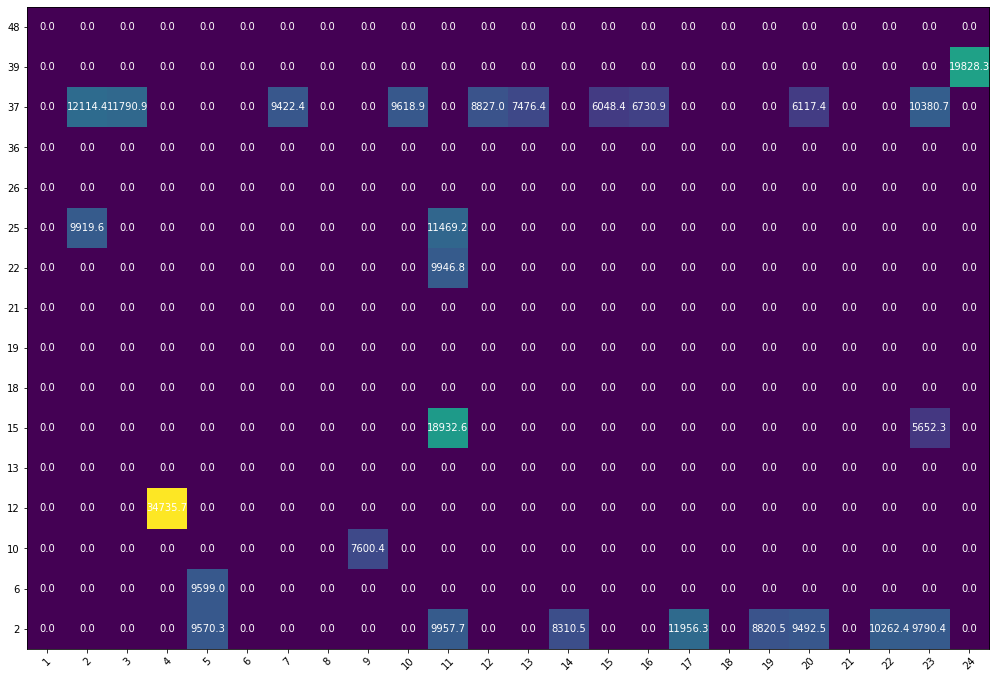

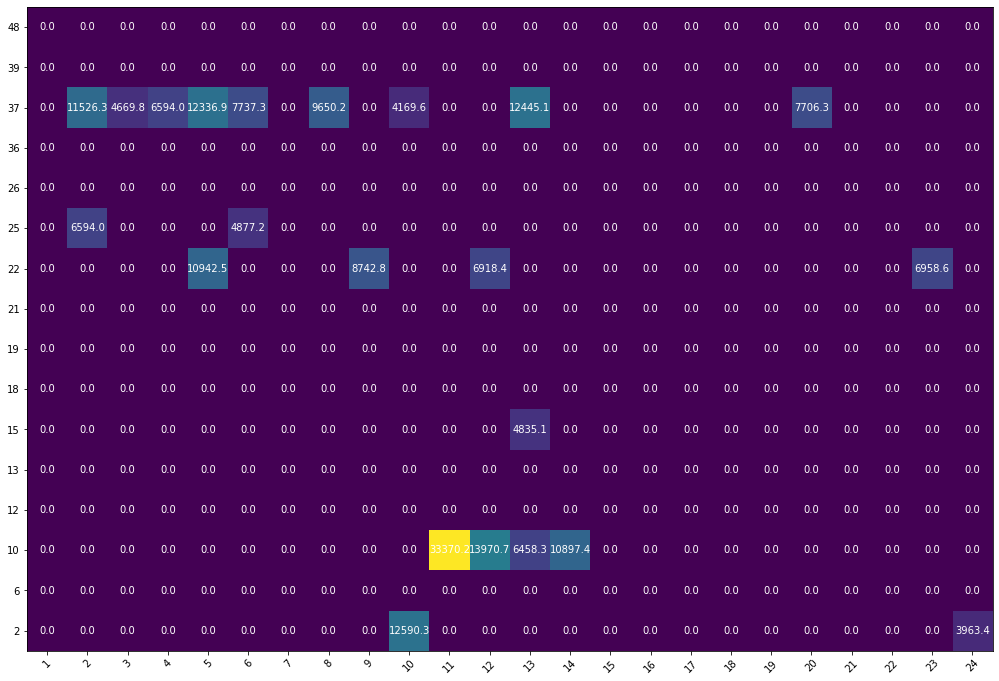

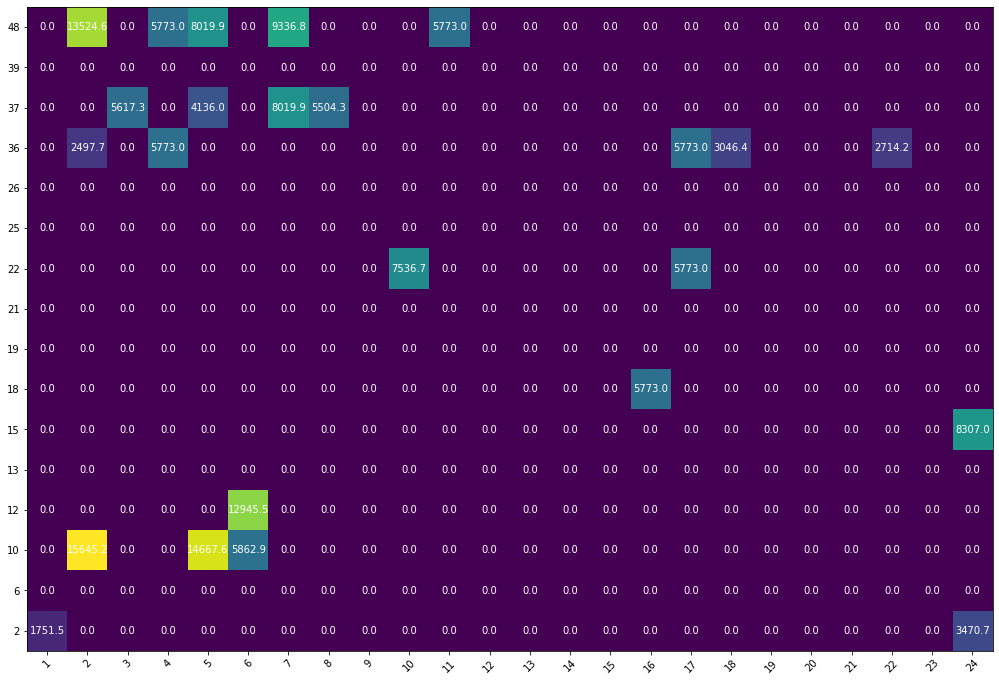

In [60]:
gp_name = 'zero_ndcgs'
chids = sample(cli_gps[gp_name], 3)
feat = 'txn_amt'
leg_only = True

for chid in chids:
    plot_feat_mat(chid, feat, leg_only)

### Property1 - Transaction Gap
#### Observation 
1. Worse groups seem to have relatively larger transaction time gaps, indicating relatively low frequentcy.

In [78]:
def plot_avg_txn_gap(leg_only, chid_gps):
    '''Plot average transactin gap of each client for each shop_tag.
    
    Parameters:
        leg_only: bool, whether to consider legitimate shop_tags only
        chid_gp: list, clids of the specified client group to observe
    '''
    if leg_only: 
        n_rows, n_cols, figsize = 4, 4, (24, 24)
        shop_tags = LEG_SHOP_TAG_MAP
    else: 
        n_rows, n_cols, figsize = 10, 5, (24, 60)
        shop_tags = SHOP_TAGS_
        
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    for shop_tag, i in tqdm(shop_tags.items()):
        txn_gaps = []
        for chid_gp_name, chid_gp in chid_gps.items():
            for chid in chid_gp:
                txn_gap_vec = txn_gap_vecs[int(chid-1e7)]
                txn_gap = txn_gap_vec[idx]
                if txn_gap != 100:
                    # If client hasn't made a transaction or only made once
                    txn_gaps.append(txn_gap)
            axs[i//n_cols, i%n_cols].hist(x=np.array(txn_gaps), bins=24, alpha=0.3, density=True,
                                          label=chid_gp_name)
        axs[i//n_cols, i%n_cols].set_title(f"shop_tag {shop_tag}, #Total Clients {len(txn_gaps)}")
        axs[i//n_cols, i%n_cols].set_xlabel(f"Average Transaction Gap")
        axs[i//n_cols, i%n_cols].set_ylabel("#Clients")
        axs[i//n_cols, i%n_cols].legend()
        del txn_gaps
    plt.tight_layout()

In [61]:
txn_gap_vecs = get_txn_related_feat(24, 'avg_gap', leg_only=True)   # Get average transaction time gaps

100%|██████████| 500000/500000 [00:24<00:00, 20427.59it/s]


In [62]:
# Compute cumsum of ratio
# 觀察各shop_tag購買頻率特性，有些近8成都在2以內，可以表示為高頻購買商品
# 可以輕易透過現在的horizon1模型捕捉；反利則為18, 19, 39這些，購買頻率相對較低
# 近五成都在3以上，建立horizon3模型嘗試捕桌
GAP_BREAK_PTS = [_ for _ in range(1, 11)]
txn_gap_vecs = np.array(list(txn_gap_vecs.values()))

chid_ratios = {}
for shop_tag, idx in LEG_SHOP_TAG_MAP.items():
    txn_gaps_shop_tag = txn_gap_vecs[:, idx]
    txn_gaps_shop_tag = txn_gaps_shop_tag[txn_gaps_shop_tag != 100]

    n_chids_binned = []
    for upper_bound in GAP_BREAK_PTS:
        gap_intv = ((txn_gaps_shop_tag >= upper_bound-1) & 
                    (txn_gaps_shop_tag < upper_bound))
        n_chids_intv = np.sum(np.where(gap_intv, True, False))
        n_chids_binned.append(n_chids_intv)
    n_chids_binned.append(len(txn_gaps_shop_tag) - np.sum(n_chids_binned))
    chid_ratios[shop_tag] = (np.cumsum(np.array(n_chids_binned) / 
                             np.sum(n_chids_binned)))

In [63]:
avg_gap_break_pts = [3, 4]
wts = {}
for shop_tag in LEG_SHOP_TAGS:
    wt_vec = [0]
    chid_ratios_shop_tag = chid_ratios[shop_tag]
    for avg_gap_bpt in avg_gap_break_pts:
        wt_vec.append(chid_ratios_shop_tag[avg_gap_bpt-1])
    wt_vec.append(1)
    wt_vec = np.diff(np.array(wt_vec))
    print(shop_tag, wt_vec)
    wts[shop_tag] = wt_vec

2 [0.70928717 0.08299803 0.20771479]
6 [0.58351442 0.08962158 0.32686399]
10 [0.8328516  0.05054058 0.11660782]
12 [0.72807906 0.06213414 0.2097868 ]
13 [0.90870569 0.03193397 0.05936034]
15 [0.75876034 0.06963609 0.17160357]
18 [0.57194783 0.10490787 0.32314429]
19 [0.55803922 0.11491444 0.32704634]
21 [0.50712745 0.11686354 0.37600901]
22 [0.60728138 0.10351804 0.28920058]
25 [0.6141034  0.1030716  0.28282501]
26 [0.5994967  0.09380512 0.30669818]
36 [0.87485695 0.03712375 0.08801929]
37 [0.84794842 0.04776631 0.10428527]
39 [0.49608516 0.12634658 0.37756826]
48 [0.73659692 0.0716844  0.19171867]


16it [00:00, 272.60it/s]


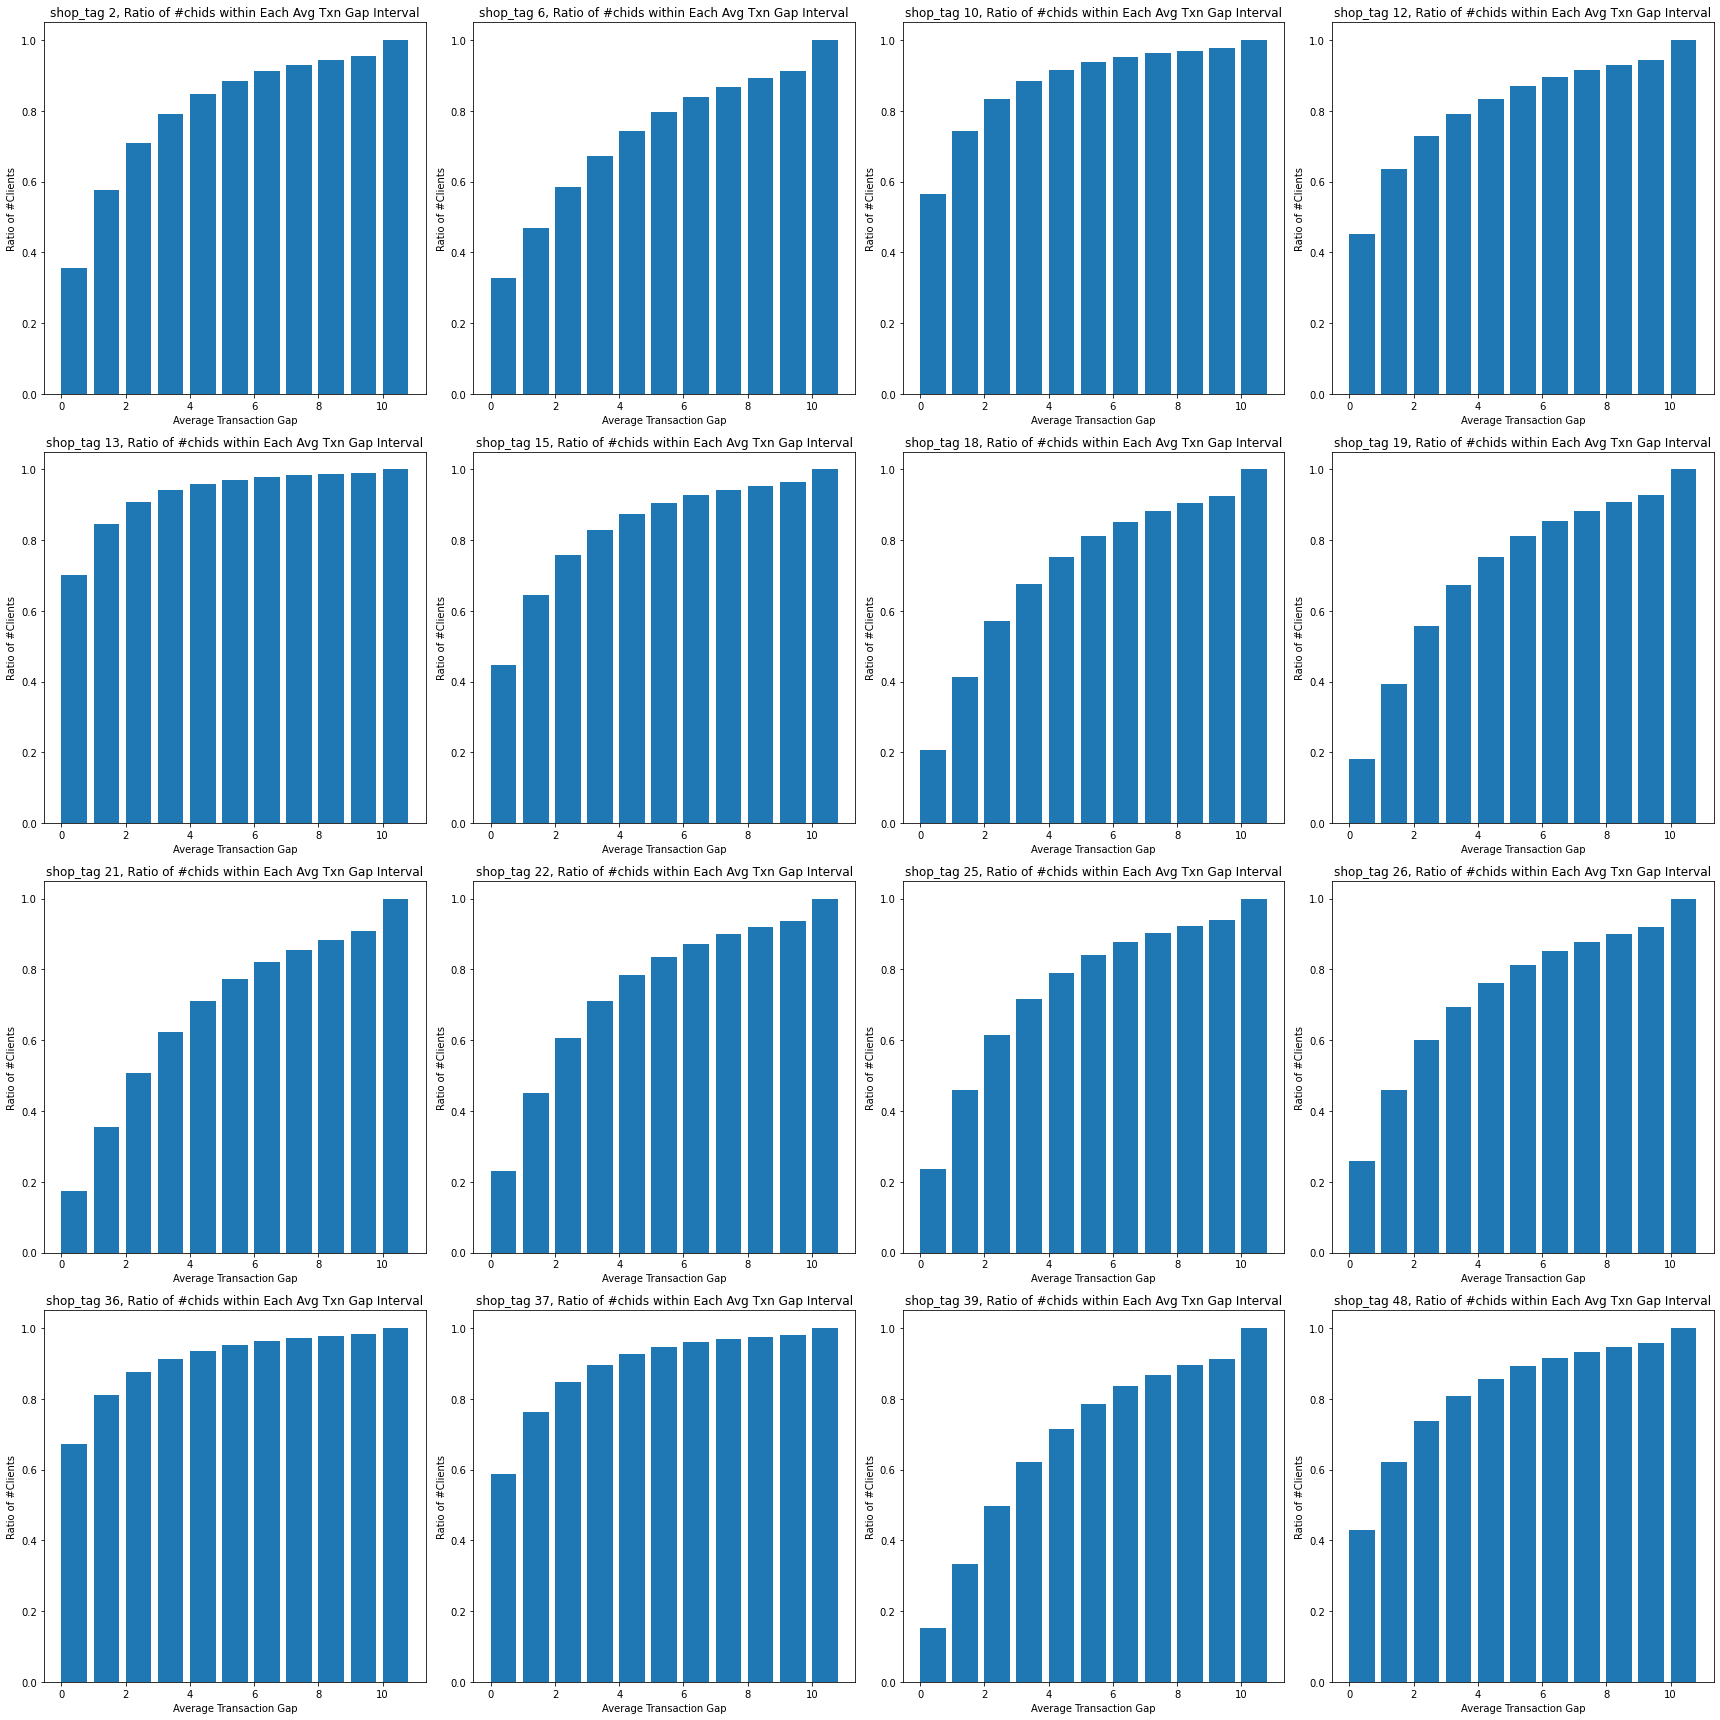

In [64]:
n_cols=4
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(24, 24))
for i, (shop_tag, n_chids_binned) in tqdm(enumerate(chid_ratios.items())):
    axs[i//n_cols, i%n_cols].bar(x=[i for i in range(0, 11)], height=n_chids_binned, align='edge')
    axs[i//n_cols, i%n_cols].set_title(f"shop_tag {shop_tag}, Ratio of #chids within Each Avg Txn Gap Interval")
    axs[i//n_cols, i%n_cols].set_xlabel(f"Average Transaction Gap")
    axs[i//n_cols, i%n_cols].set_ylabel("Ratio of #Clients")
plt.tight_layout()

100%|██████████| 16/16 [00:03<00:00,  4.89it/s]


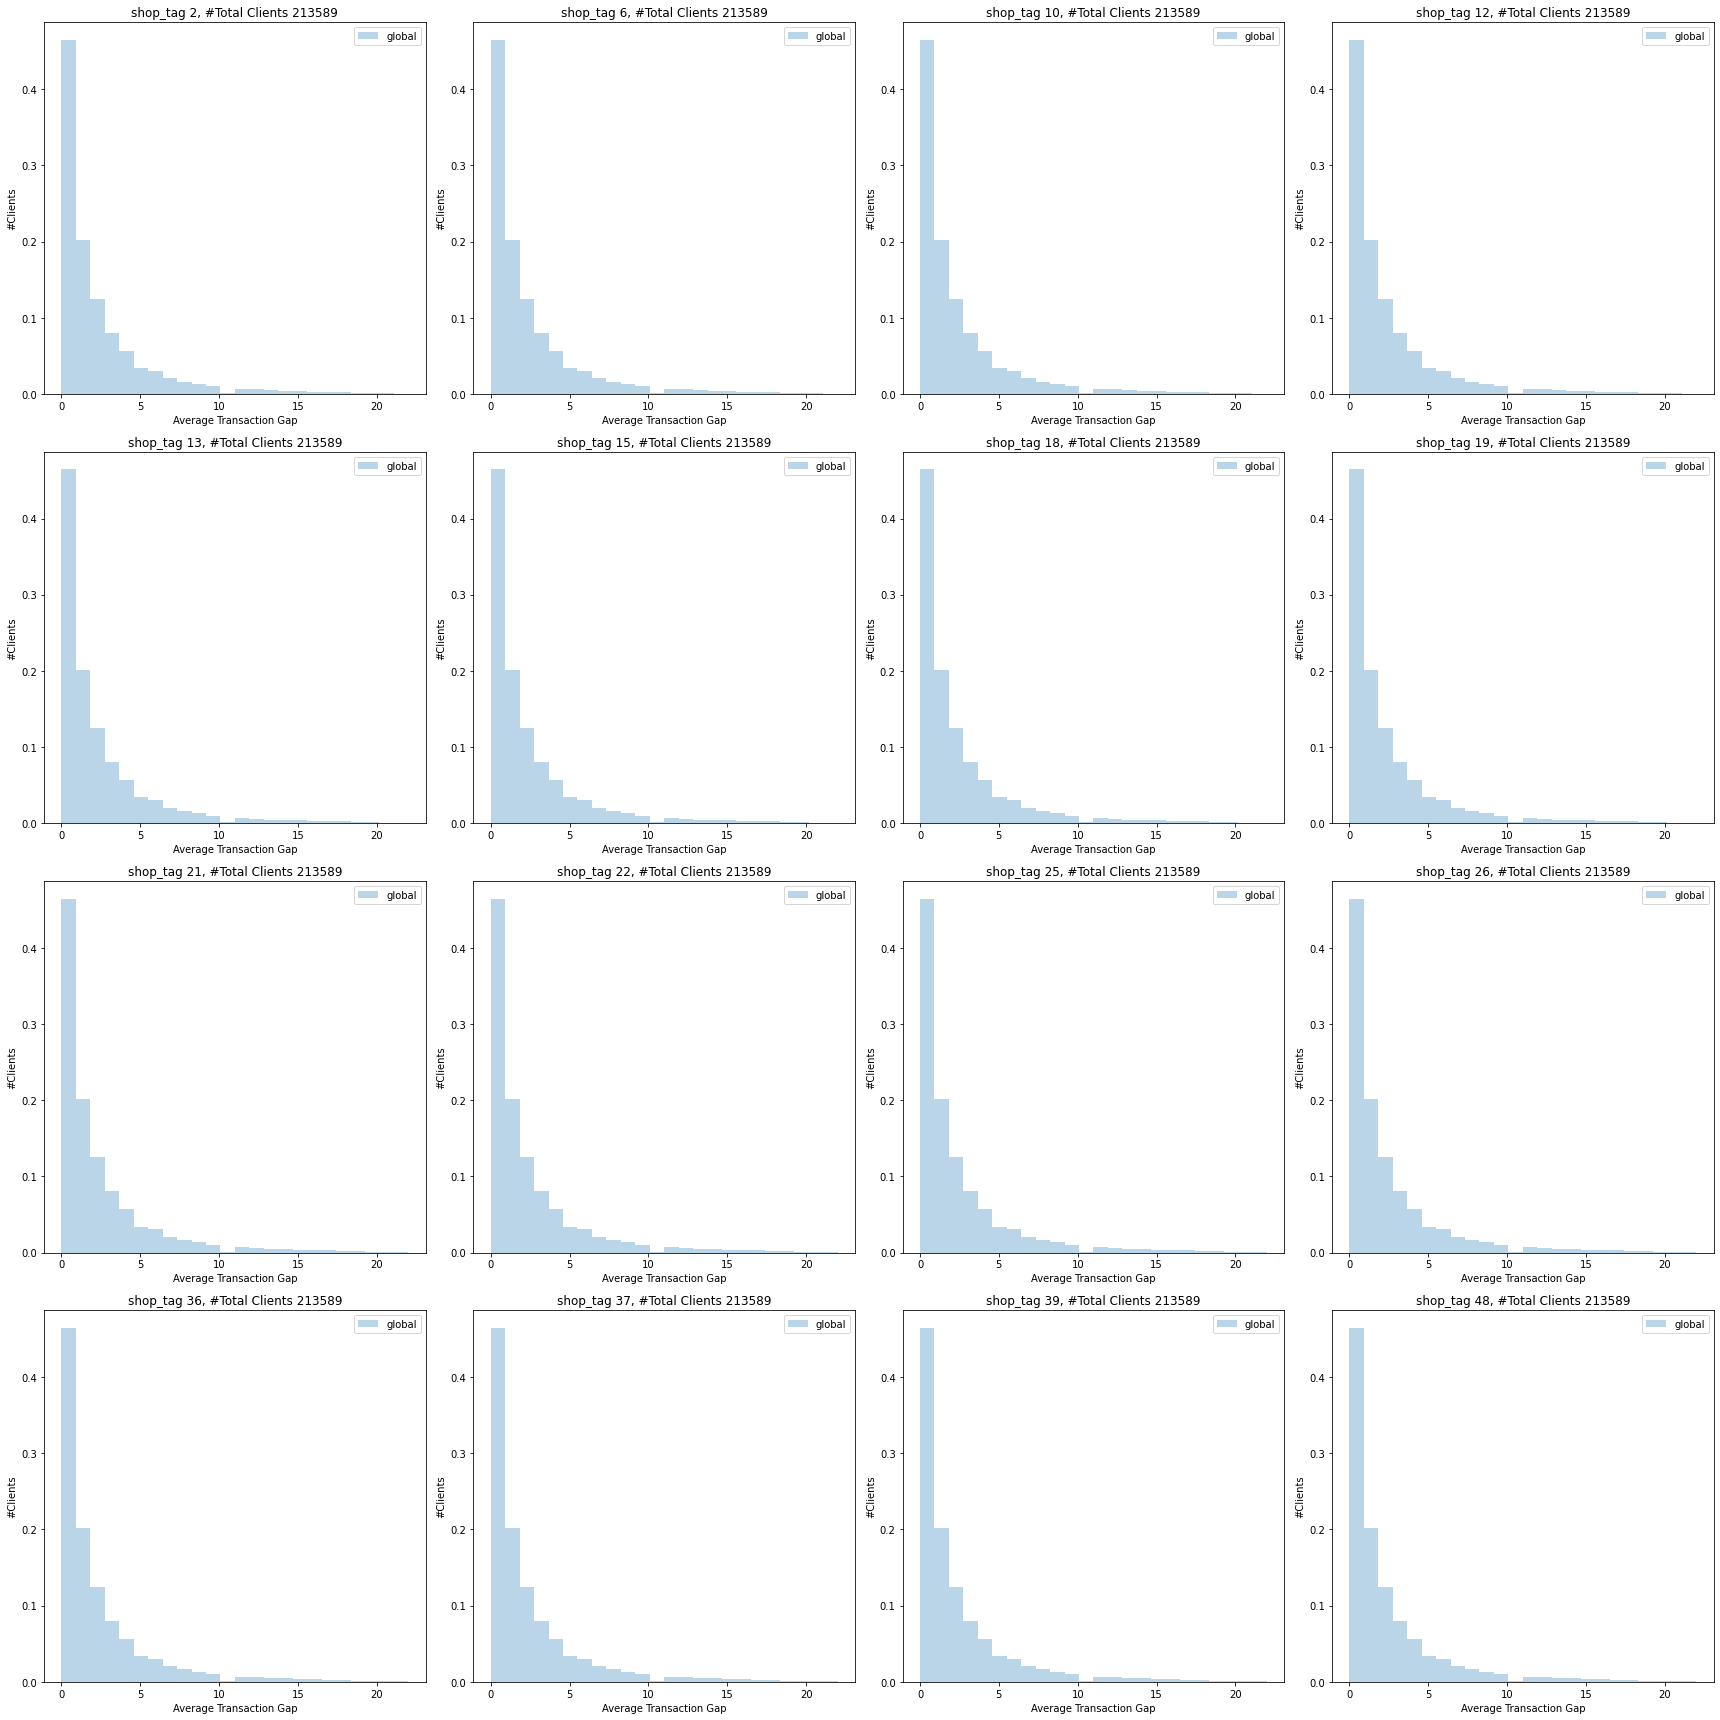

In [76]:
plot_avg_txn_gap(leg_only=True, chid_gps={'global': [int(chid+1e7) for chid in range(0, N_CLIENTS)]})

100%|██████████| 16/16 [00:05<00:00,  2.95it/s]


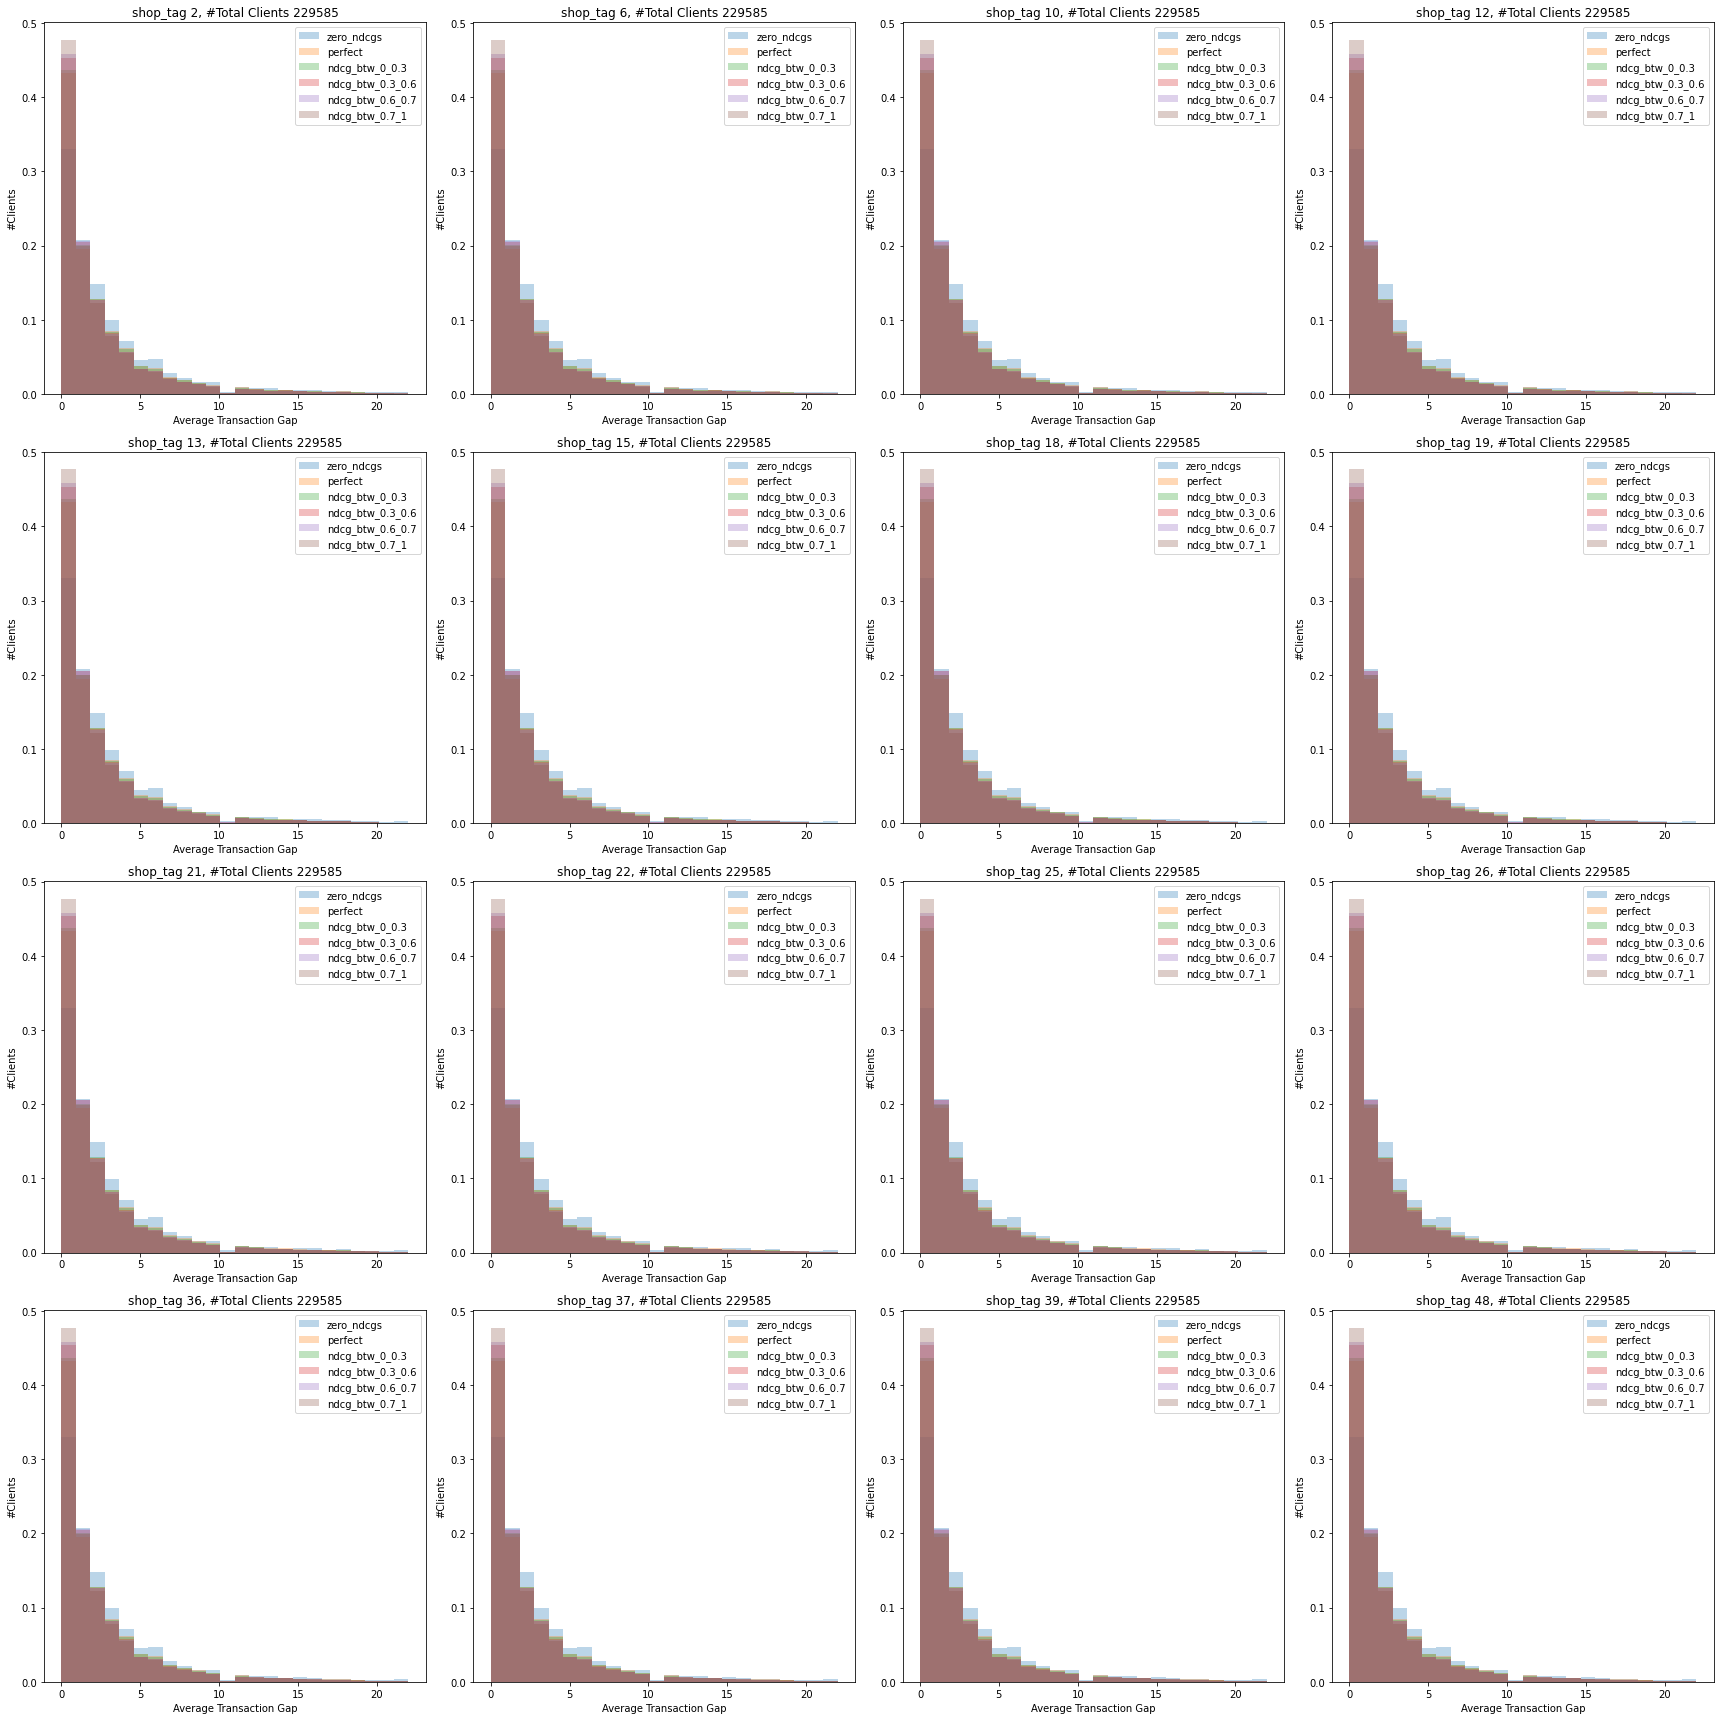

In [75]:
# For all shop_tags
plot_avg_txn_gap(leg_only=True, chid_gps=cli_gps)

### Property2 - Categorical Distribution
#### Observation
1. Different performance groups have different distributions in some of client attributes (*e.g.*, age category 3 in attribute `age`).
<div class="alert alert-block alert-warning">Think if there's a chance to separate models trained with samples having specific client attributes.</div> 

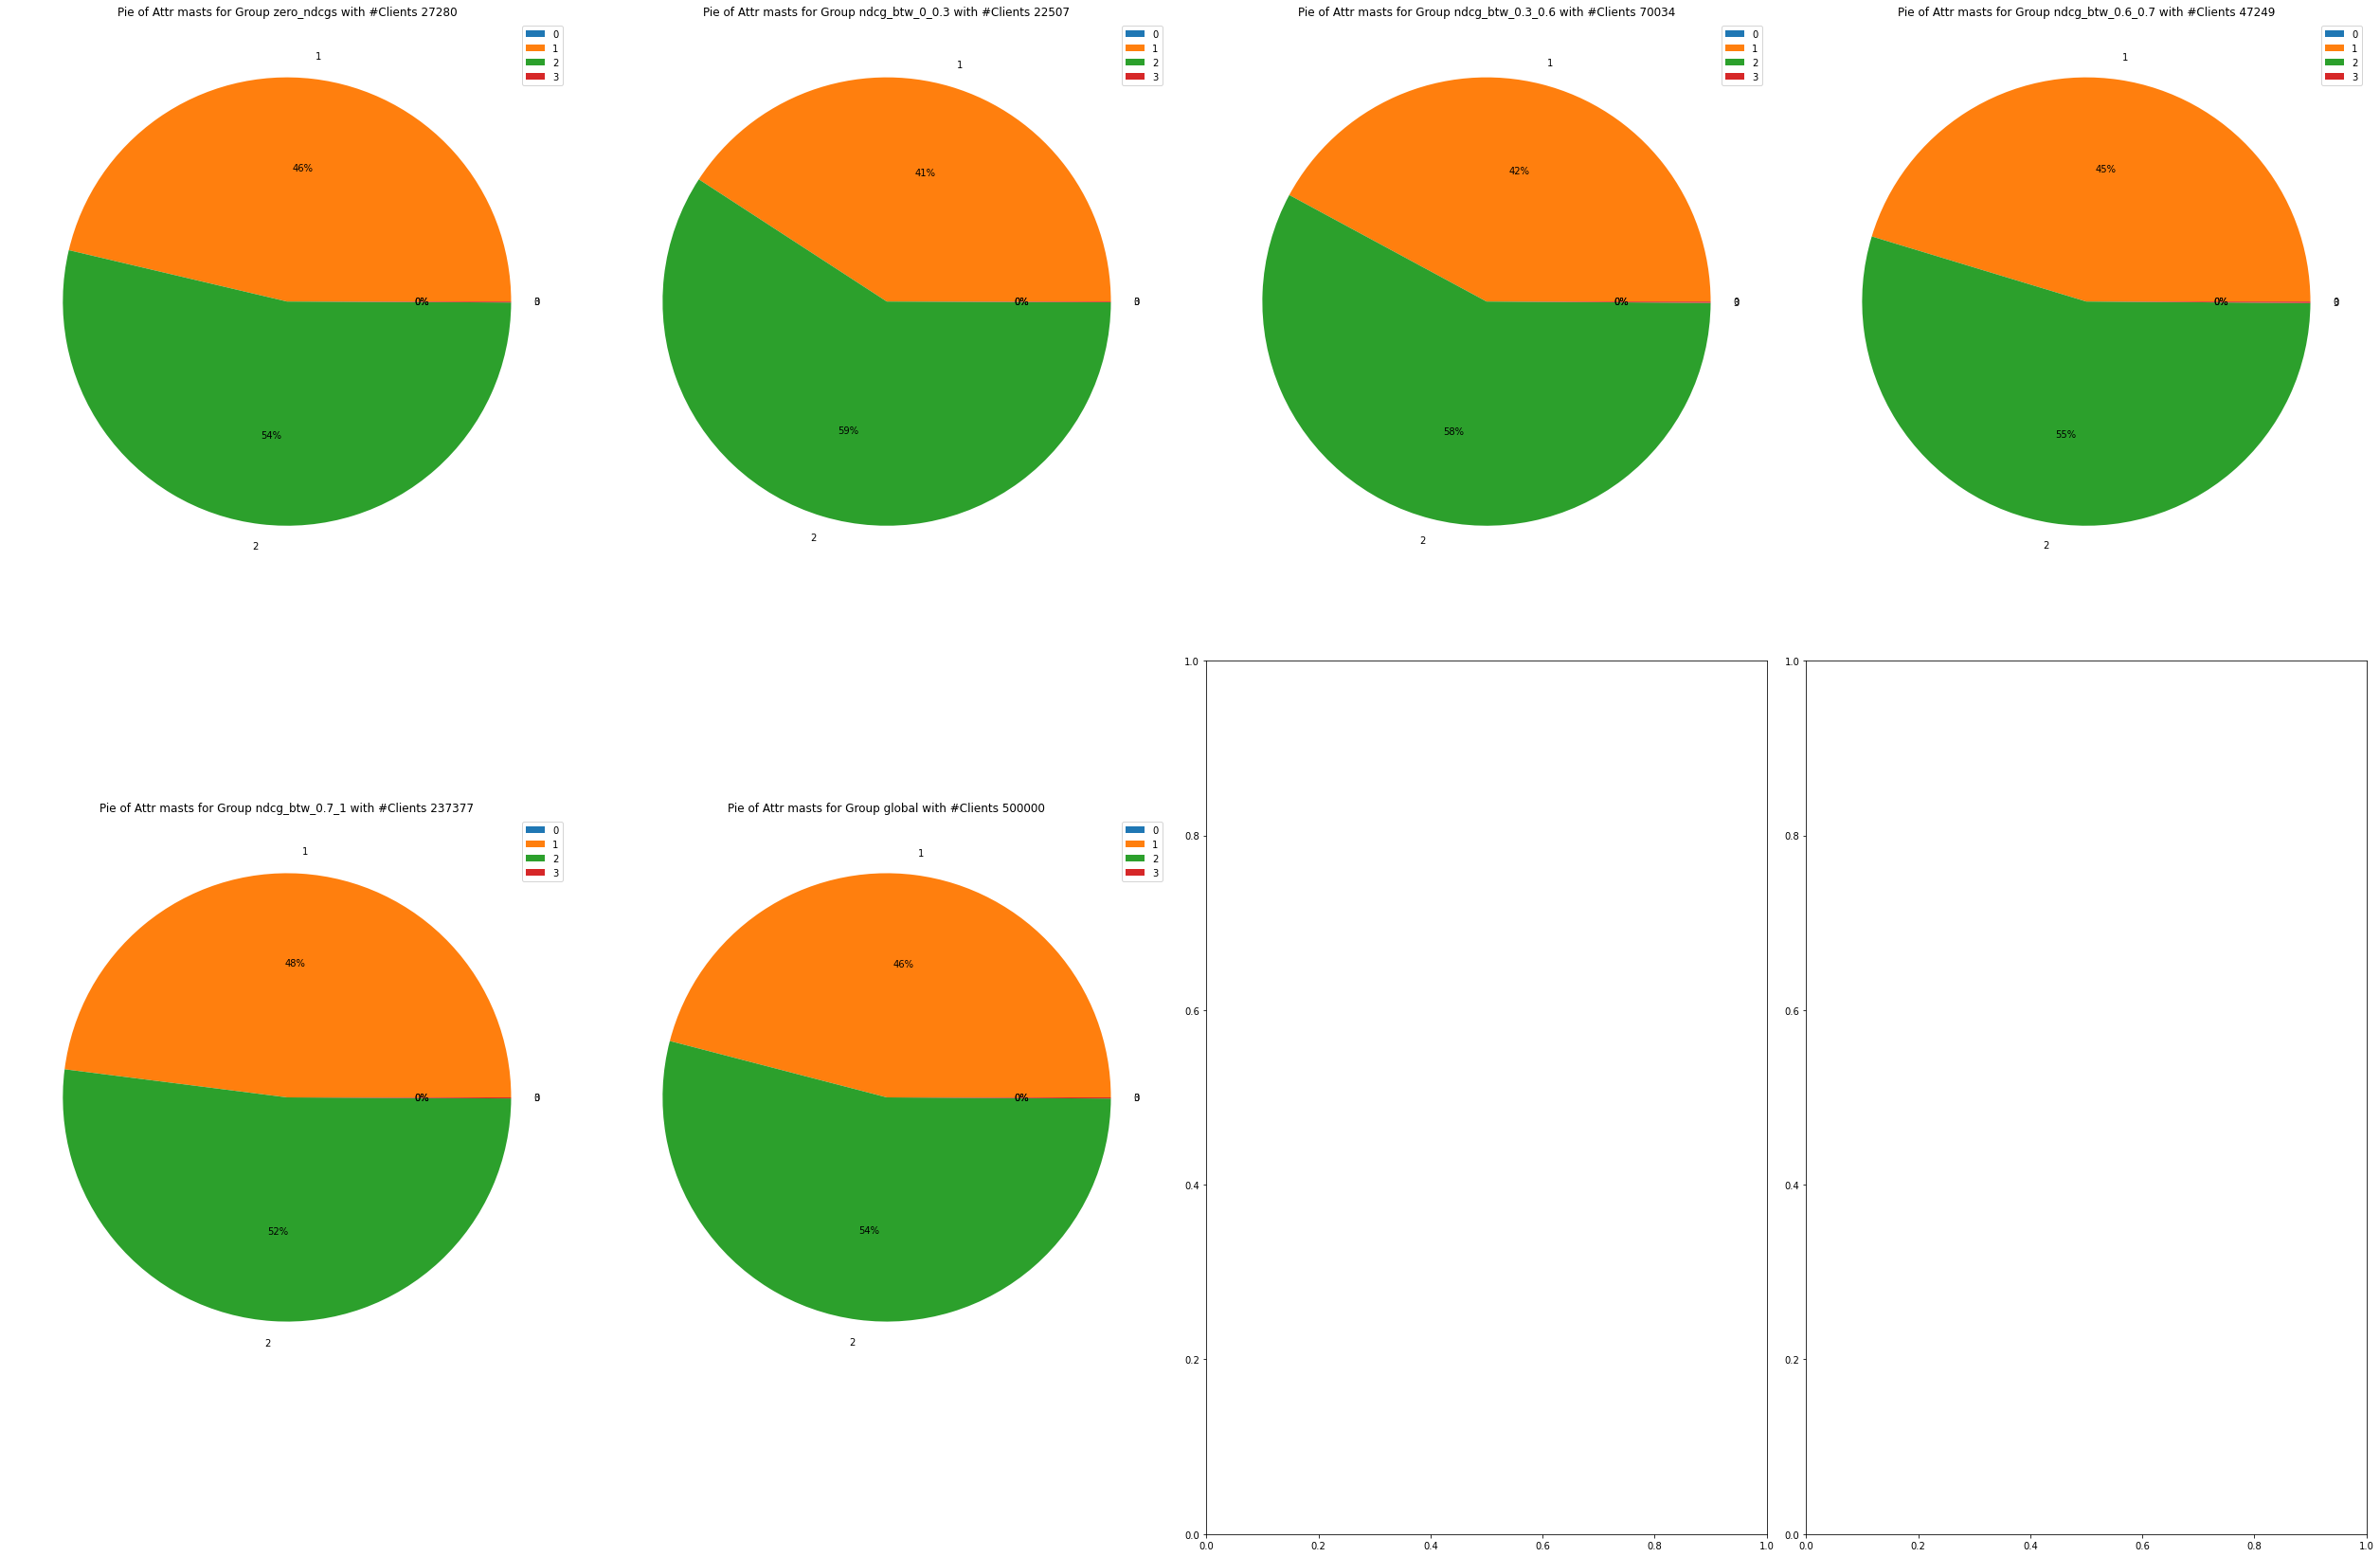

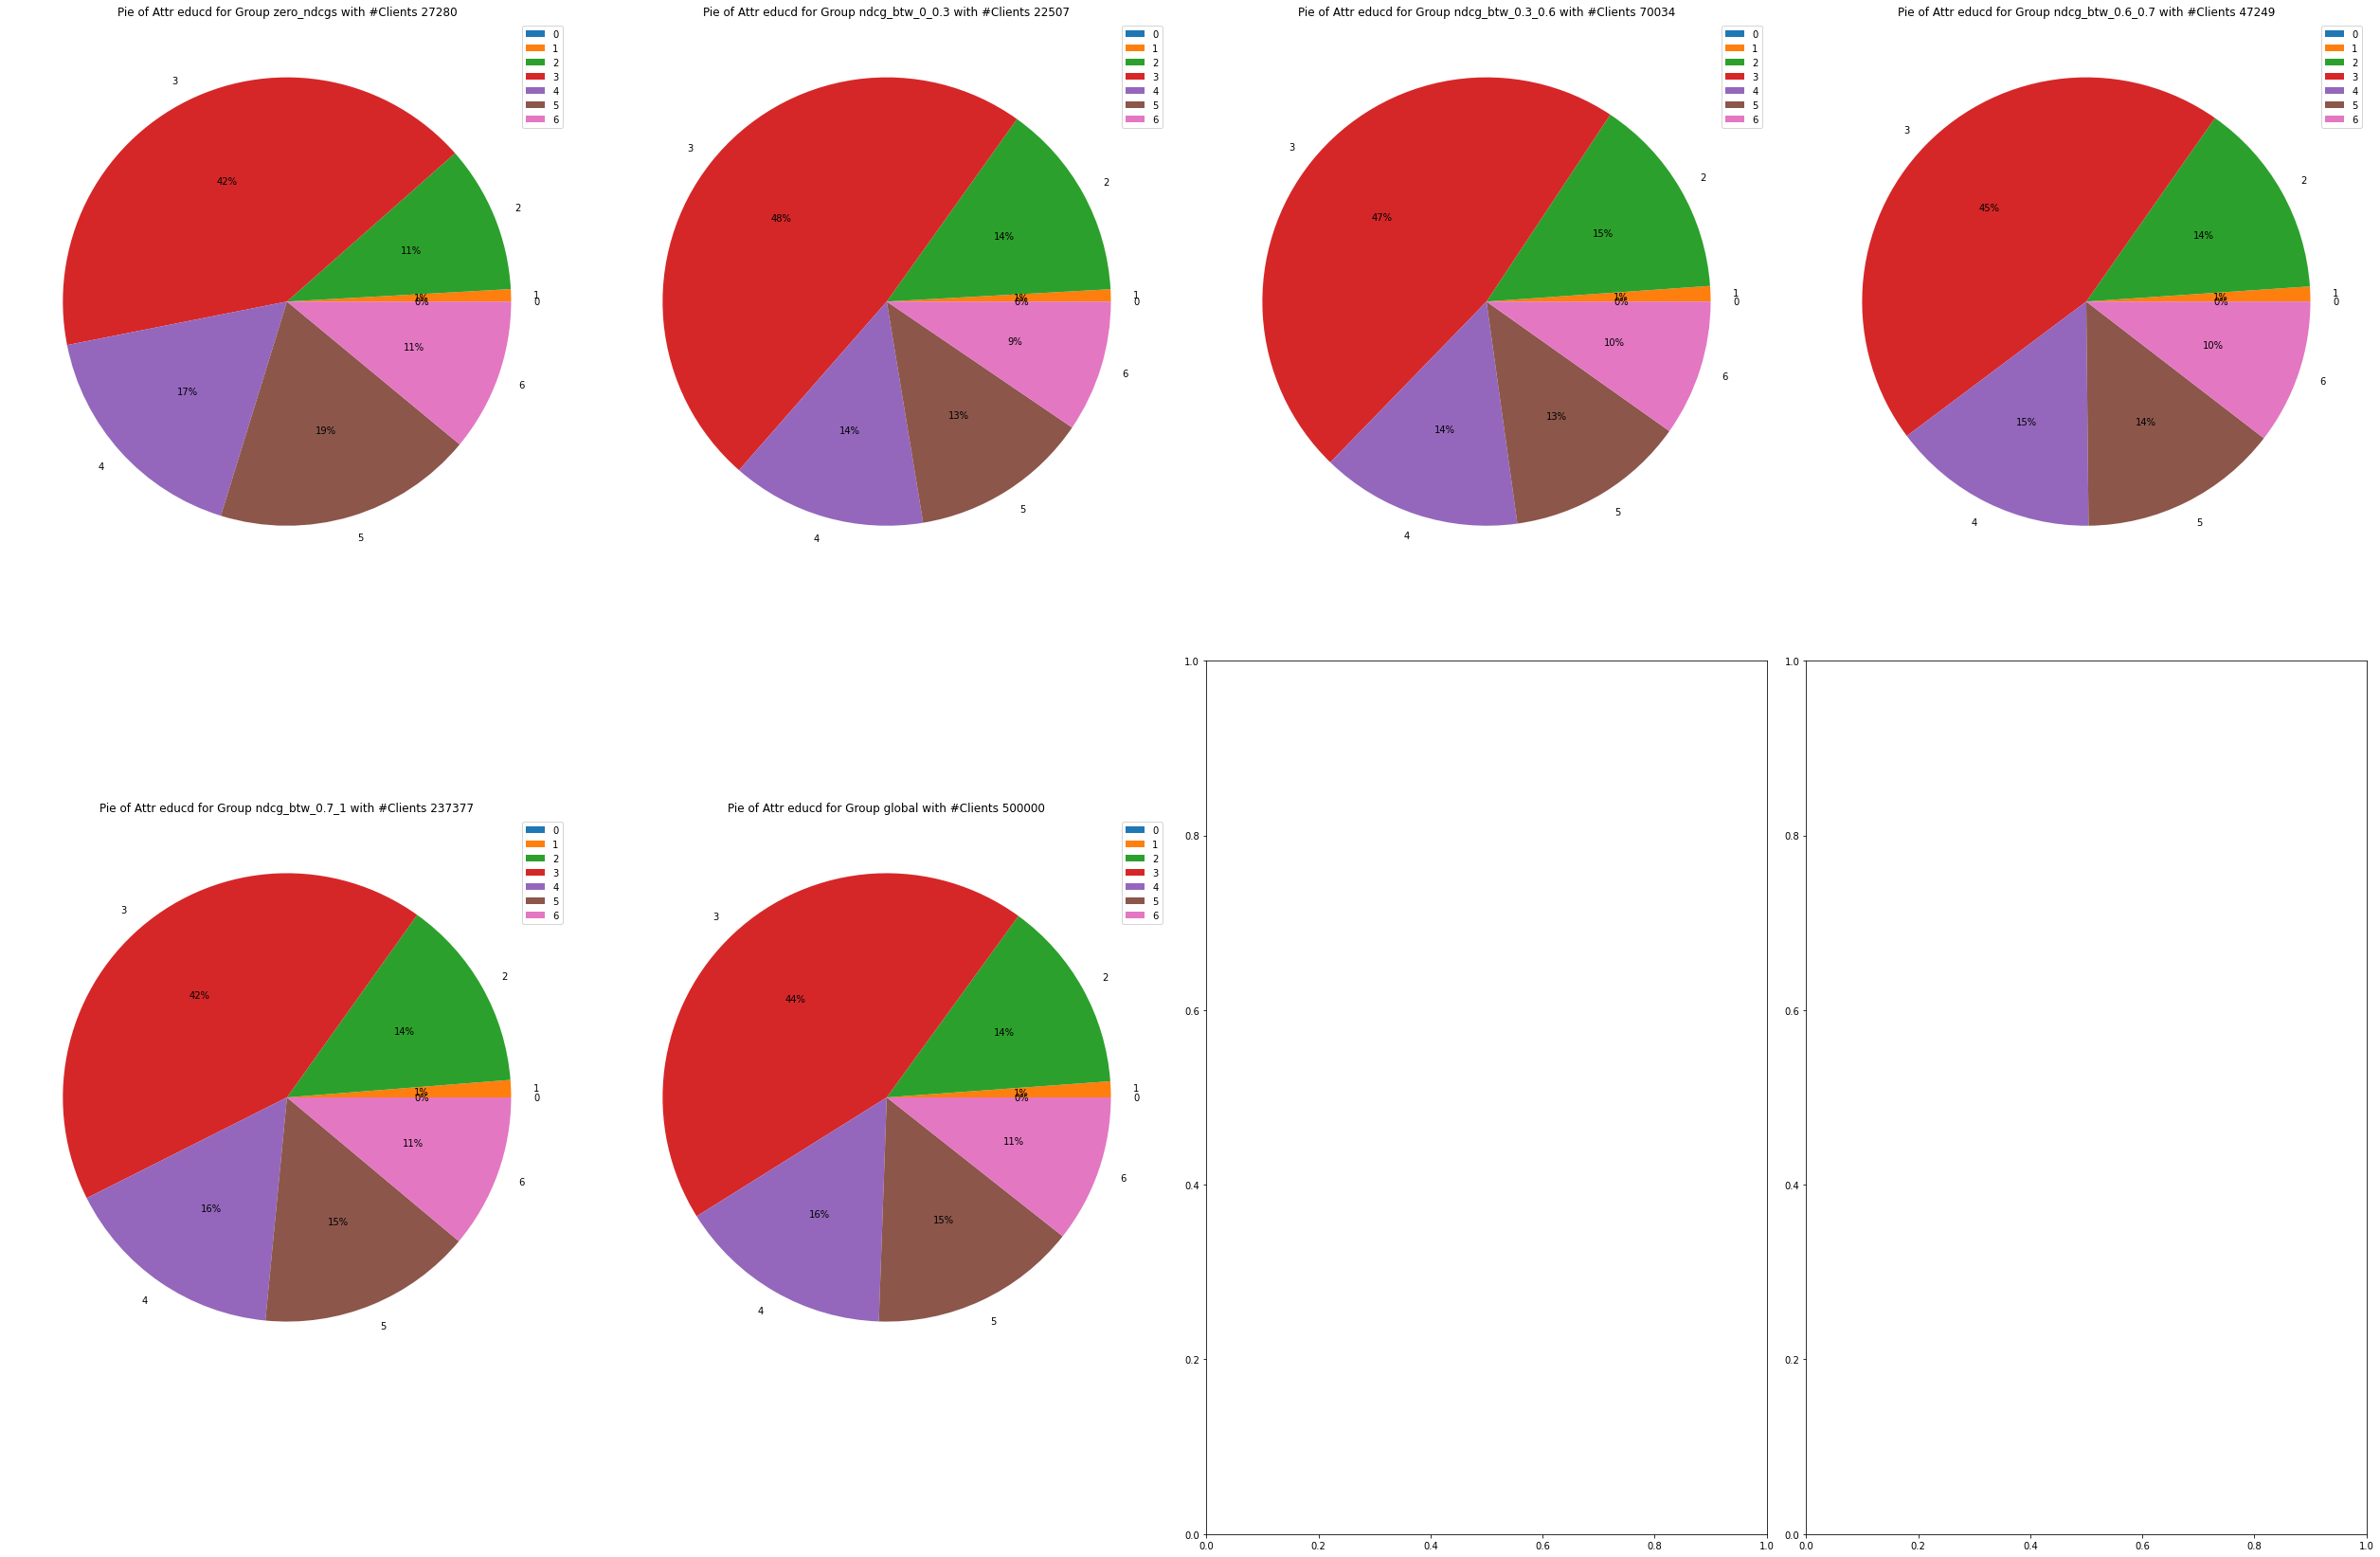

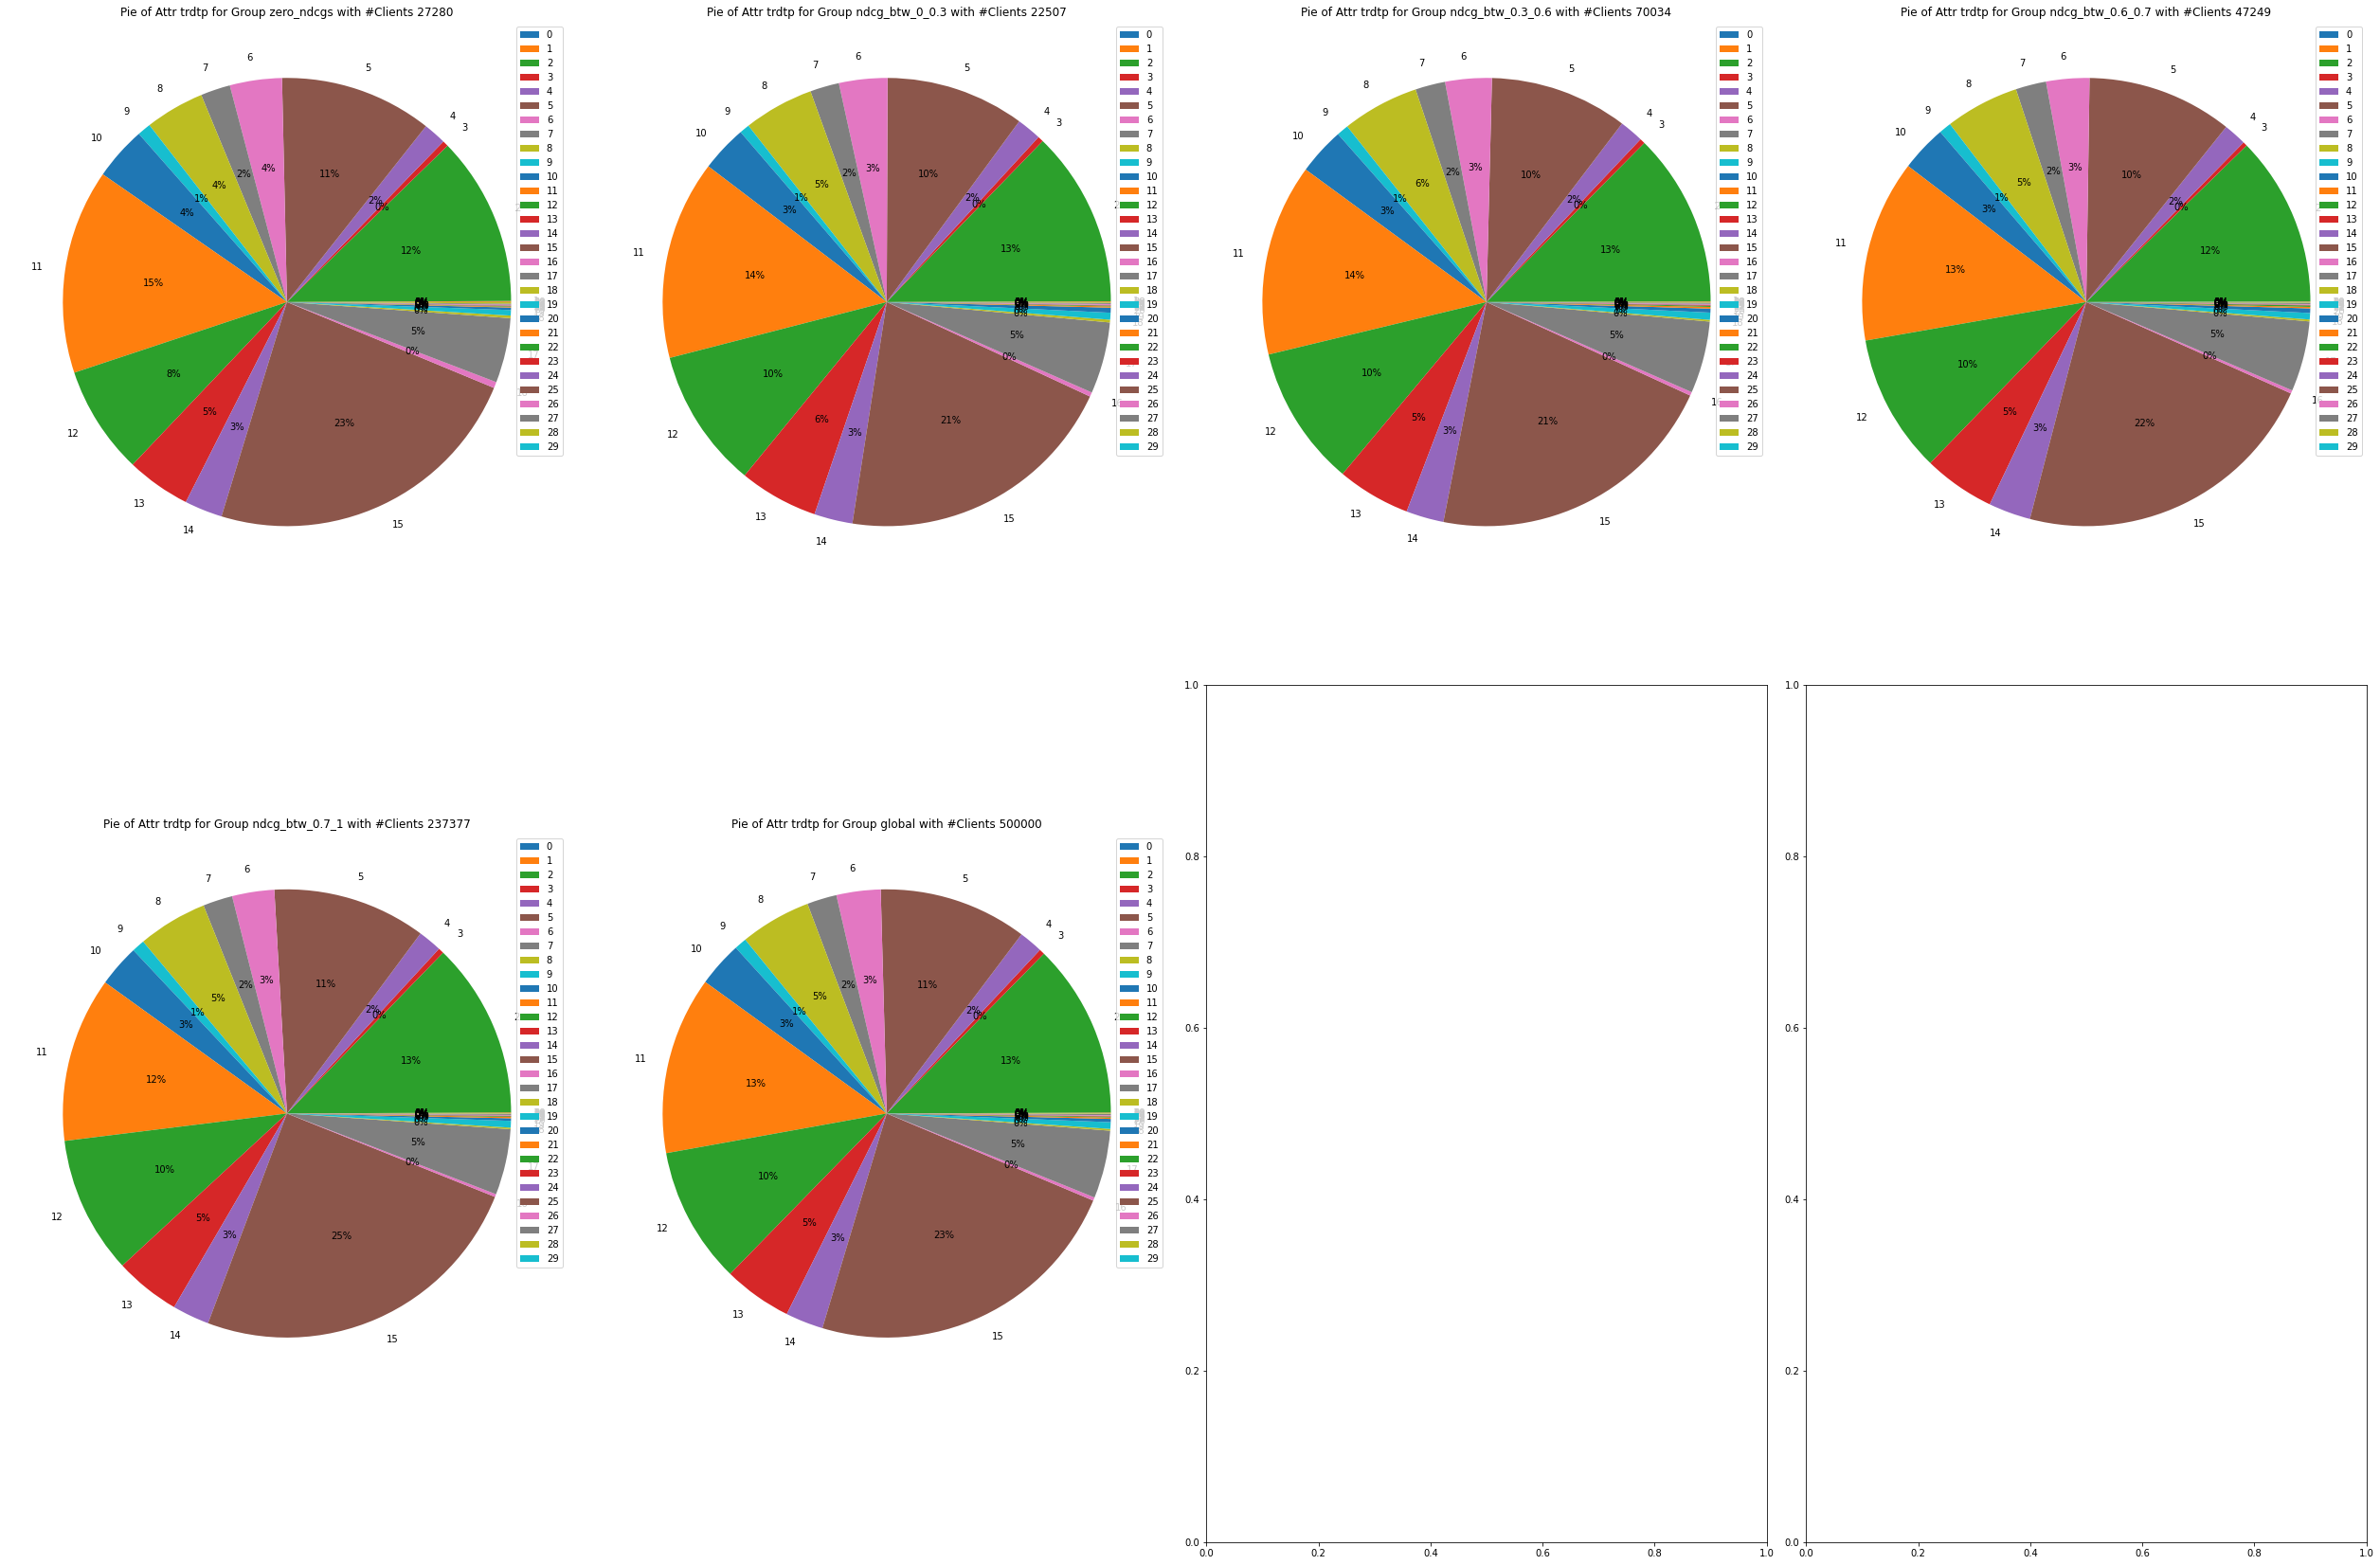

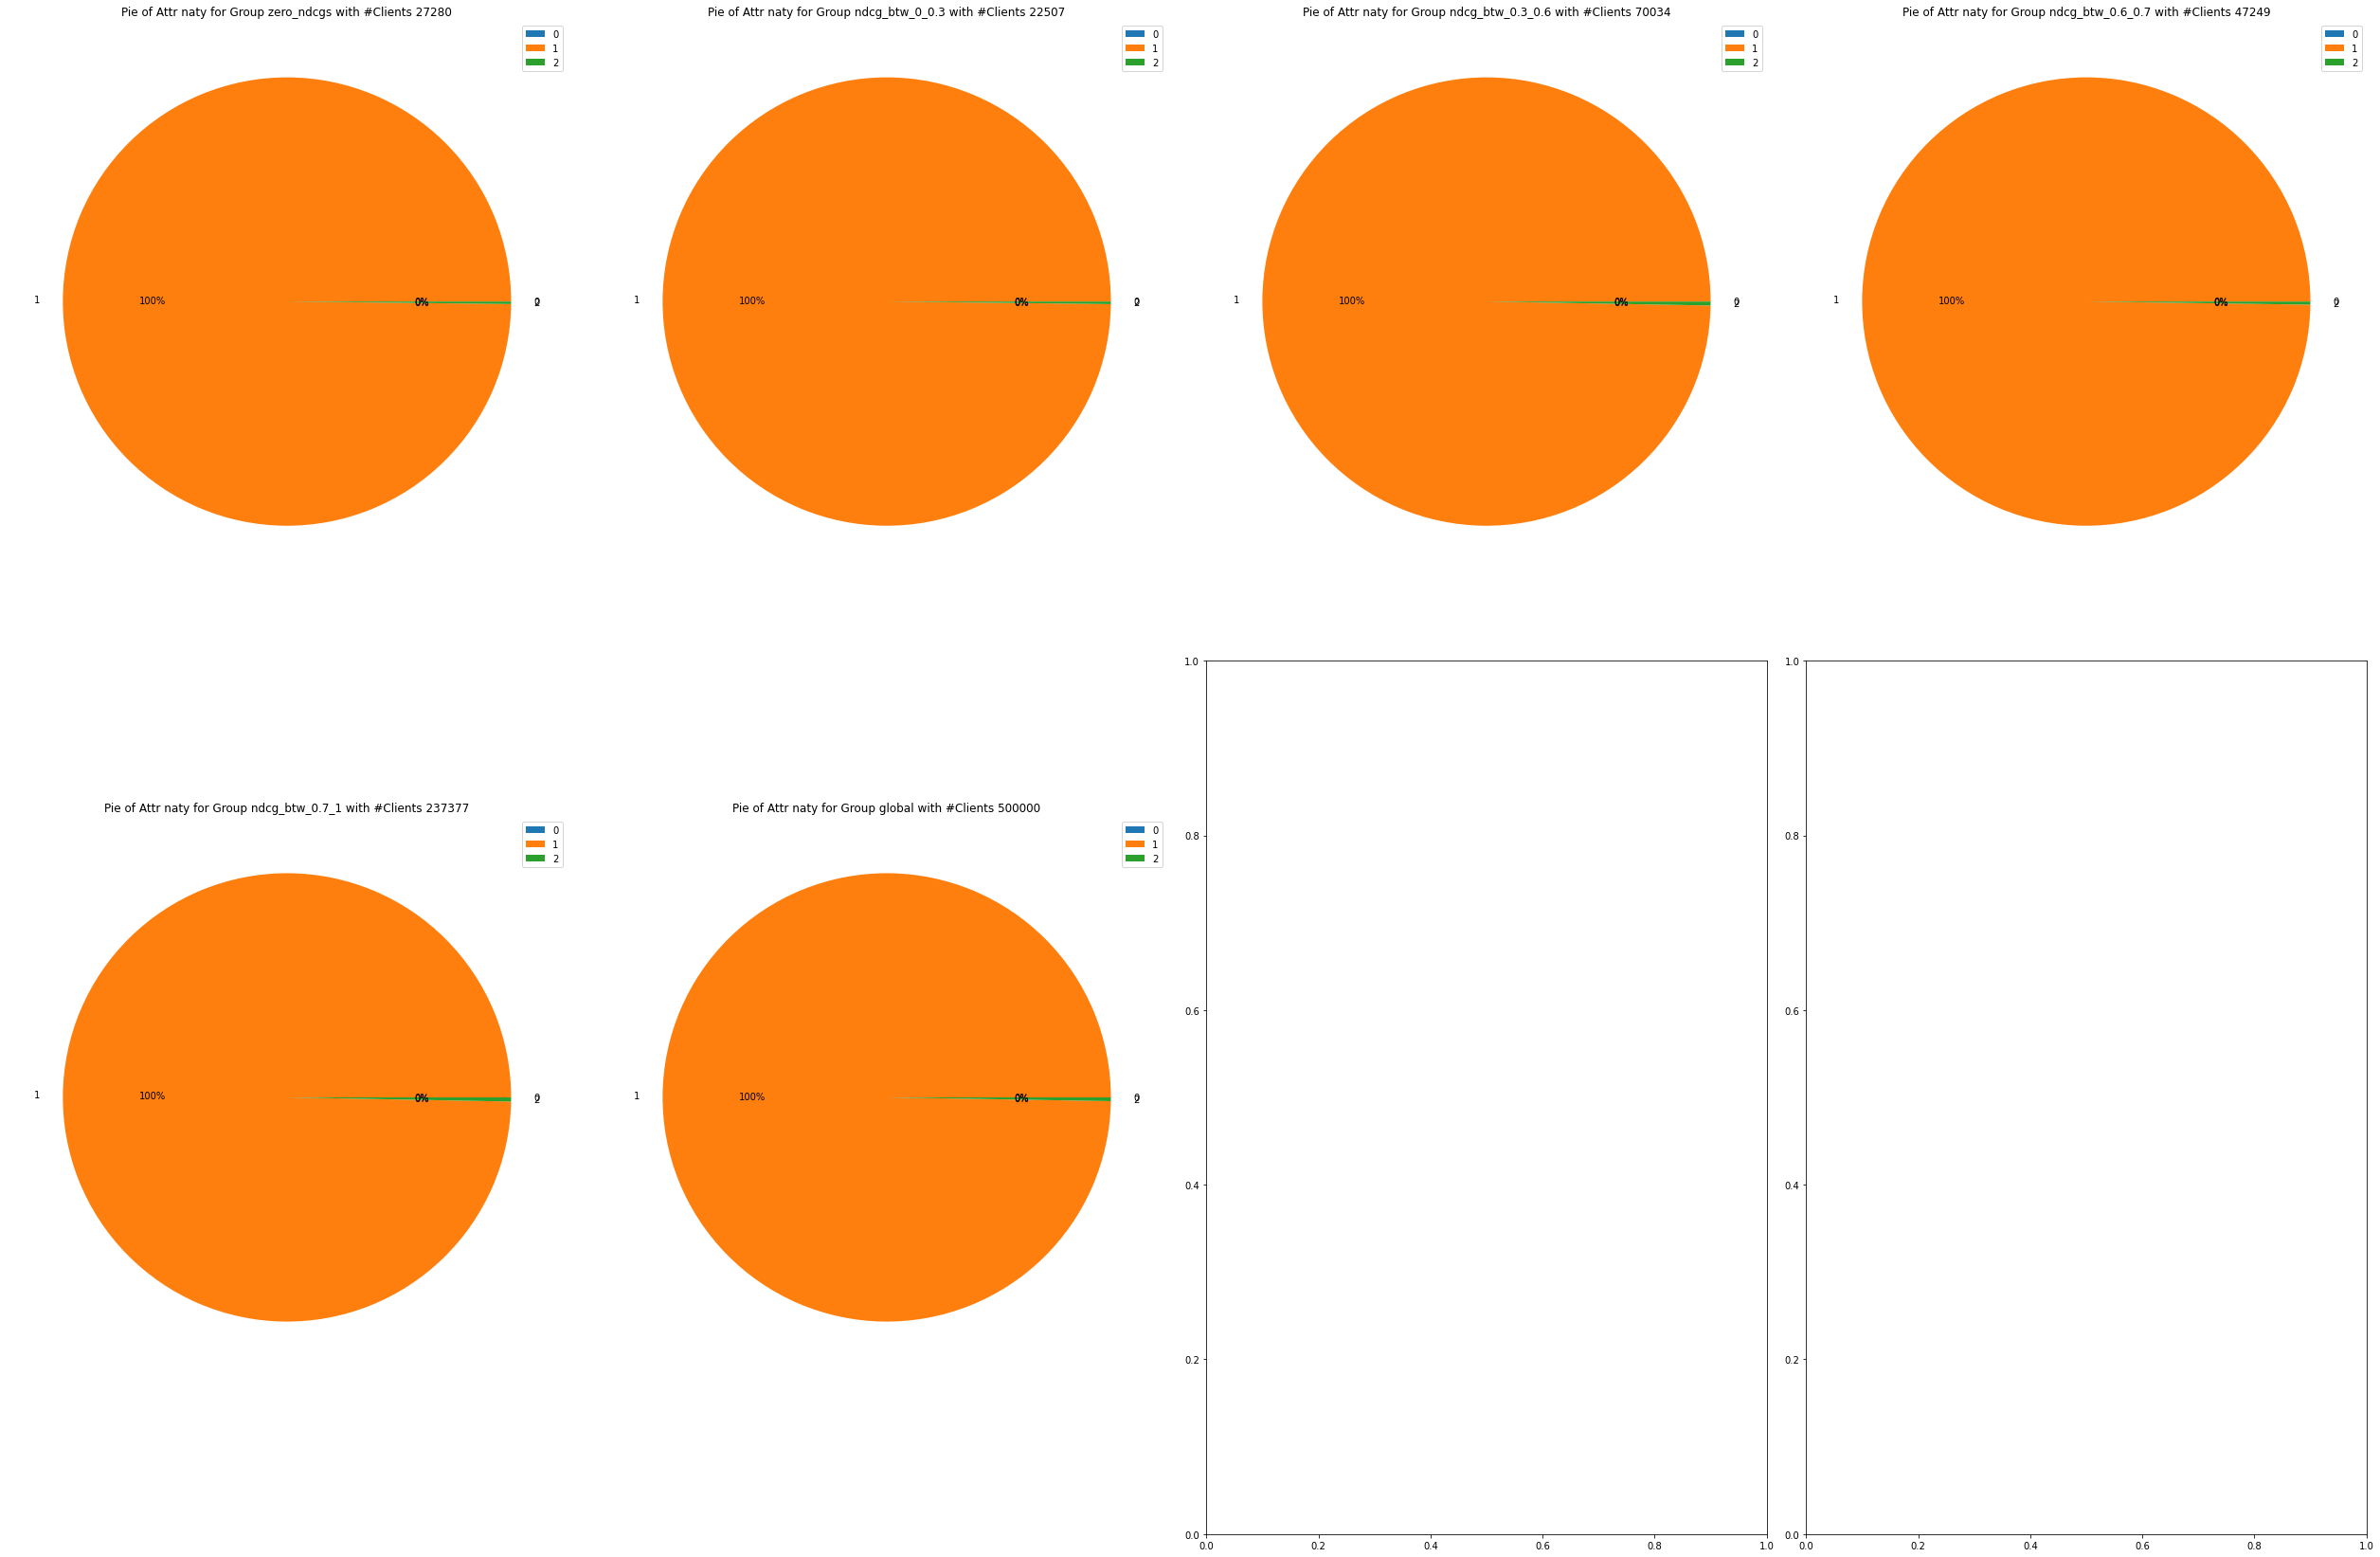

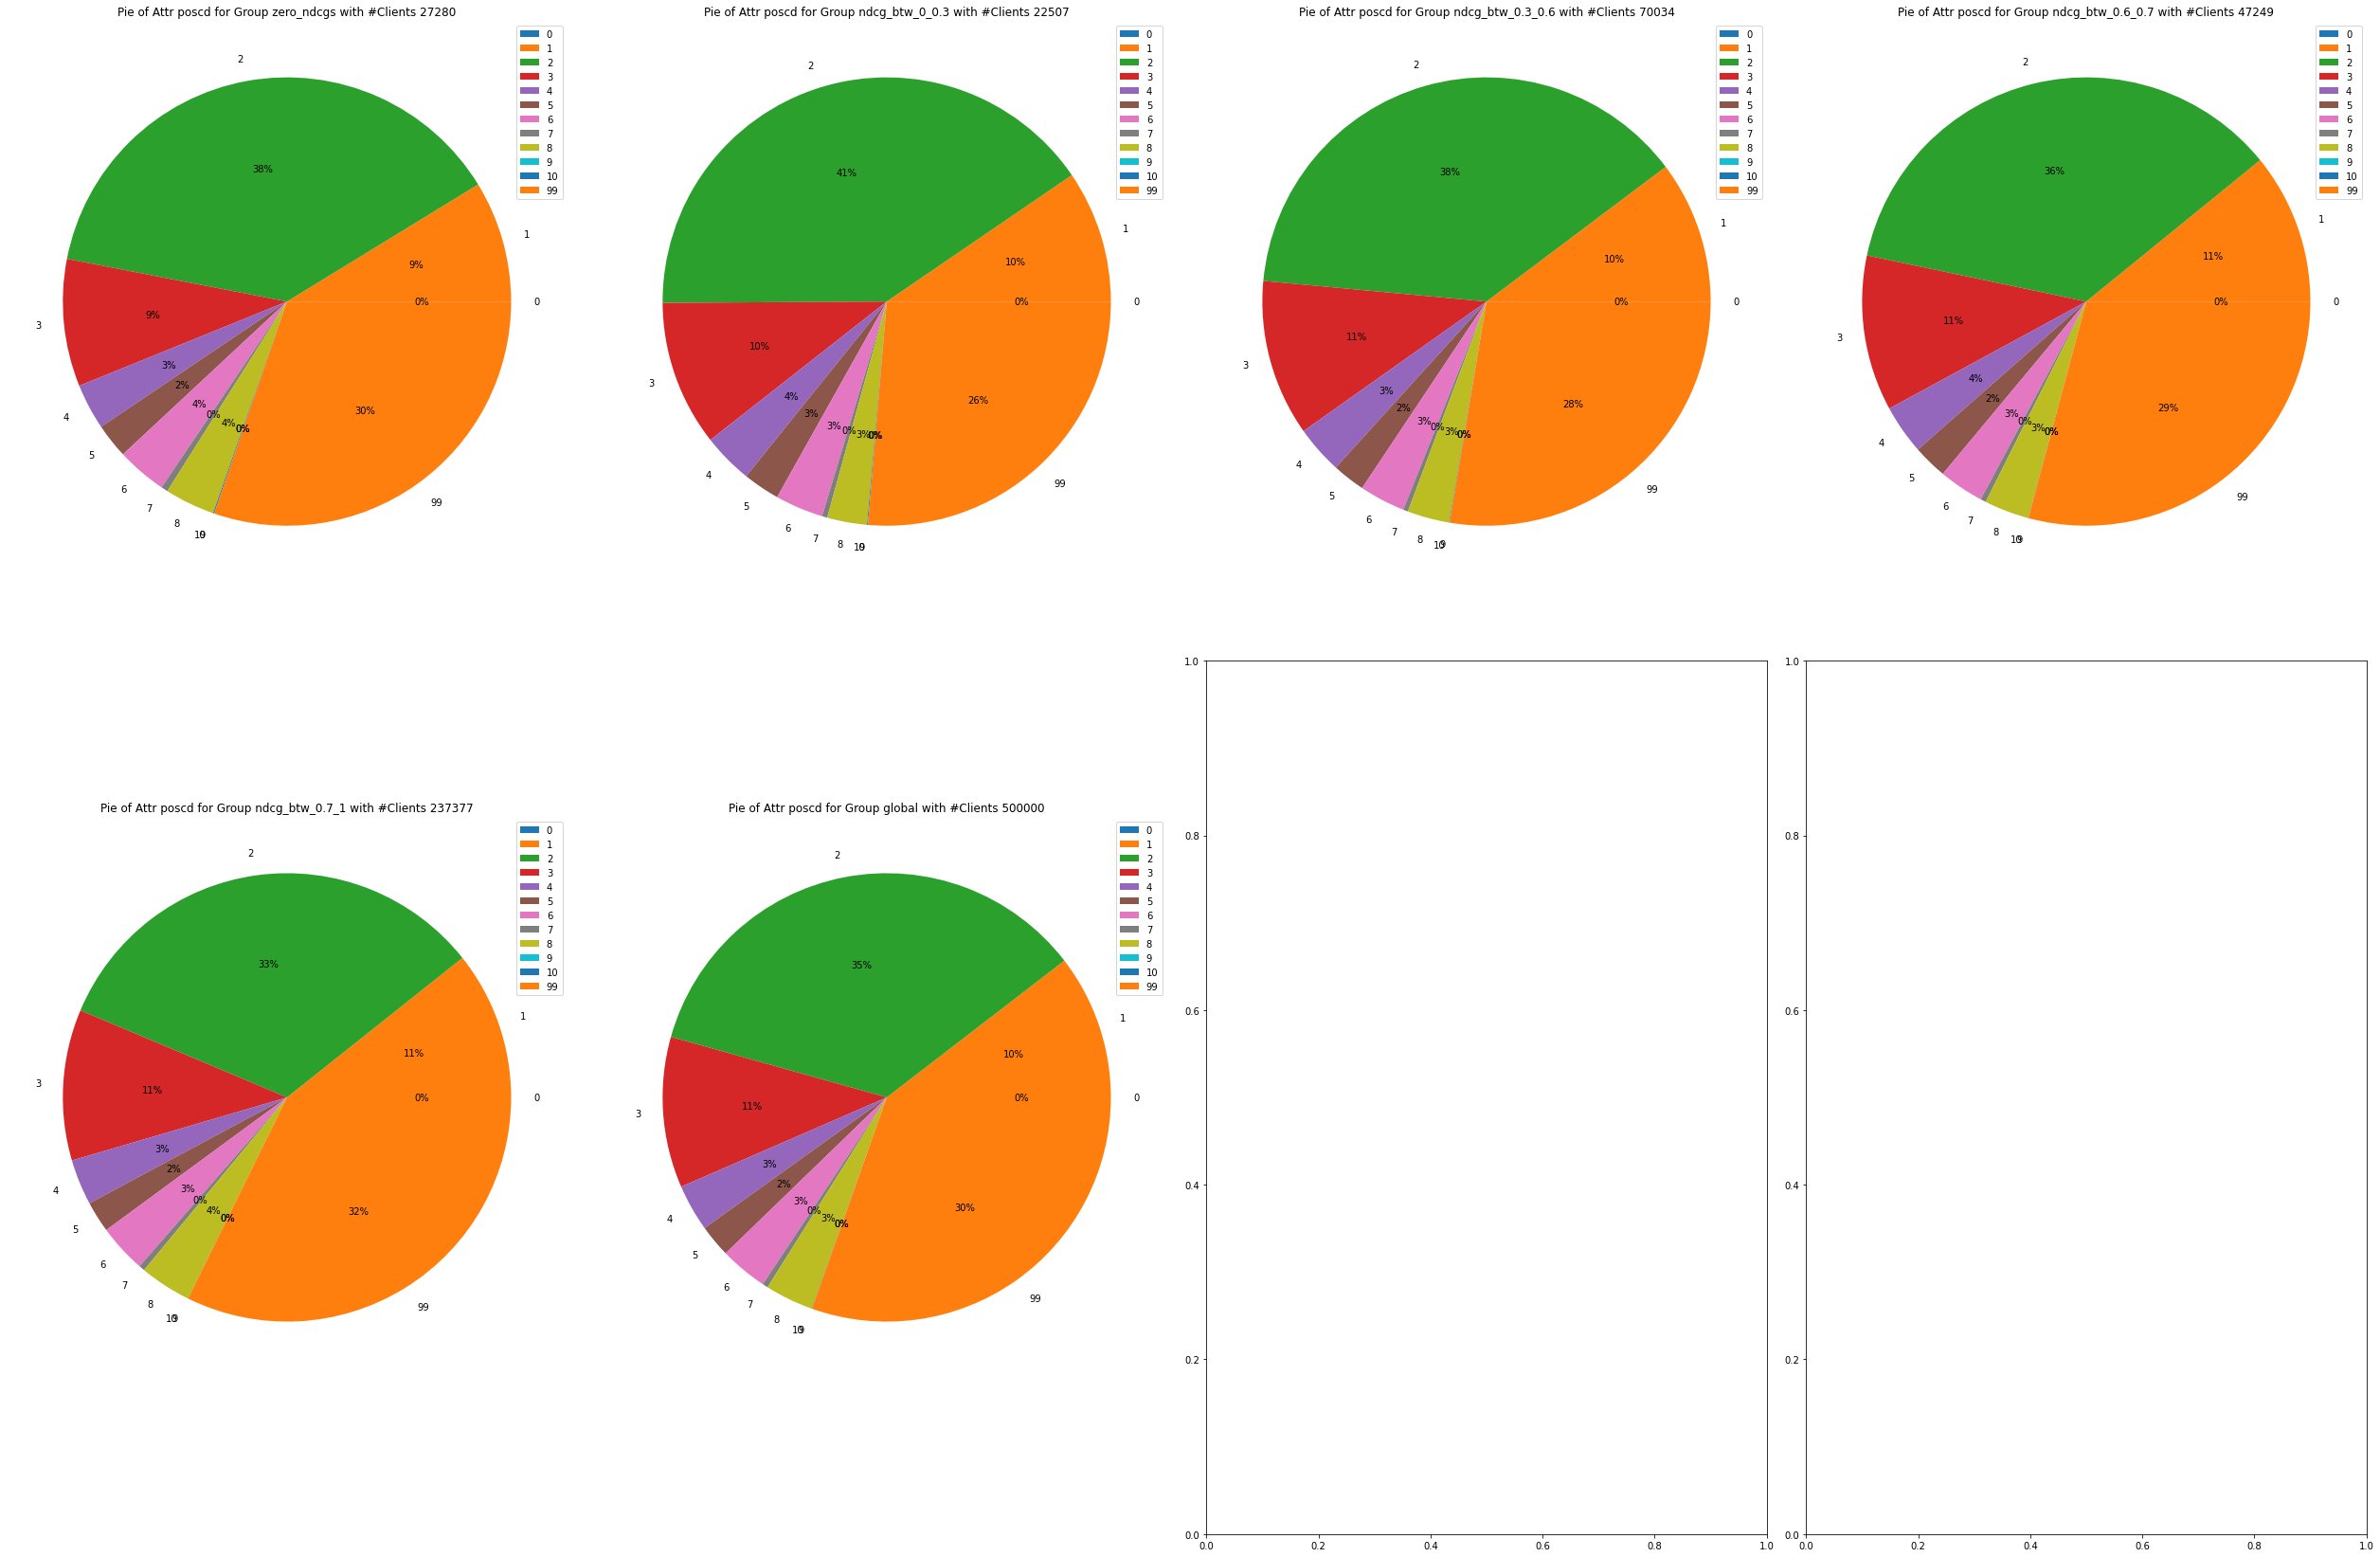

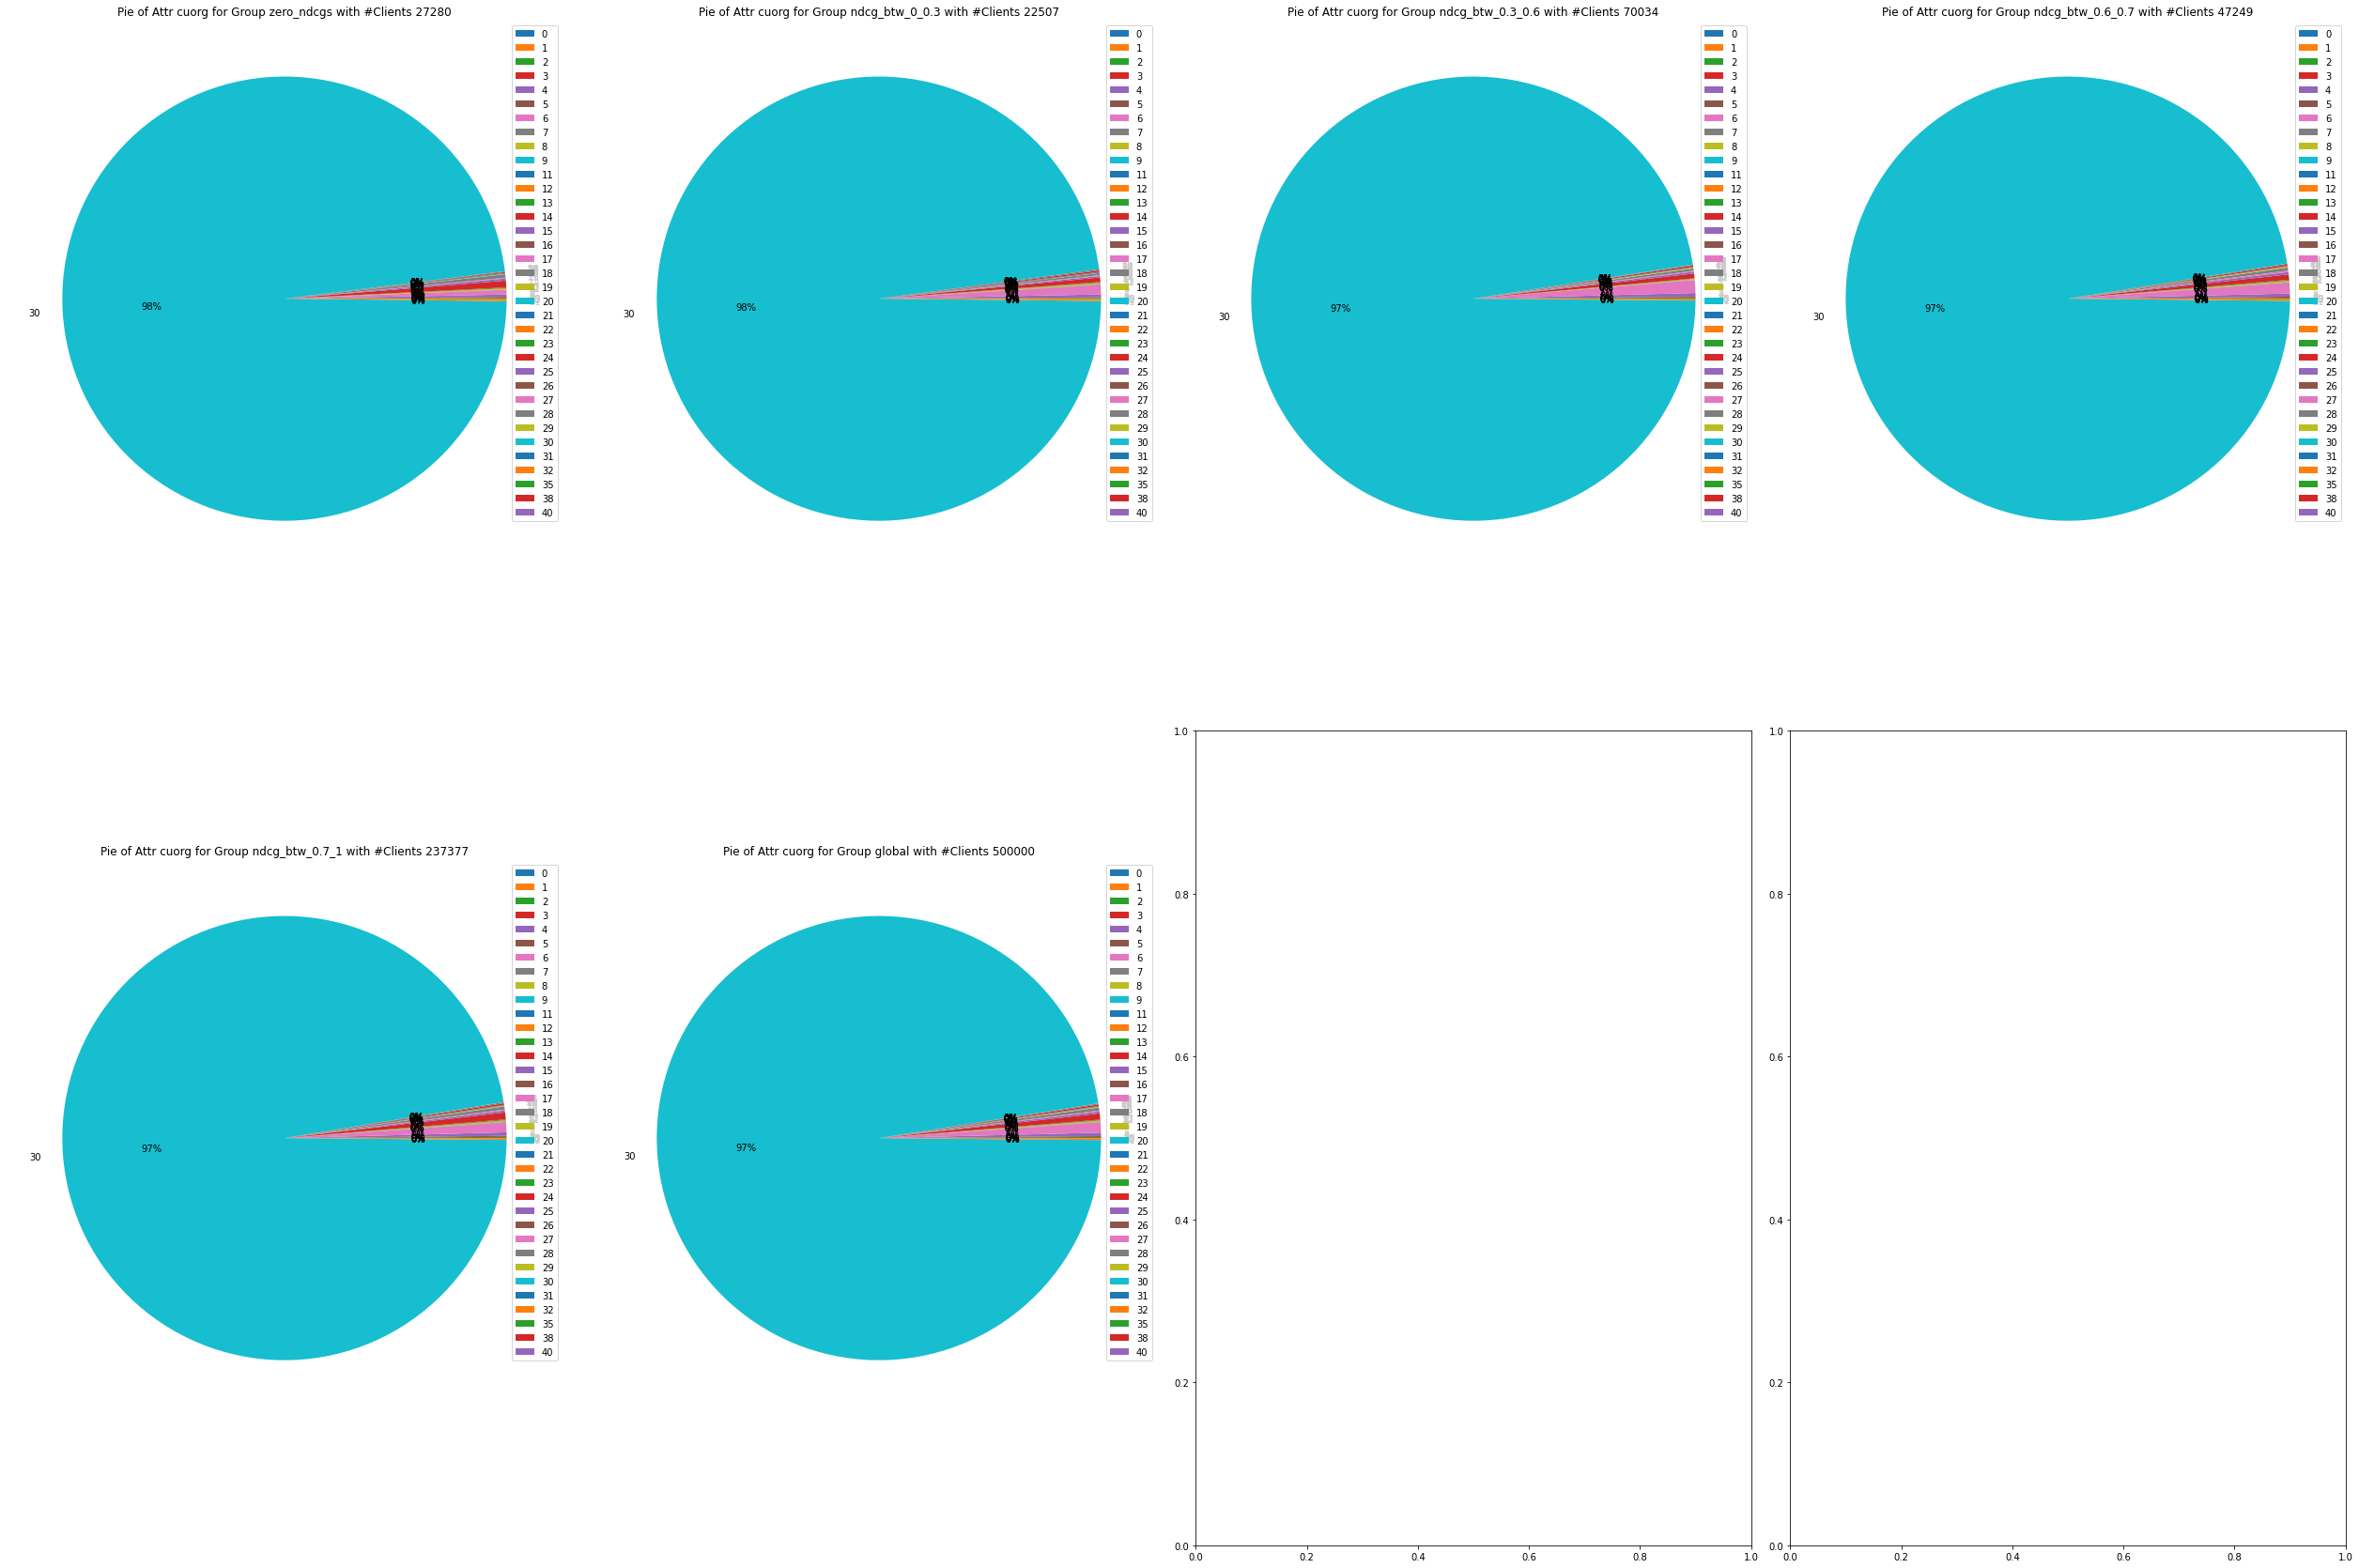

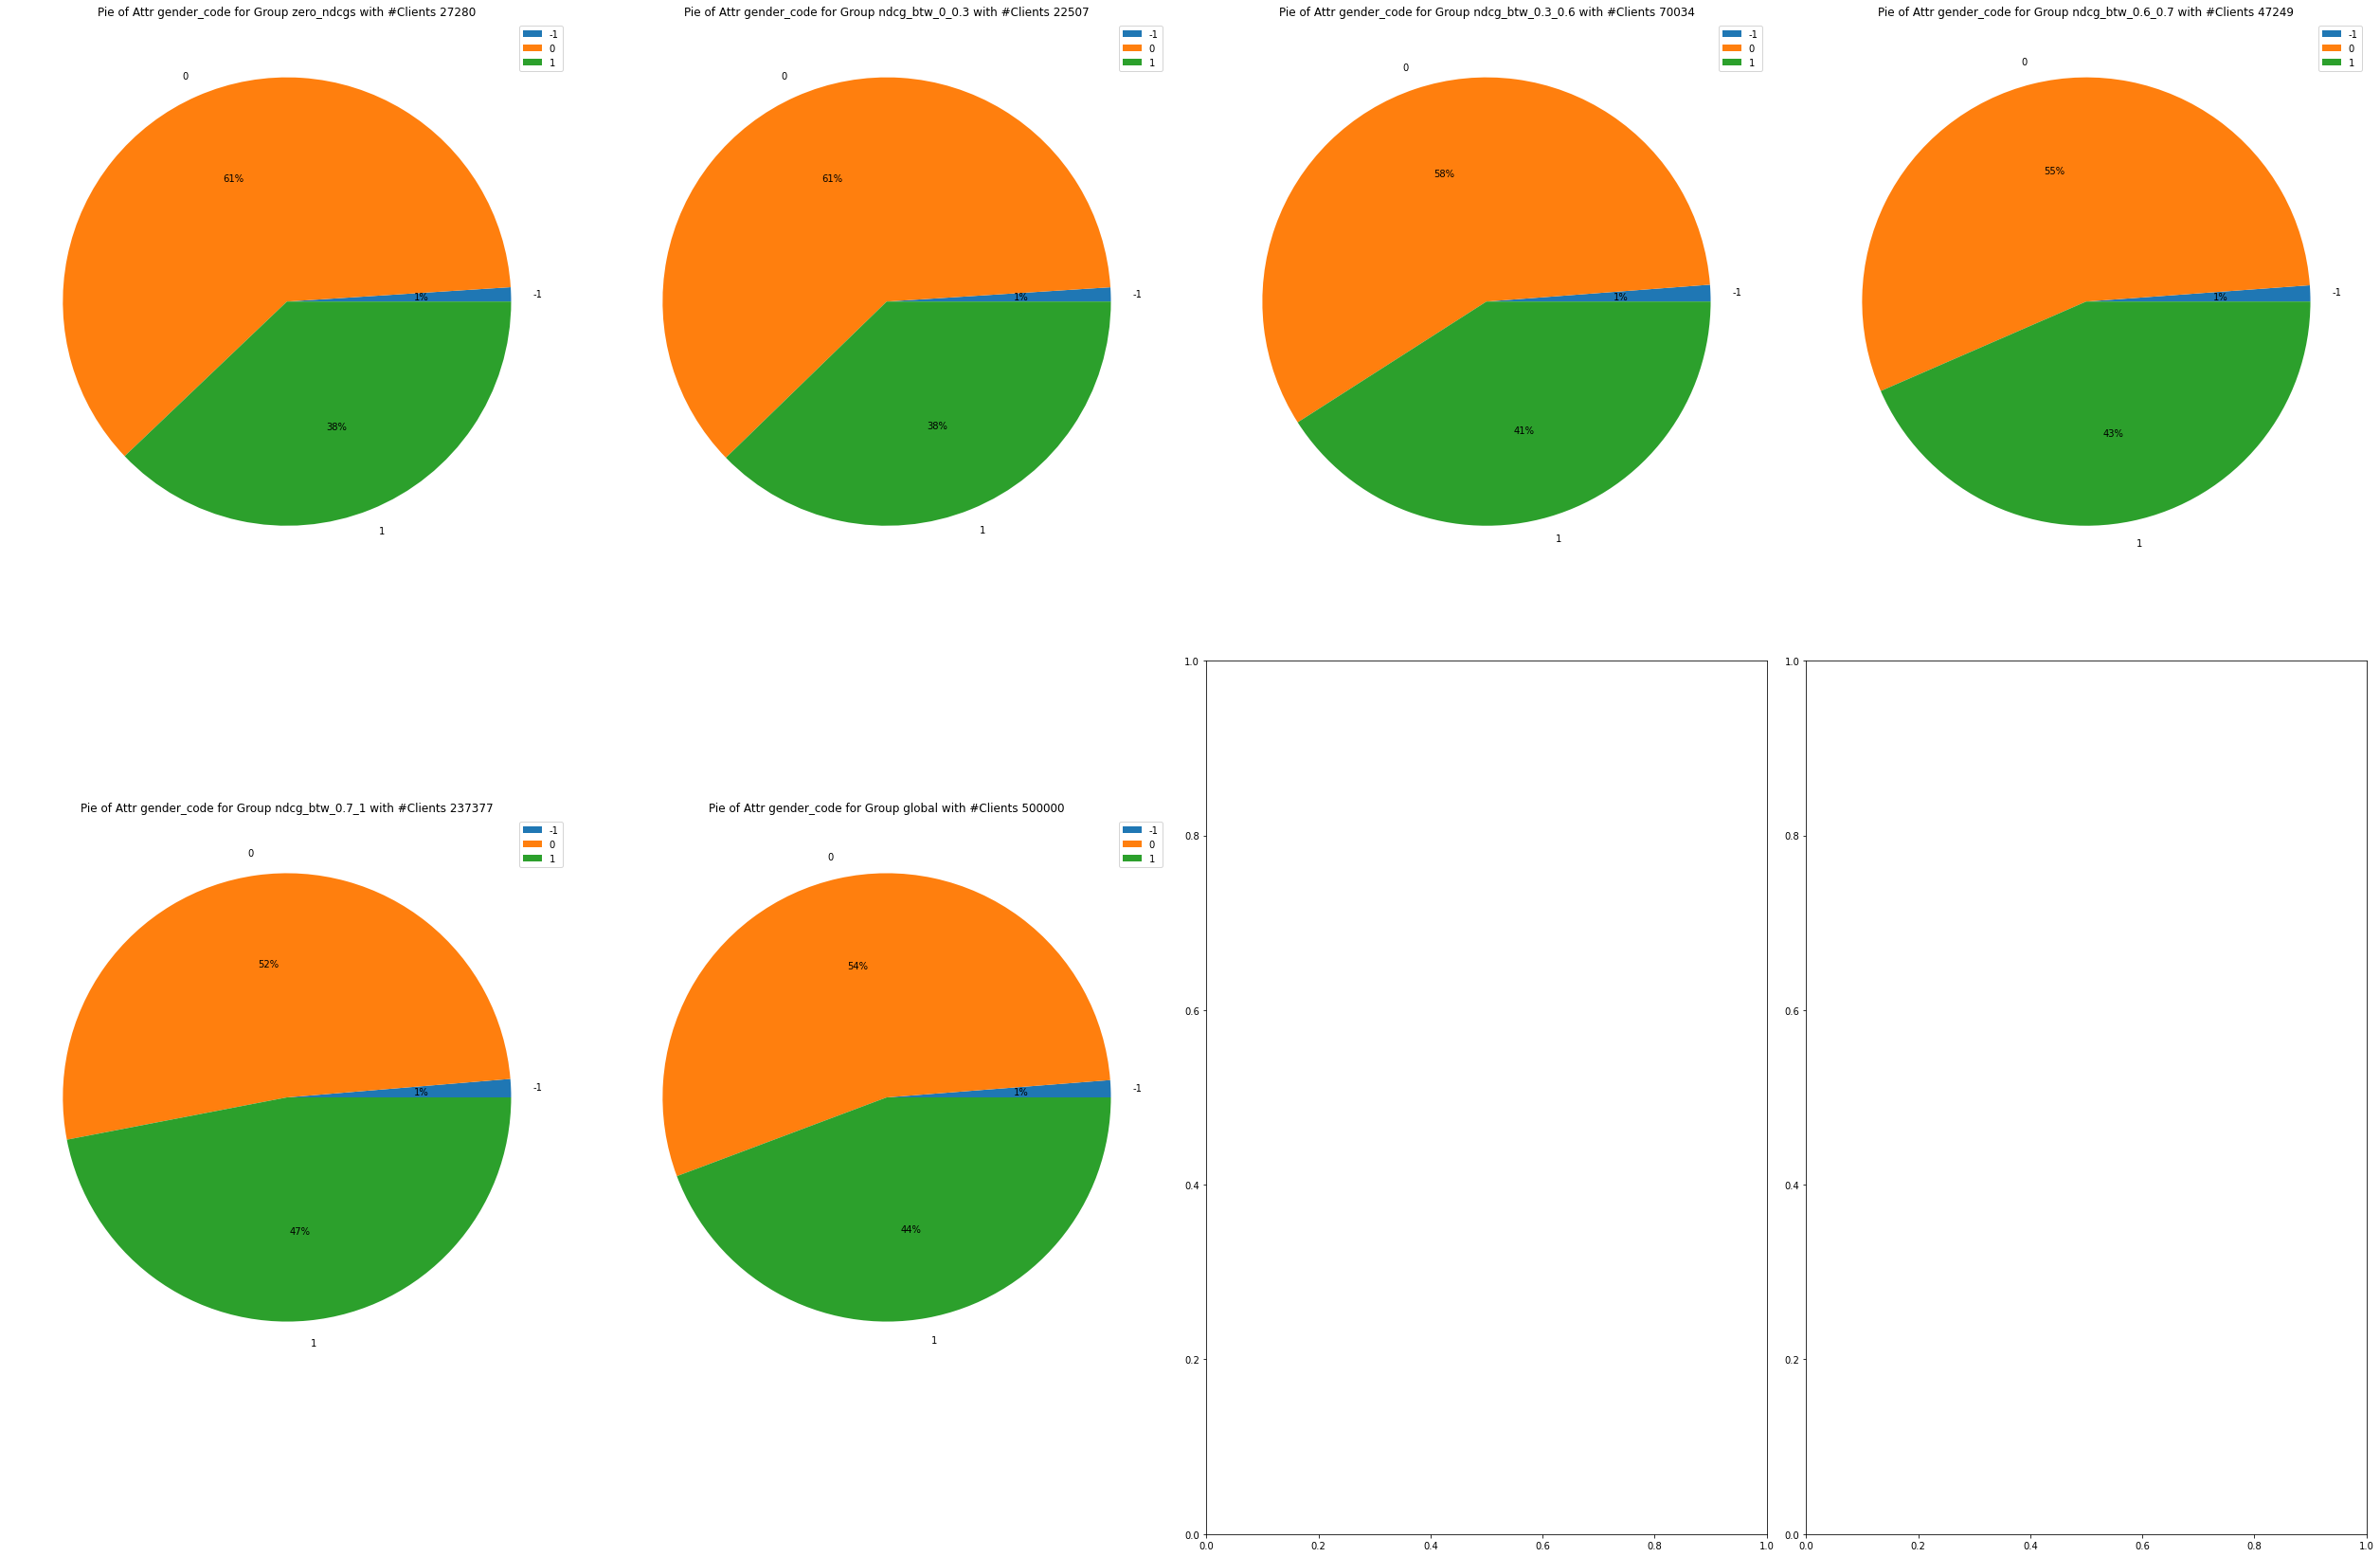

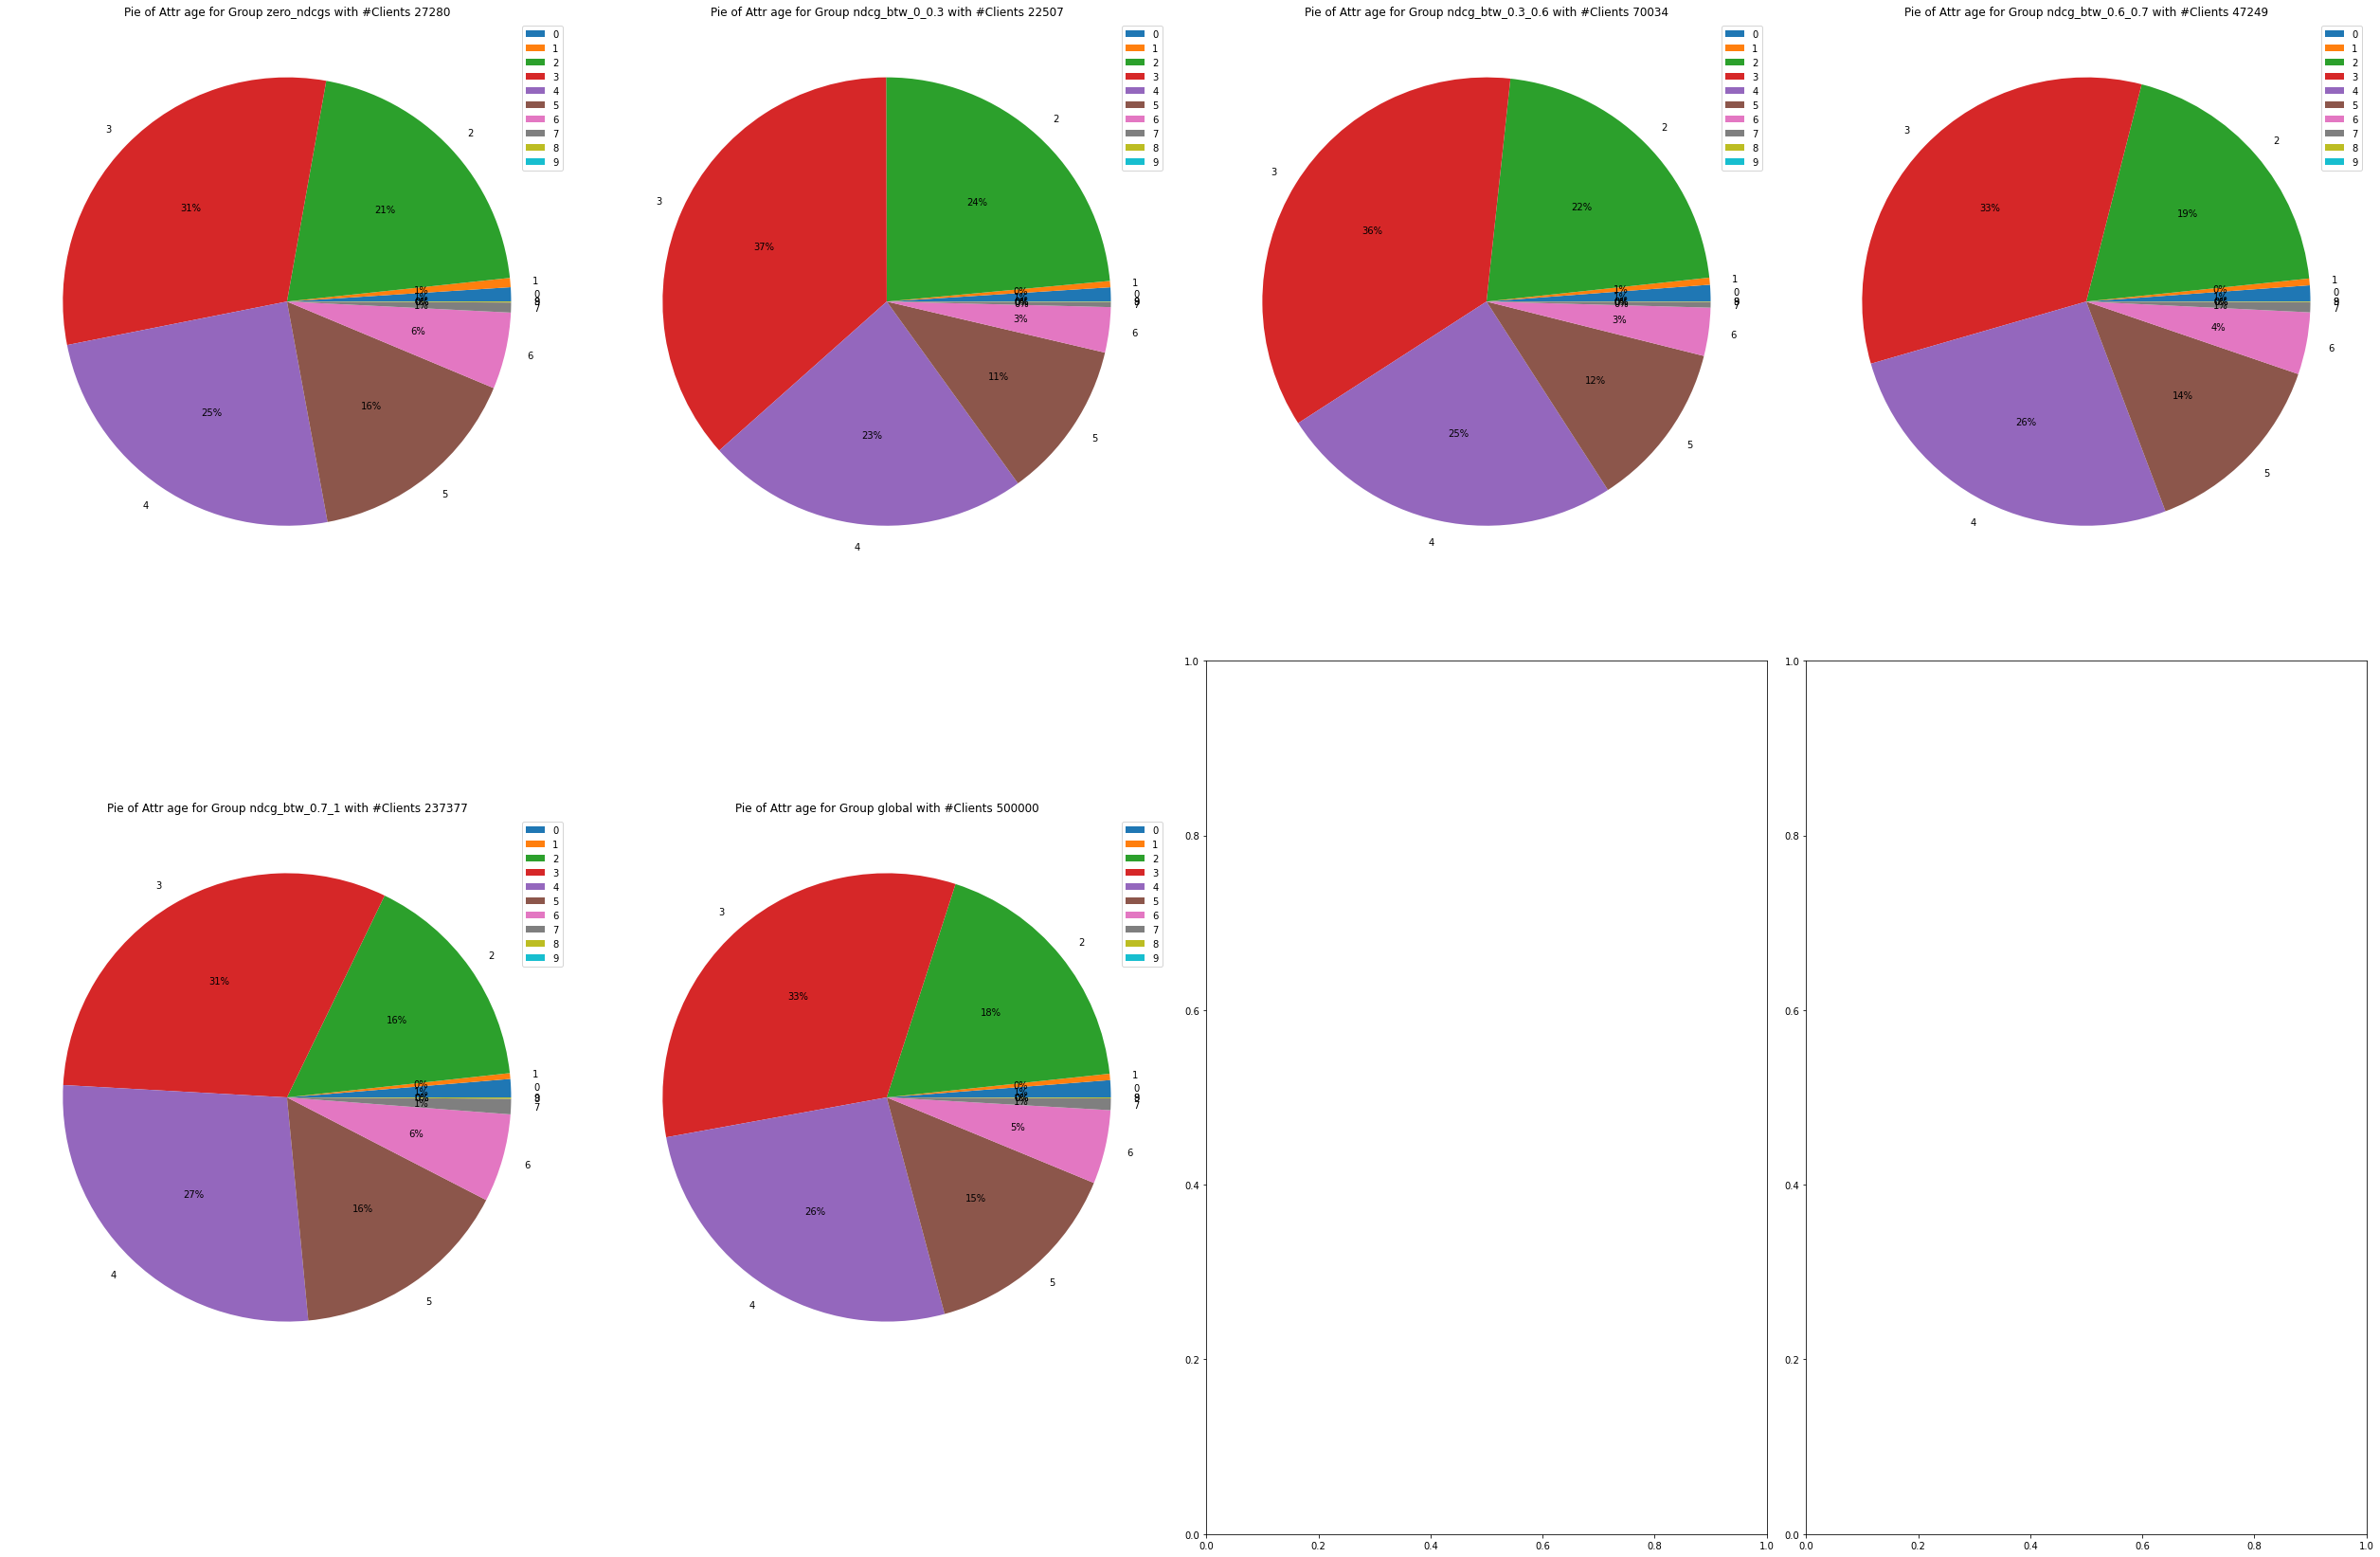

In [139]:
# Plot ratio of #clients versus specified client attribute using pie charts
def plot_cli_attr(attr, cli_gps):
    cat_ticks = sorted(df[attr].unique())
    n_cols = 4
    n_rows = len(cli_gps)//n_cols+1
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(35, 25))
    
    for i, (cli_gp_name, chids) in enumerate(cli_gps.items()):
        df_ = df[df['chid'].isin(chids) & (df['dt'] == 24)]
        val_cnts = df_[attr].value_counts().sort_index()
        val_cnts = val_cnts.reindex(cat_ticks, fill_value=0)
        ax_coord = axs[i//n_cols, i%n_cols] if n_rows != 1 else axs[i%n_cols] 
        ax_coord.pie(x=val_cnts, labels=cat_ticks, autopct='%1.f%%')
        ax_coord.set_title(f"Pie of Attr {attr} for Group {cli_gp_name} with #Clients {len(chids)}")
        ax_coord.legend()
        del df_
    
    plt.tight_layout()

gps = {k: v for k, v in cli_gps.items() if k != 'perfect'}   # Perfect group is absorbed into group NDCG 0.7-1
gps['global'] = CHIDS   # Add global group containing all the clients in the specified dt
for f in CLI_ATTRS[1:]:
    plot_cli_attr(f, gps)

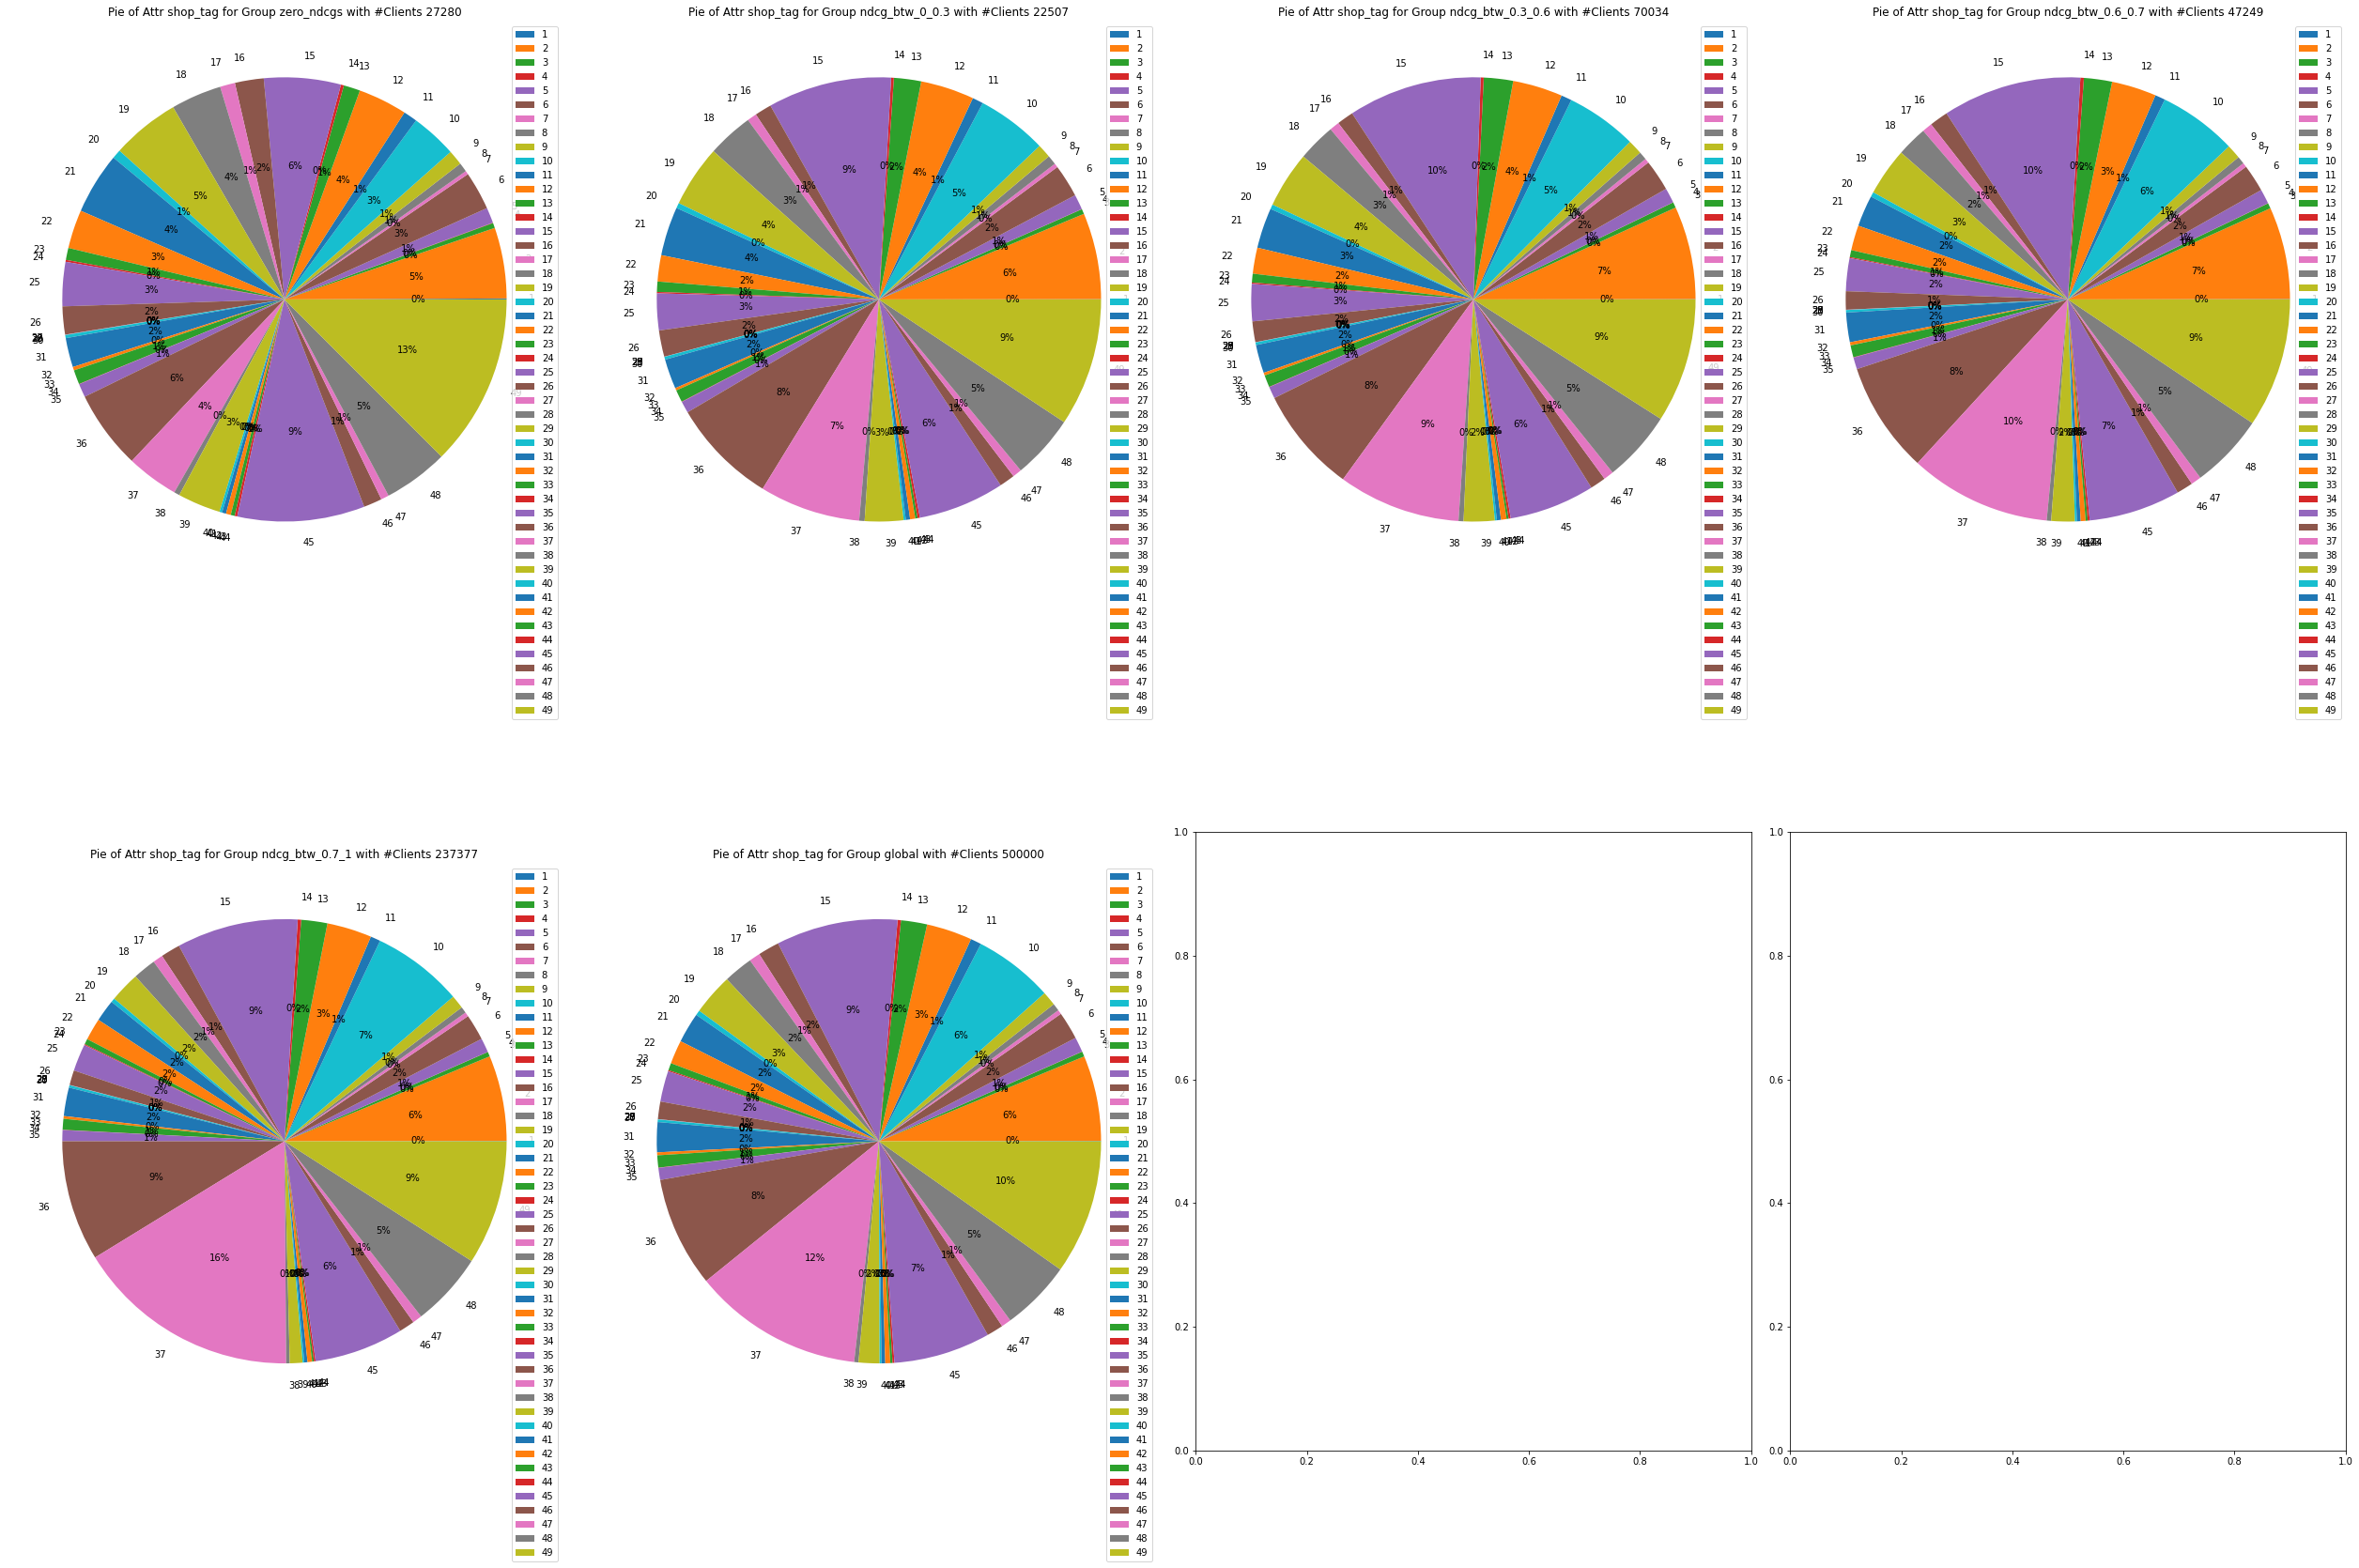

In [140]:
plot_cli_attr('shop_tag', gps)

### Property2 -  First Transaction
#### Observation
1. There are originally more clients joining from the begeinning (i.e., `dt` == 1), so no matter what performance case is (*e.g.*, best, worst, etc), ratio of `dt` == 1 must be the **heighest**.
2. There's a high possibility that clients joining at `dt` == 1 can get much better performance. I think it's because the historical information is more complete. And, we can also figure out this from observing group `zero_ndcgs_both`, where there's a low possibility that clients joining at `dt` == 1 get 0 NDCGs. 
3. There's a siginificant peak at `dt` == 24 for group `zero_ndcgs_both`. I think it's related to the issue of **clod-start** indicating newly joining clients are hard to predict because there's no any historical information provided. And, this result is also aligned with the observation from group `worse_than_ndcg0`.

In [148]:
def plot_first_txn_dt(leg_only, chid_gps):
    '''Plot month (i.e., `dt`) distribution that the first transaction 
    appears for clients in each group.
    
    Parameters:
        leg_only
        chid_gps
    Return:
        None
    '''
    df_ = df[df['shop_tag'].isin(LEG_SHOP_TAGS)] if leg_only else df.copy()
    fig, ax = plt.subplots(figsize=(14, 7))
    
    first_txns_global = df_.groupby(by=['chid'])['dt'].min()
    first_txn_val_cnts_global = first_txns_global.value_counts().sort_index()
    ax.bar(x=first_txn_val_cnts_global.index.values, 
           height=first_txn_val_cnts_global.values / 5e5,   # Global, 500000 clients in total 
#            alpha=0.5,
           label='global')
    for chid_gp_name, chid_gp in chid_gps.items():
        df_chid_gp = df_[df_['chid'].isin(chid_gp)]
        first_txns = df_chid_gp.groupby(by=['chid'])['dt'].min()
        first_txn_val_cnts = first_txns.value_counts().sort_index()
        ax.bar(x=first_txn_val_cnts.index.values, 
               height=first_txn_val_cnts.values / len(chid_gp), 
               alpha=0.5,
               label=chid_gp_name)
        del df_chid_gp
    ax.set_title("First Transactions of Clients")
    ax.set_xlabel("dt")
    ax.set_ylabel("#Clients")
    ax.legend()
    plt.show()

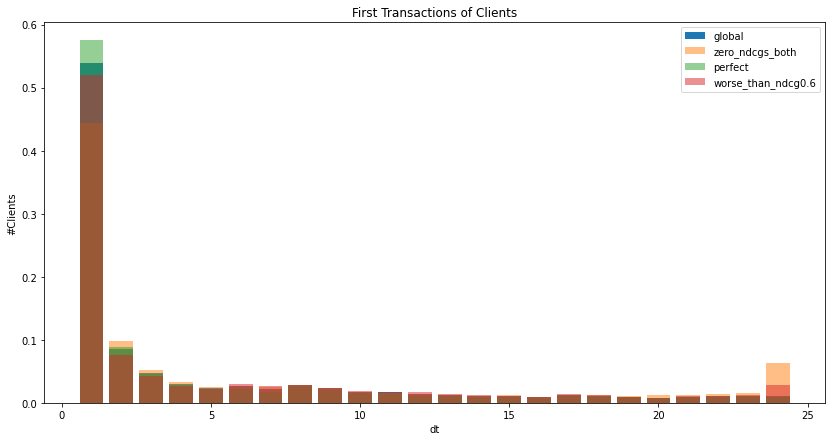

In [152]:
plot_first_txn_dt(leg_only=True, chid_gps={'zero_ndcgs_both': cli_gps['zero_ndcgs_both'], 'perfect': cli_gps['perfect'], 'worse_than_ndcg0.6': cli_gps['worse_than_ndcg0.6']})

### Property3 - `txn_amt` Distribution
#### Objective 
Because the final objective is to **rank by `txn_amt`**, I want to see if `txn_amt` distributions have siginificant discrepancy across different months. If it's actually true, then I can cleverly select which months woould be training/validation sets.
#### Observation
1. Distribution of each `shop_tag` at `dt==24` seems relatively far from others.
    * Maybe, I should cleverly select another validation set.
2. 

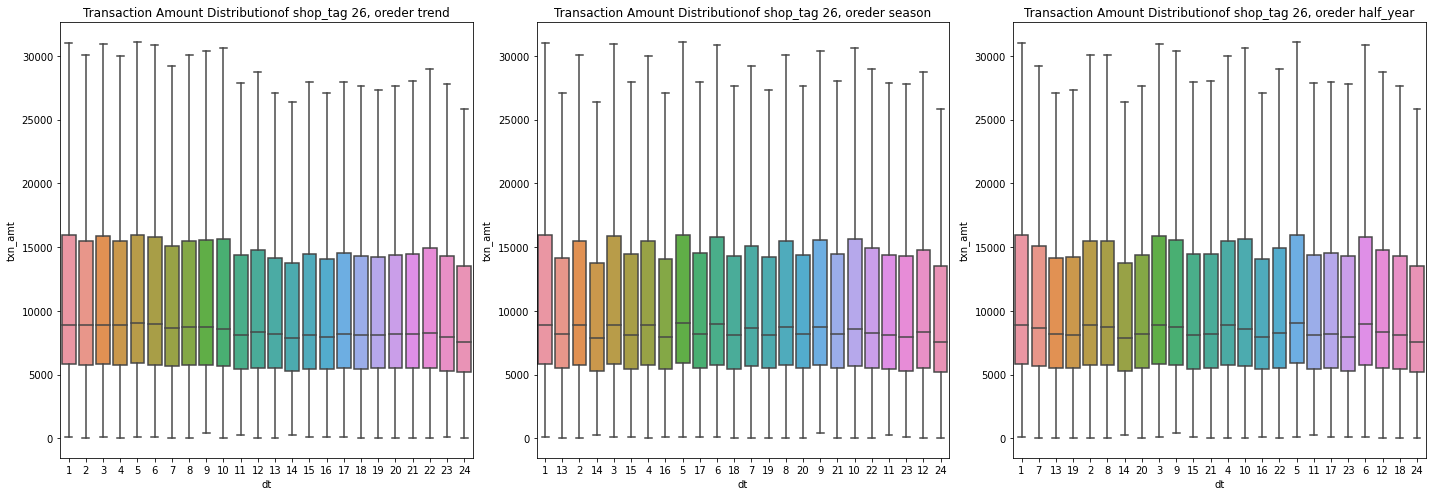

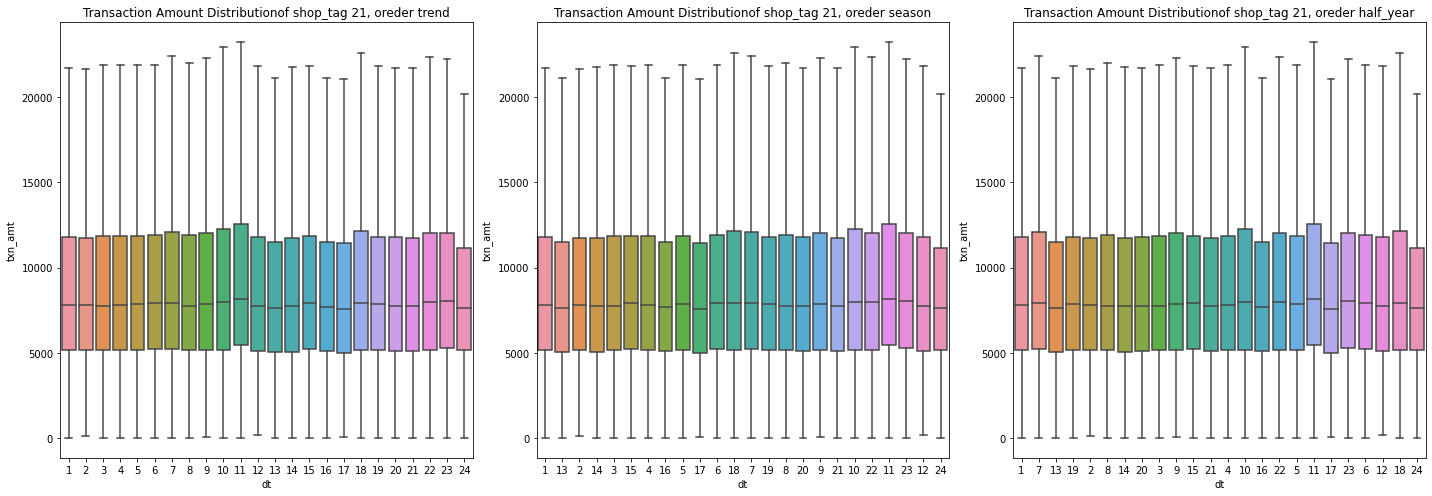

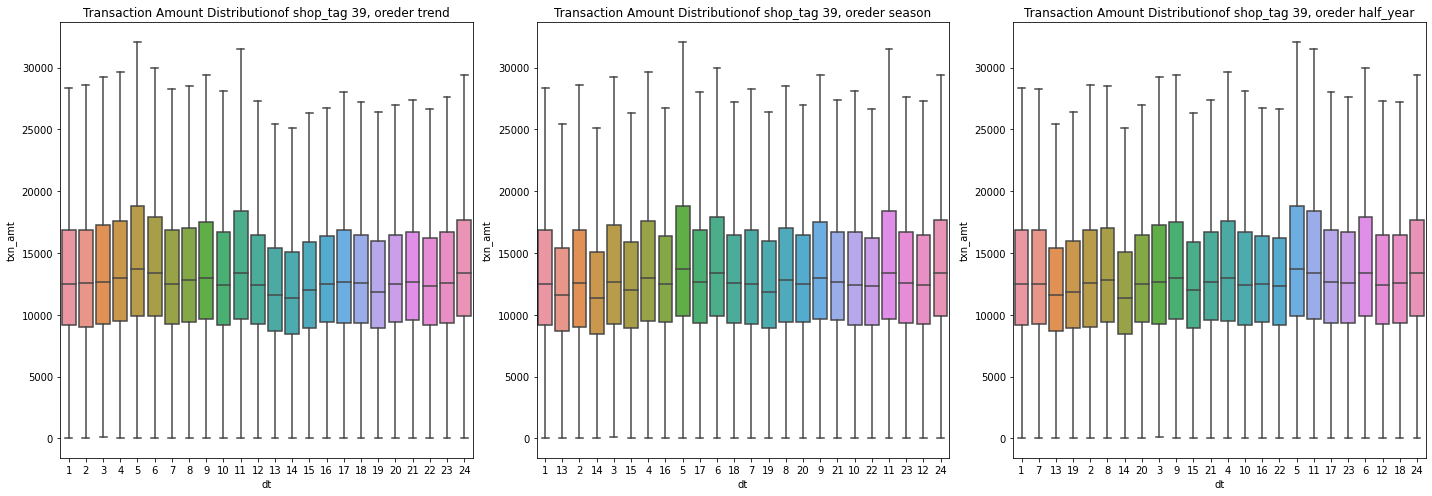

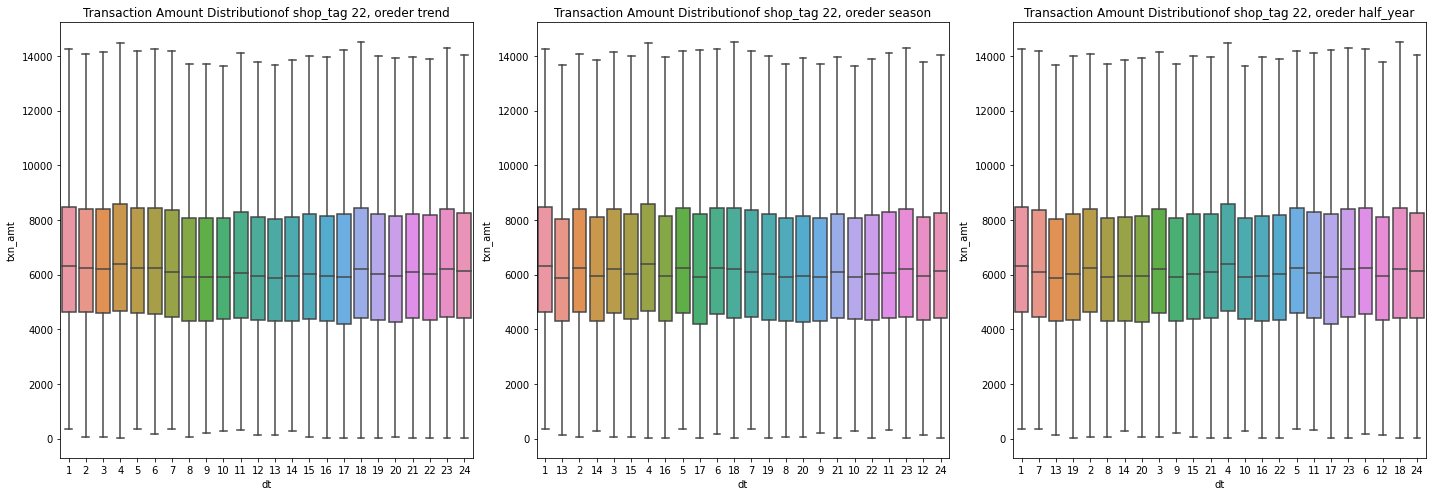

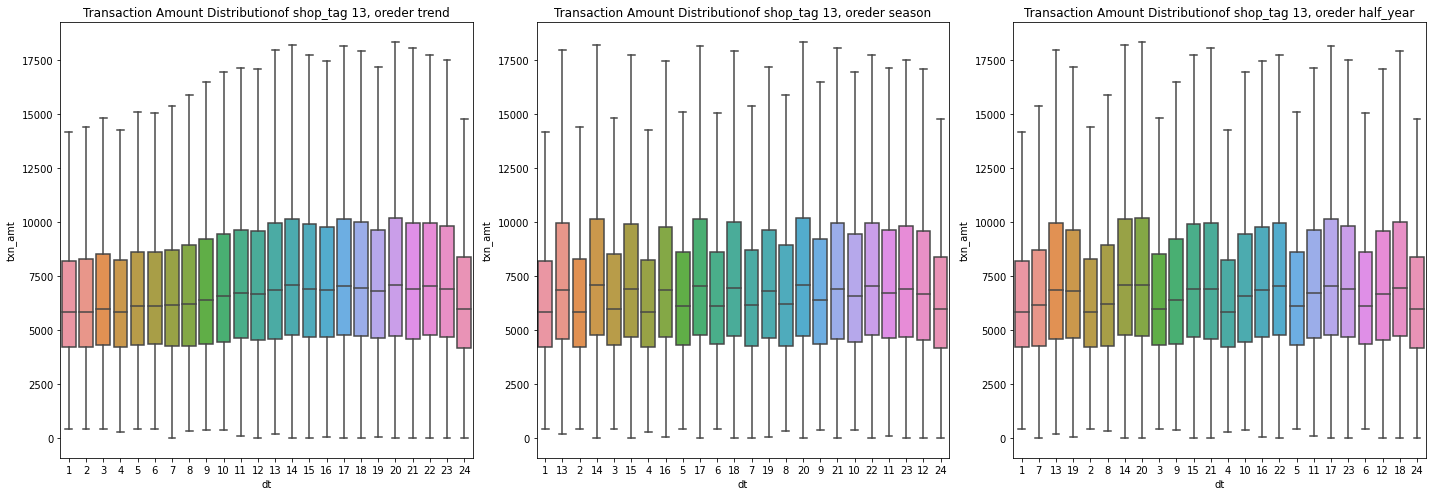

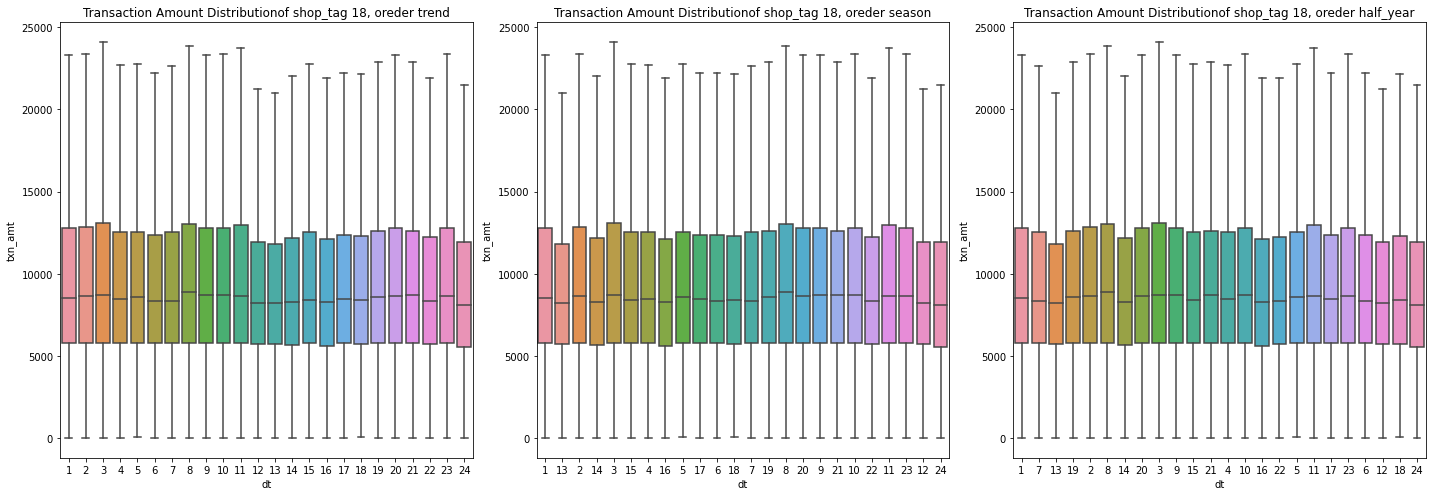

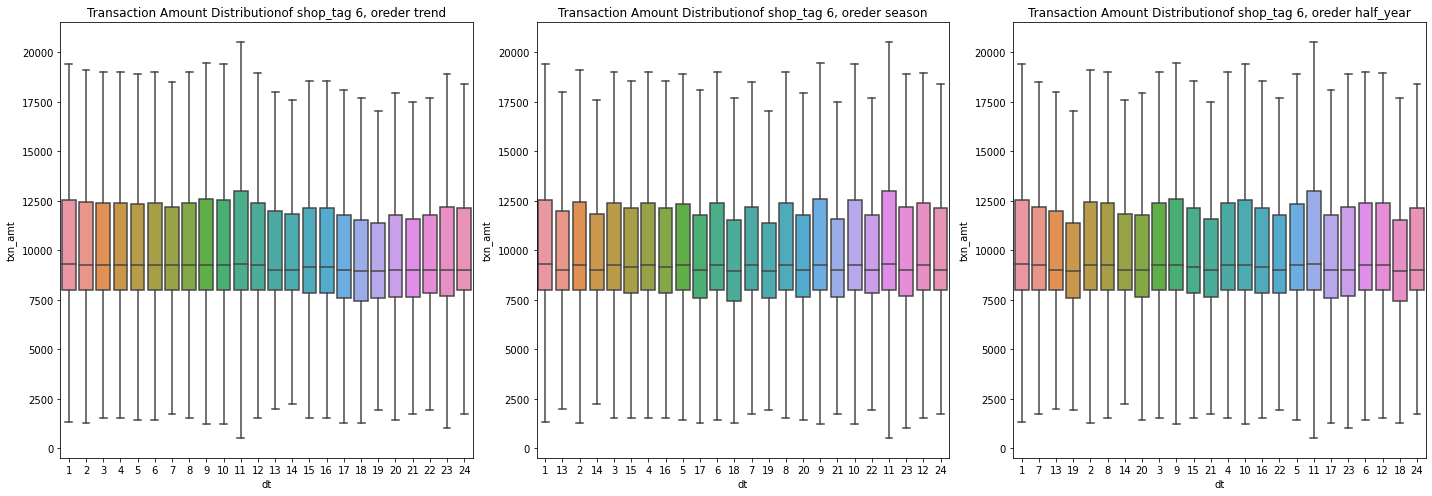

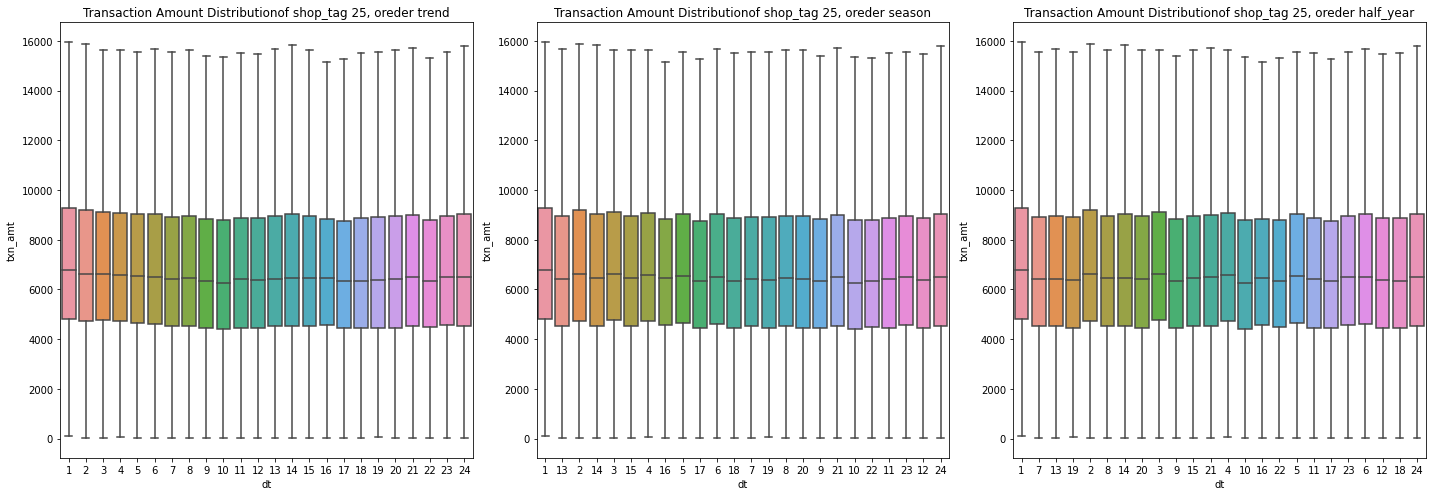

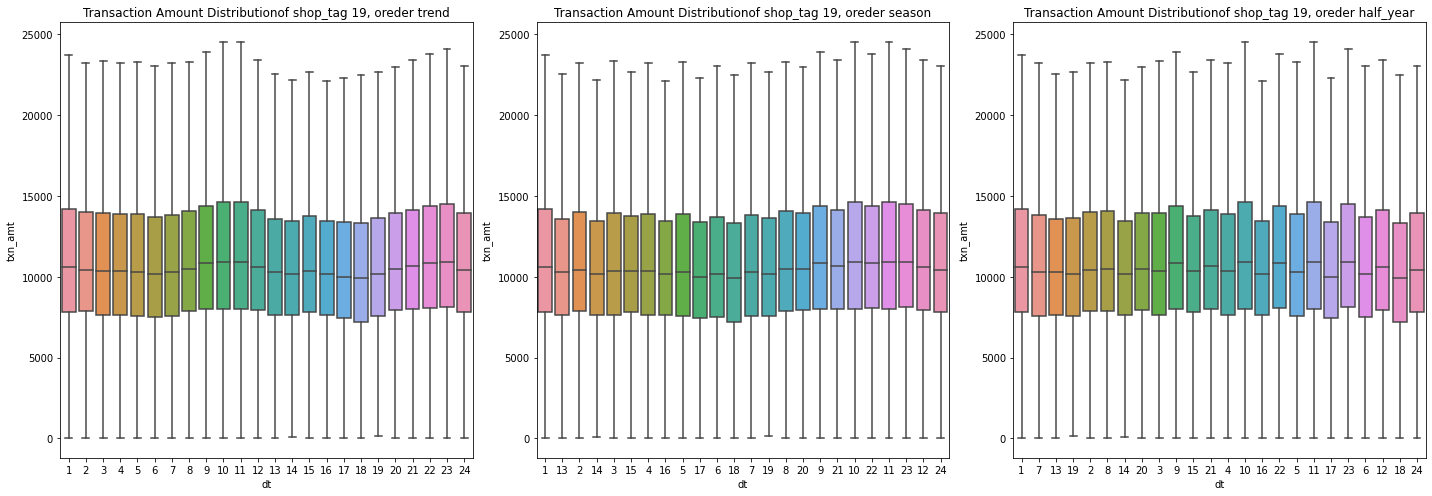

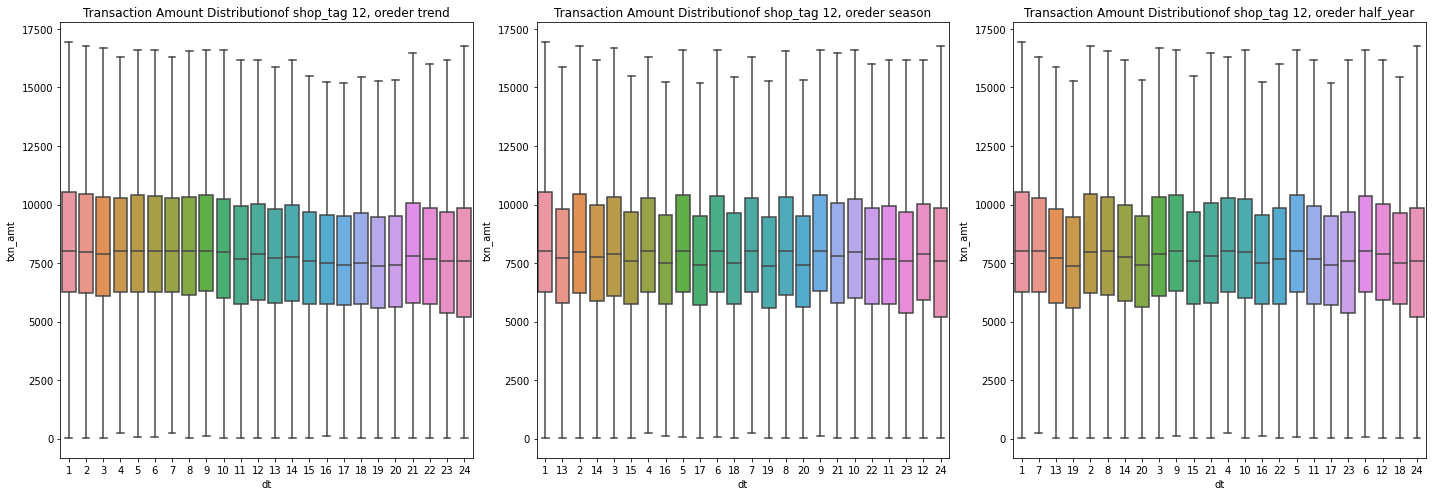

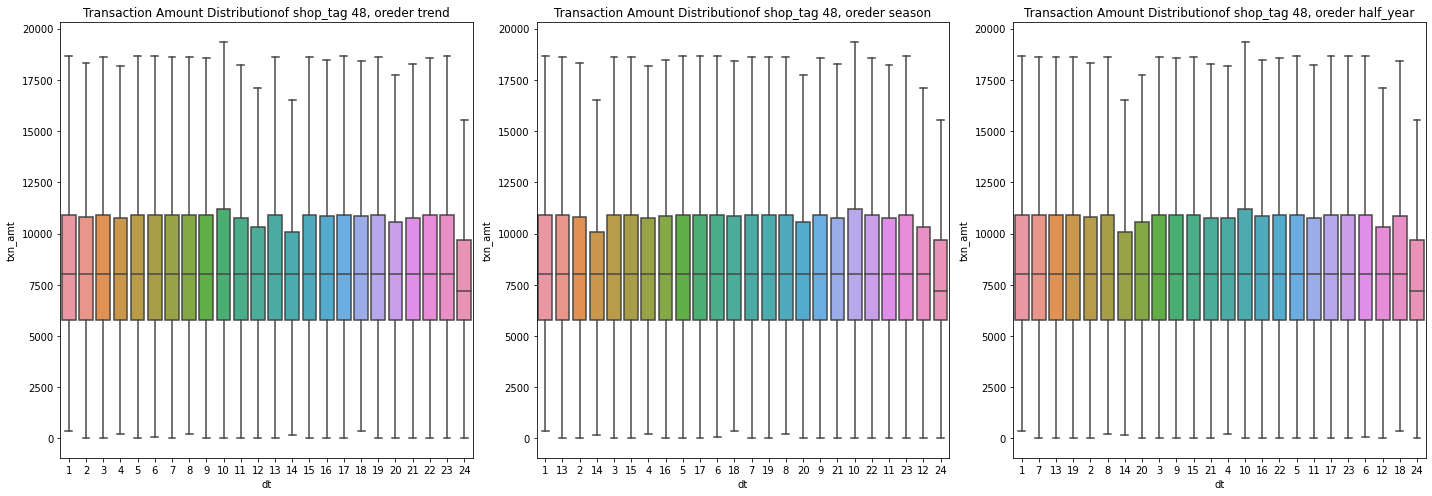

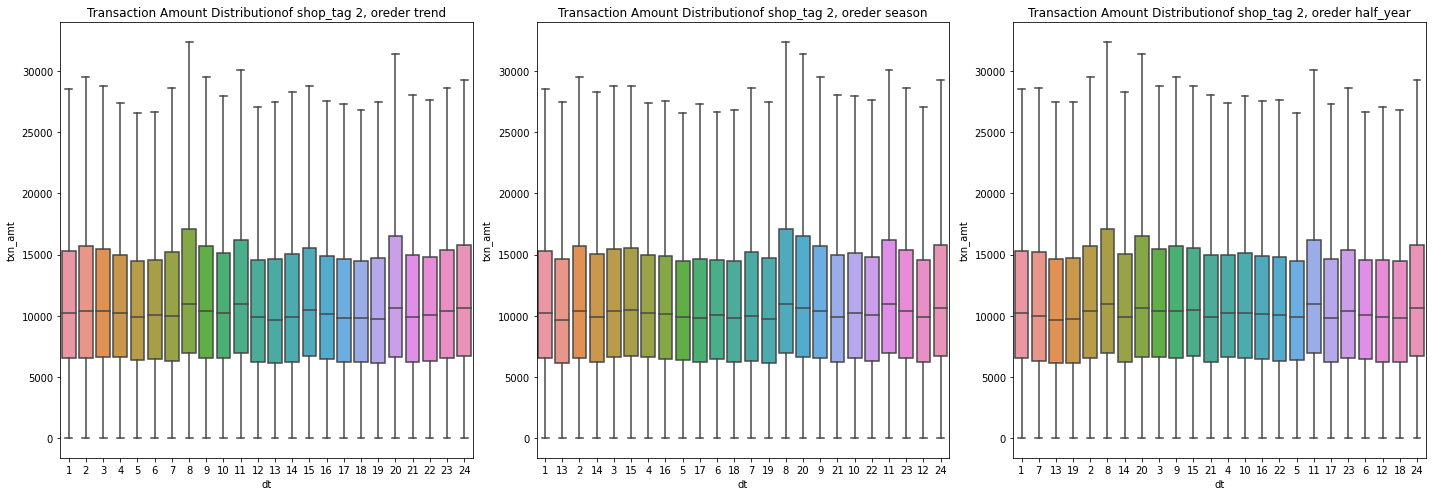

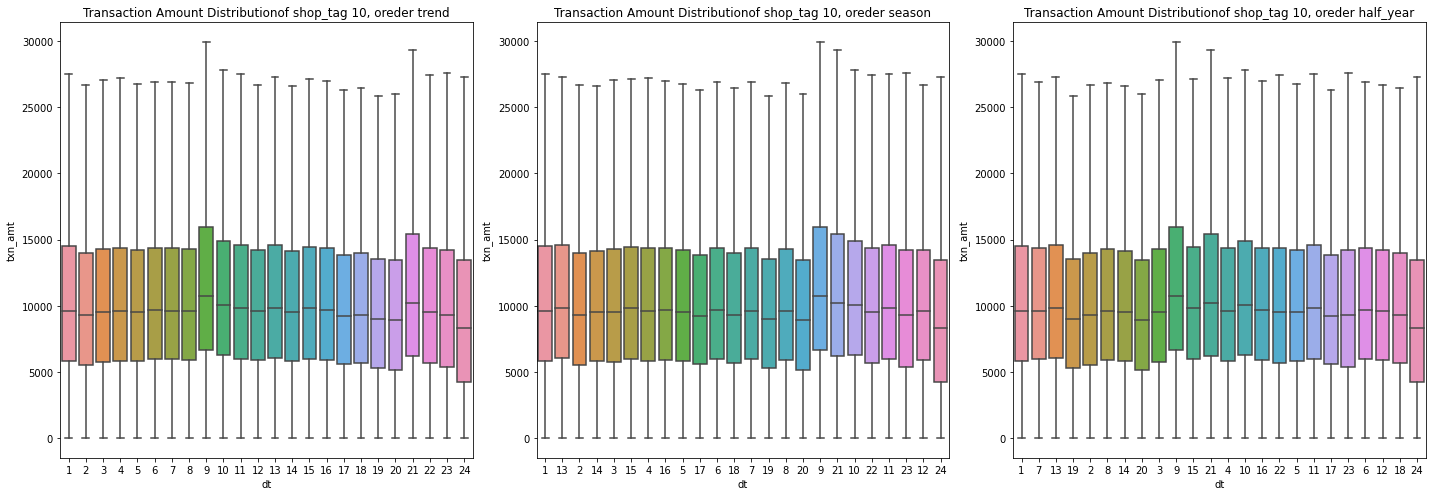

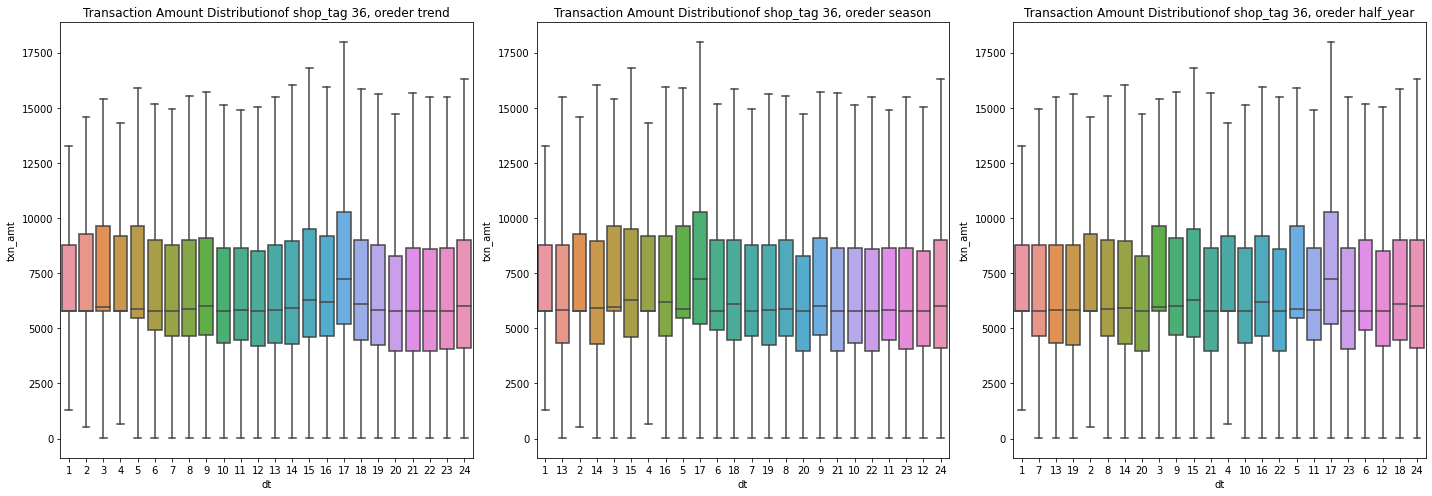

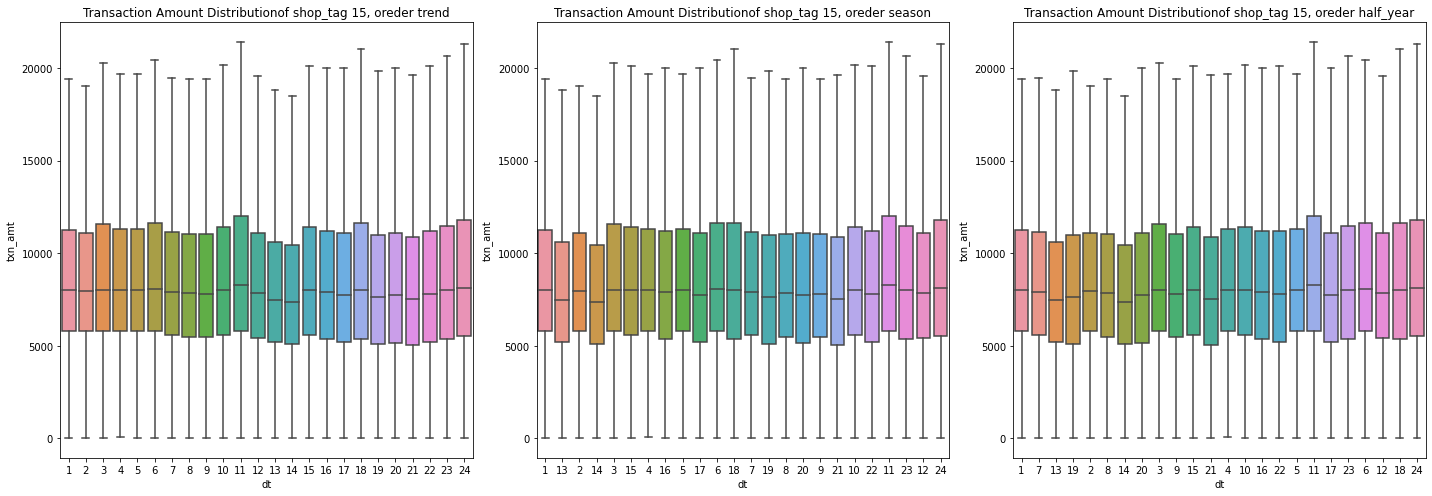

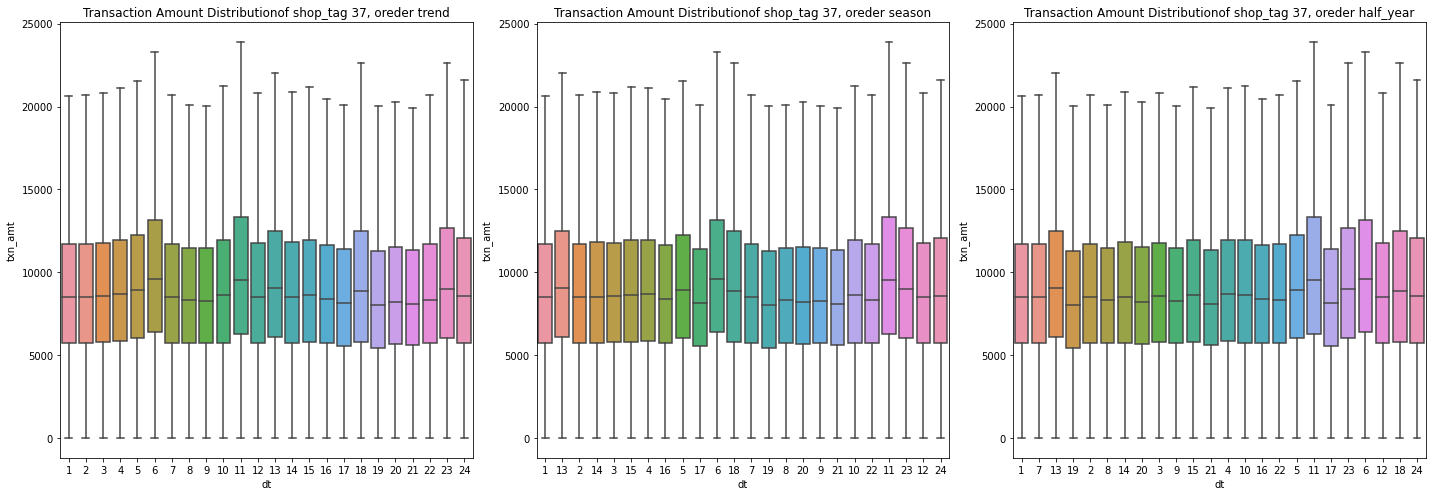

In [196]:
# popularity_ranks = df[df['shop_tag'].isin(LEG_SHOP_TAGS)].groupby(by=['shop_tag']).size().sort_values()
# list(popularity_ranks.index)
def plot_txn_amt_dist(leg_only):
    '''Plot transaction amount distribution across months for each
    shop_tag.
    
    Parameters:
        leg_only: bool, whether to consider legitimate shop_tags only
        
    Return:
        None
    '''
    if leg_only: 
        n_rows, n_cols, figsize = 4, 4, (24, 24)
#         shop_tags = LEG_SHOP_TAGS
        shop_tags = [26, 21, 39, 22, 13, 18, 6, 25, 
                     19, 12, 48, 2, 10, 36, 15, 37]
        # Ordered by #samples
    else: 
        n_roshop, n_cols, figsize = 10, 5, (24, 60)
        shop_tags = SHOP_TAGS_
        
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    order = []
    for dt in range(1, 13):
        order.append(dt)
        order.append(dt+12)
    for i, shop_tag in tqdm(enumerate(shop_tags)):
        df_ = df[df['shop_tag'] == shop_tag]
        sns.boxplot(x='dt', y='txn_amt', data=df_, showfliers=False,
                    order=order, ax=axs[i//n_cols, i%n_cols])
        axs[i//n_cols, i%n_cols].set_title(f"Transaction Amount Distribution"
                                           f"of shop_tag {shop_tag}, "
                                           f"Popularity {df_.shape[0]}")
        del df_
    plt.tight_layout()
    
def plot_txn_amt_dist_(shop_tag):
    df_ = df[df['shop_tag'] == shop_tag]
    orders = {}
    orders['trend'] = DTS
    order_se = []
    for dt in range(1, 13):
        order_se.append(dt)
        order_se.append(dt+12)
    orders['season'] = order_se
    order_half_yr = []
    for dt in range(1, 7):
        for gap in [0, 6, 12, 18]:
            order_half_yr.append(dt+gap)        
    orders['half_year'] = order_half_yr
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))    
    for i, (order_type, order) in enumerate(orders.items()):
        sns.boxplot(x='dt', y='txn_amt', data=df_, showfliers=False,
                    order=order, ax=axs[i%3])
        axs[i%3].set_title(f"Transaction Amount Distribution"
                                           f"of shop_tag {shop_tag}, "
                                           f"oreder {order_type}")
    plt.tight_layout()

# plot_txn_amt_dist(True)
for shop_tag in [26, 21, 39, 22, 13, 18, 6, 25, 19, 12, 48, 2, 10, 36, 15, 37]:
    plot_txn_amt_dist_(shop_tag)

#### Observation
<!-- Following observation is based on the perspective of **ratio**, so it shows a **relative** relation.
1. `shop_tag`s easily getting zero NDCGs are [2, 10, 18, 19, 21, 22, 25, 26, 39].
2. `shop_tag` 37 appears far more times in the group of **perfect (full) hits**.
    * Maybe it's because its historical information is the richest.
3. `shop_tag`s hardly getting full hits are [2, 13, 15, 18, 19, 21, (22), 25, (26), 39, (48)]. -->

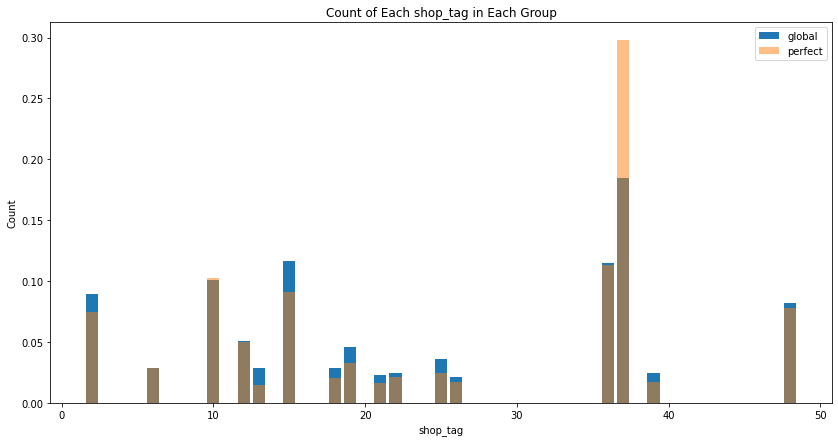

In [205]:
# Weird
def plot_(leg_only, chid_gps):
    '''Plot number of each `shop_tag`  
    '''
    df_ = df[df['shop_tag'].isin(LEG_SHOP_TAGS)] if leg_only else df.copy()
    fig, ax = plt.subplots(figsize=(14, 7))
    
    shop_tag_cnts_global = df_.groupby(by=['shop_tag']).size().sort_index()
    ax.bar(x=shop_tag_cnts_global.index.values, 
           height=shop_tag_cnts_global.values / len(df_), 
#            alpha=0.5,
           label='global')
    for chid_gp_name, chid_gp in chid_gps.items():
        df_chid_gp = df_[df_['chid'].isin(chid_gp)]
        shop_tag_cnts = df_chid_gp.groupby(by=['shop_tag']).size().sort_index()
        ax.bar(x=shop_tag_cnts.index.values, 
               height=shop_tag_cnts.values / len(df_chid_gp), 
               alpha=0.5,
               label=chid_gp_name)
        del df_chid_gp
    ax.set_title("Count of Each shop_tag in Each Group")
    ax.set_xlabel("shop_tag")
    ax.set_ylabel("Count")
    ax.legend()
    plt.show()

plot_(leg_only=True, chid_gps={'perfect': cli_gps['perfect'],}) #'zero_ndcgs_both': cli_gps['zero_ndcgs_both']})

## Feature Importance

In [4]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 60))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:150]))), 
            df['importance_normalized'].head(150), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:150]))))
    ax.set_yticklabels(df['feature'].head(150))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

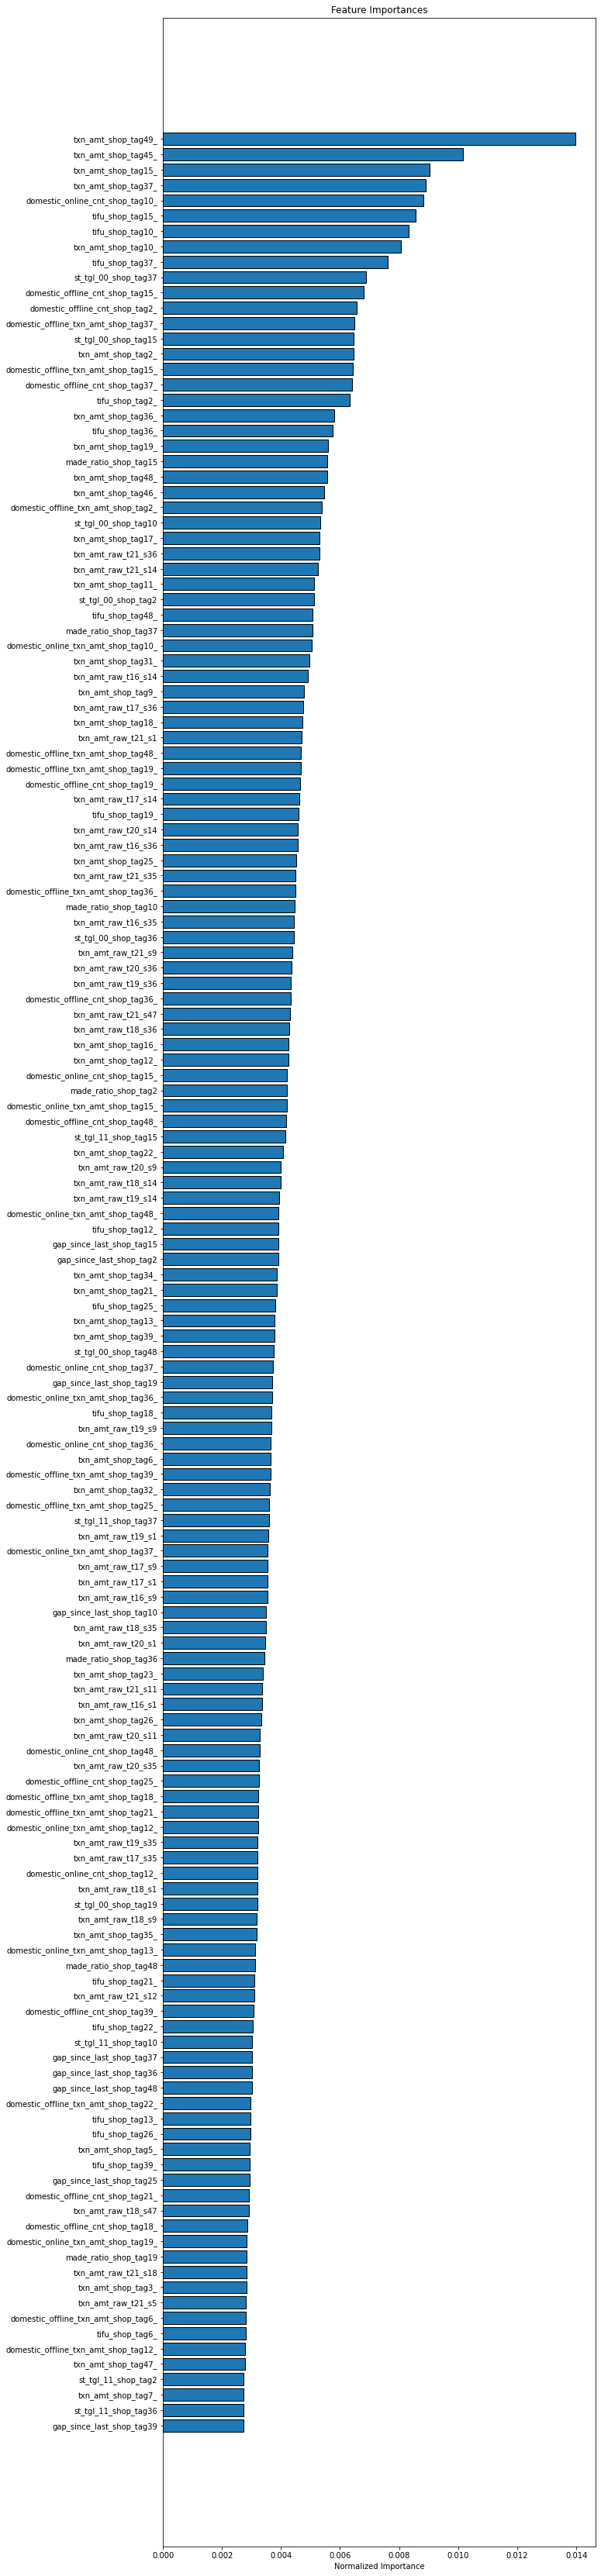

In [8]:
feat_imp144 = models['v144'].feature_importance()
feat_imp144 = pd.DataFrame({'feature': models['v144'].feature_name(), 'importance': feat_imp144})
df = plot_feature_importances(feat_imp144)

## Post Processing 
For those samples with special properties (*e.g.*, make the first transaction at the last month considered by the training set (`t_end`)), I try to use some simple rule-based adjustment to avoid model's random guessing.